In [241]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
udev            213G     0  213G   0% /dev
tmpfs            43G  4.0G   39G  10% /run
/dev/sda1        62G   32G   31G  51% /
tmpfs           213G  244K  213G   1% /dev/shm
tmpfs           5.0M     0  5.0M   0% /run/lock
tmpfs           213G     0  213G   0% /sys/fs/cgroup
/dev/sdb1       851G   75G  733G  10% /mnt
tmpfs            43G  328K   43G   1% /run/user/1000


In [242]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import sklearn
from sklearn import metrics
import sklearn.model_selection
import datetime
import time
import os
import math
random.seed(1)
%matplotlib inline

In [243]:
import multiprocessing as mp
mp.cpu_count()

64

#### Deleted objects with missings in annual_inc

In [244]:
DATA_FOLDER = 'LendingClub Dataset 2017Q1'
# TARGET_NAME = 'Status'

df_train = pd.read_csv(os.path.join(DATA_FOLDER, 'df_train.csv'), index_col=0)
df_test = pd.read_csv(os.path.join(DATA_FOLDER, 'df_test.csv'), index_col=0)
df_train.shape
df_test.shape

(19984, 145)

(4999, 145)

In [245]:
default_definition = ["Default", 
                      "Charged Off", 
                      "In Grace Period",
                      "Late (16-30 days)", 
                      "Late (31-120 days)"]

In [246]:
df_train['default'] = df_train['loan_status'].isin(default_definition)*1
df_test['default'] = df_test['loan_status'].isin(default_definition)*1
df_train['default'].mean()
df_test['default'].mean()

0.07721176941553243

0.06981396279255851

In [247]:
# fields = ["term",
# "int_rate",
# "grade",
# "emp_length" ,
# "home_ownership",
# "annual_inc",
# "verification_status",
# "issue_d",
# "pymnt_plan" ,
# "purpose" ,
# # "addr_state" ,
# "dti",
# "delinq_2yrs",
# "earliest_cr_line" ,
# "inq_last_6mths",
# "open_acc",
# "pub_rec" ,
# "revol_bal",
# "revol_util",
# "initial_list_status" ,
# "out_prncp_inv" ,
# "total_rec_late_fee" ,
# "collection_recovery_fee" ,
# "last_pymnt_d",
# "last_pymnt_amnt" ,
# "last_credit_pull_d",
# "collections_12_mths_ex_med" ,
# "mths_since_last_major_derog" ,
# "application_type" ,
# "acc_now_delinq",
# "tot_coll_amt" ,
# "tot_cur_bal",
# "default"]
# df_train = df_train[fields]
# df_test = df_test[fields]

In [248]:
fields = ["term", "grade", "emp_length", "home_ownership", "annual_inc",
    "purpose", "pymnt_plan", "out_prncp_inv", "delinq_2yrs"]
df_train = df_train[fields]
df_test = df_test[fields]

In [249]:
df_test.head()

,term,grade,emp_length,home_ownership,annual_inc,purpose,pymnt_plan,out_prncp_inv,delinq_2yrs
31360,60 months,B,10+ years,RENT,72000.0,debt_consolidation,n,14476.82,0.0
15275,60 months,C,10+ years,MORTGAGE,200000.0,credit_card,n,17160.76,0.0
77068,60 months,C,10+ years,MORTGAGE,135000.0,debt_consolidation,n,27625.14,0.0
90199,36 months,B,NaN,MORTGAGE,76000.0,debt_consolidation,n,14748.82,1.0
81687,60 months,B,10+ years,MORTGAGE,650000.0,credit_card,n,22334.61,0.0


In [250]:
df_test.shape

(4999, 9)

In [251]:
for col in df_train.columns:
    col, df_train[col].unique()

('term', array([' 36 months', ' 60 months'], dtype=object))

('grade', array(['C', 'B', 'D', 'E', 'A', 'F', 'G'], dtype=object))

('emp_length',
 array(['2 years', '3 years', '9 years', '4 years', '10+ years', nan,
        '< 1 year', '5 years', '1 year', '7 years', '6 years', '8 years'],
       dtype=object))

('home_ownership', array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object))

('annual_inc',
 array([100000.,  33600.,  34000., ...,  22080.,  81563.,  21170.]))

('purpose',
 array(['debt_consolidation', 'credit_card', 'other', 'home_improvement',
        'medical', 'major_purchase', 'moving', 'car', 'small_business',
        'house', 'vacation', 'renewable_energy'], dtype=object))

('pymnt_plan', array(['n', 'y'], dtype=object))

('out_prncp_inv',
 array([12812.61,     0.  ,  3746.04, ...,  4168.05,  2399.33,  6688.59]))

('delinq_2yrs',
 array([ 0.,  1.,  2.,  3.,  5.,  4., 19.,  7.,  6., 10.,  8., 11.,  9.,
        15., 12., 18.]))

In [252]:
# categ_features = ['home_ownership','purpose','addr_state', 'verification_status']
# categ_features = ['home_ownership','purpose', 'verification_status']
categ_features = ['home_ownership','purpose']

In [253]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
ohe.fit(df_train[categ_features])

df_train_categ = pd.DataFrame(ohe.transform(df_train[categ_features])).astype(int)
df_test_categ = pd.DataFrame(ohe.transform(df_test[categ_features])).astype(int)
df_train_categ.shape
df_test_categ.shape

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=False)

(19984, 16)

(4999, 16)

In [254]:
for i in df_train_categ.columns:
    df_train[i] = df_train_categ.values.astype(int)[:,i]
    df_test[i] = df_test_categ.values.astype(int)[:,i]

In [255]:
df_train.drop(categ_features, axis=1, inplace=True)
df_test.drop(categ_features, axis=1, inplace=True)

In [256]:
term_dict_repl = {
    ' 36 months':36, 
    ' 60 months':60    
}

grade_dict_repl = {
    'C':3, 
    'B':2,
    'D':4,
    'E':5,
    'A':1,
    'F':6,
    'G':7
}

emp_length_dict_repl = {
    '2 years':2,
    '3 years':3, 
    '9 years':9,
    '4 years':4,
    '10+ years':10,
    '< 1 year':0,
    '5 years':5,
    '1 year':1,
    '7 years':7,
    '6 years':6,
    '8 years':8
}

pymnt_plan_dict_repl = {
    'n':0, 
    'y':1,
}

application_type_dict_repl = {
    'Individual':1, 
    'Joint App':2    
}

initial_list_status_dict_repl = {
    'w':0, 
    'f':1,
}


In [257]:
# df_train['int_rate'] = df_train['int_rate'].str.strip(' %').astype(np.float32)
# df_test['int_rate'] = df_test['int_rate'].str.strip(' %').astype(np.float32)
# df_train['revol_util'] = df_train['revol_util'].str.strip(' %').astype(np.float32)
# df_test['revol_util'] = df_test['revol_util'].str.strip(' %').astype(np.float32)
df_train['term'] = df_train['term'].replace(term_dict_repl).astype(np.float32)
df_test['term'] = df_test['term'].replace(term_dict_repl).astype(np.float32)
df_train['grade'] = df_train['grade'].replace(grade_dict_repl).astype(np.float32)
df_test['grade'] = df_test['grade'].replace(grade_dict_repl).astype(np.float32)
df_train['emp_length'] = df_train['emp_length'].replace(emp_length_dict_repl).astype(np.float32)
df_test['emp_length'] = df_test['emp_length'].replace(emp_length_dict_repl).astype(np.float32)
df_train['pymnt_plan'] = df_train['pymnt_plan'].replace(pymnt_plan_dict_repl).astype(np.float32)
df_test['pymnt_plan'] = df_test['pymnt_plan'].replace(pymnt_plan_dict_repl).astype(np.float32)
# df_train['application_type'] = df_train['application_type'].replace(application_type_dict_repl).astype(np.float32)
# df_test['application_type'] = df_test['application_type'].replace(application_type_dict_repl).astype(np.float32)
# df_train['initial_list_status'] = df_train['initial_list_status'].replace(initial_list_status_dict_repl).astype(np.float32)
# df_test['initial_list_status'] = df_test['initial_list_status'].replace(initial_list_status_dict_repl).astype(np.float32)

In [258]:
df_test.head()

,term,grade,emp_length,annual_inc,pymnt_plan,out_prncp_inv,delinq_2yrs,0,1,2,...,6,7,8,9,10,11,12,13,14,15
31360,60.0,2.0,10.0,72000.0,0.0,14476.82,0.0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
15275,60.0,3.0,10.0,200000.0,0.0,17160.76,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
77068,60.0,3.0,10.0,135000.0,0.0,27625.14,0.0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
90199,36.0,2.0,NaN,76000.0,0.0,14748.82,1.0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
81687,60.0,2.0,10.0,650000.0,0.0,22334.61,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [259]:
# date_features = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']

# df_train.drop(date_features, axis=1, inplace=True)
# df_test.drop(date_features, axis=1, inplace=True)

In [260]:
TARGET_NAME = 'annual_inc'
y_train = df_train[TARGET_NAME].values
y_test = df_test[TARGET_NAME].values

In [261]:
df_train.drop(TARGET_NAME, axis=1, inplace=True)
df_test.drop(TARGET_NAME, axis=1, inplace=True)

In [262]:
X_train = df_train.values
X_test = df_test.values

### PatternStructuresRegMiner

In [263]:
def nunique_percol_sort(a):
    """Number of unique values in a row of array"""
    b = np.sort(a,axis=1)
    return (b[:,1:] != b[:,:-1]).sum(axis=1)+1

class PatternStructuresRegMiner():
    """
    Basic class to explore intersections of objects and build hypotheses
    """
    def __init__(self, 
                 train_data,
                 y_train,
                 feature_list):
        """
        :param train_data: Pandas.DataFrame with objects
        :param y_train: Target variable (numpy.array)
        :param feature_list: list of column names used as features
        """
        self.train_data = train_data[feature_list]
        self.y_train = y_train
        self.y_train_indexes = np.array(range(self.y_train.shape[0]))
        self.X_expanded = np.expand_dims(self.train_data.values, 0)
        self.feature_list = feature_list
        self.is_nan_X_expanded = np.isnan(self.X_expanded)
    
    def mine_obj_intersections(self, 
                               train_indexes_to_sample, 
                               n_obj,
                               subs_size):
        # np.random.choice is too slow
        print("Mining {} intersections".format(n_obj))
        
        indexes = np.random.choice(train_indexes_to_sample, (n_obj,subs_size))
        # provide objects in subsamples are unique
        #         n_unique = nunique_percol_sort(indexes)
        #         indexes = indexes[n_unique == subs_size] # A_0

        # left & right borders of interval pattern structures
        concepts_min = np.expand_dims(np.nanmin(self.train_data.values[indexes], axis=1), 1)
        concepts_max = np.expand_dims(np.nanmax(self.train_data.values[indexes], axis=1), 1)

        # A_0
        objs_in_concepts = ((((concepts_min <= self.X_expanded) | np.isnan(concepts_min)) & 
                                    ((concepts_max >= self.X_expanded) | np.isnan(concepts_max))) | 
                                    self.is_nan_X_expanded).all(axis=2)
        concepts_y_means = np.apply_along_axis(lambda objs: self.y_train[objs].mean(), 1, objs_in_concepts)
        concepts_y_medians = np.apply_along_axis(lambda objs: np.median(self.y_train[objs]), 1, objs_in_concepts)
        concepts_y_stds = np.apply_along_axis(lambda objs: self.y_train[objs].std(), 1, objs_in_concepts)
        
#         print("objs_in_concepts", objs_in_concepts.shape)
#         print("objs_in_concepts", objs_in_concepts.sum(axis=1))
#         print("INDEXES", indexes[objs_in_concepts.sum(axis=1)==2])
#         print("")
        
        
        return {
            'objs_in_concepts': objs_in_concepts,
            'concepts_y_means': concepts_y_means,
            'concepts_y_medians': concepts_y_medians,
            'concepts_y_stds': concepts_y_stds,
            'concepts_min': concepts_min[:,0,:],
            'concepts_max': concepts_max[:,0,:],
#             'y_mean_train_diff': concepts_y_means - self.y_train.mean()
        }
        
    def mine_hypotheses(self, 
                        y_partition,
                        subs_size,
                        batch_size = 1000,
                        N_hypo_need_partition = None,
                        N_iterations = None,
                        choose_hypo_by='mean'):
        """
        :param choose_hypo_by: "mean" or "median"
        """
        interval_hypos_dict = {}
        for interval_num, y_interval in enumerate(y_partition):
            train_indexes_to_sample = self.y_train_indexes[(y_interval['left'] <= self.y_train) & (self.y_train <= y_interval['right'])]
            
            N_hypo_need = N_hypo_need_partition[interval_num]
            N_mined_hypo = 0
            objs_in_concepts_LIST = []
            concepts_min_LIST = []
            concepts_max_LIST = []
            
            iter_total = 0
            while N_hypo_need is None or N_mined_hypo < N_hypo_need:
                stats_concepts_dict = self.mine_obj_intersections(train_indexes_to_sample, batch_size, subs_size)
                objs_in_concepts = stats_concepts_dict['objs_in_concepts']
                concepts_y_means = stats_concepts_dict['concepts_y_means']
                concepts_y_medians = stats_concepts_dict['concepts_y_medians']
                concepts_min = stats_concepts_dict['concepts_min']
                concepts_max = stats_concepts_dict['concepts_max']
#                 concepts_y_stds = stats_concepts_dict['concepts_y_stds']
                
                is_means_in_interval = (y_interval['left'] <= concepts_y_means) & (concepts_y_means <= y_interval['right'])
                is_medians_in_interval = (y_interval['left'] <= concepts_y_medians) & (concepts_y_medians <= y_interval['right'])
                N_means_in_interval = is_means_in_interval.sum()
                N_medians_in_interval = is_medians_in_interval.sum()
#                 print(N_means_in_interval, "N_means_in_interval", y_interval)
#                 print(N_medians_in_interval, "N_medians_in_interval", y_interval)

                if choose_hypo_by == "mean":
                    N_mined_hypo += N_means_in_interval
                    filter_arr = is_means_in_interval
                else: # if choose_hypo_by == "mean":
                    N_mined_hypo += N_medians_in_interval
                    filter_arr = is_medians_in_interval
                objs_in_concepts = objs_in_concepts[filter_arr]
                concepts_min = concepts_min[filter_arr]
                concepts_max = concepts_max[filter_arr]

                objs_in_concepts_LIST.append(objs_in_concepts)
                concepts_min_LIST.append(concepts_min)
                concepts_max_LIST.append(concepts_max)

                iter_total += batch_size
                if N_iterations and iter_total >= N_iterations:
                    break
                    
            print("N_mined_hypos", N_mined_hypo, "in", y_interval)

            objs_in_concepts_LIST = np.vstack(objs_in_concepts_LIST)
            concepts_min_LIST = np.vstack(concepts_min_LIST)
            concepts_max_LIST = np.vstack(concepts_max_LIST)

            if N_hypo_need:
                objs_in_concepts_LIST = objs_in_concepts_LIST[:N_hypo_need]
                concepts_min_LIST = concepts_min_LIST[:N_hypo_need]
                concepts_max_LIST = concepts_max_LIST[:N_hypo_need]
                
            interval_hypos_dict[interval_num] = {
                'y_interval': y_interval,
                'objs_in_concepts': objs_in_concepts_LIST,
                'concepts_min': concepts_min_LIST,
                'concepts_max': concepts_max_LIST,
                'N_mined_hypo': N_mined_hypo
            }
            
        return interval_hypos_dict
    

### PatternStructuresRegressor

In [264]:
class PatternStructuresRegressor():
    def __init__(self,
                 train_data,
                 y_train,                 
                 feature_list,
                 hypotheses_mined_RES):
        """
        :param train_data: Pandas.DataFrame with objects
        :param y_train: Target variable (numpy.array)
        :param feature_list: list of column names used as features
        :param hypotheses_mined_RES: output of PatternStructuresRegMiner.mine_hypotheses
        """
        self.train_data = train_data[feature_list]
        self.y_train = y_train
        self.y_train_indexes = np.array(range(self.y_train.shape[0]))
        self.X_expanded = np.expand_dims(self.train_data.values, 0)
        self.feature_list = feature_list
        self.is_nan_X_expanded = np.isnan(self.X_expanded)

        objs_in_concepts = []
        concepts_min = []
        concepts_max = []
        for hypo_mined_interval in hypotheses_mined_RES.values():
            objs_in_concepts.append(hypo_mined_interval['objs_in_concepts'])
            concepts_min.append(hypo_mined_interval['concepts_min'])
            concepts_max.append(hypo_mined_interval['concepts_max'])
            
        self.objs_in_concepts = np.vstack(objs_in_concepts)
        self.concepts_min = np.vstack(concepts_min)
        self.concepts_max = np.vstack(concepts_max)
        
    def predict_test_object(self,
                             test_obj):
        """
        :param test_obj: Pandas.DataFrame with objects
        """
#         test_obj = df_test.values[[70]]
        test_obj = test_obj[None,:]
        test_obj_repeated = np.repeat(test_obj[:,None,:], self.concepts_min.shape[0], axis=1)

        regressor_min = np.nanmin(np.concatenate((self.concepts_min[None,:],test_obj_repeated), axis=0), axis=0)[:,None,:]
        regressor_max = np.nanmax(np.concatenate((self.concepts_max[None,:],test_obj_repeated), axis=0), axis=0)[:,None,:]
        objs_in_regressors = ((((regressor_min <= self.X_expanded) | np.isnan(regressor_min)) & 
                                    ((regressor_max >= self.X_expanded) | np.isnan(regressor_max))) | 
                                    self.is_nan_X_expanded).all(axis=2)

        y_min_concepts = np.apply_along_axis(lambda objs: self.y_train[objs].min(), 1, self.objs_in_concepts)
        y_max_concepts = np.apply_along_axis(lambda objs: self.y_train[objs].max(), 1, self.objs_in_concepts)
        y_mean_concepts = np.apply_along_axis(lambda objs: self.y_train[objs].mean(), 1, self.objs_in_concepts)
        y_median_concepts = np.apply_along_axis(lambda objs: np.median(self.y_train[objs]), 1, self.objs_in_concepts)
        y_std_concepts = np.apply_along_axis(lambda objs: self.y_train[objs].std(), 1, self.objs_in_concepts)

        y_min_regressors = np.apply_along_axis(lambda objs: self.y_train[objs].min(), 1, objs_in_regressors)
        y_max_regressors = np.apply_along_axis(lambda objs: self.y_train[objs].max(), 1, objs_in_regressors)
        y_mean_regressors = np.apply_along_axis(lambda objs: self.y_train[objs].mean(), 1, objs_in_regressors)
        y_median_regressors = np.apply_along_axis(lambda objs: np.median(self.y_train[objs]), 1, objs_in_regressors)
        y_std_regressors = np.apply_along_axis(lambda objs: self.y_train[objs].std(), 1, objs_in_regressors)

        N_objs_ratio = self.objs_in_concepts.sum(axis=1) / objs_in_regressors.sum(axis=1)
        std_ratio = y_std_concepts / y_std_regressors
        std_ratio[y_std_regressors == 0] = 1

        final_scores = {}
        for alpha in np.linspace(0,1,101):
            N_obs_ratio_in_scores = N_objs_ratio >= alpha
            y_means_w_concepts_sc = (y_mean_concepts[N_obs_ratio_in_scores]*N_objs_ratio[N_obs_ratio_in_scores]).sum() / \
                N_objs_ratio[N_obs_ratio_in_scores].sum()
            y_means_concepts_sc = y_mean_concepts[N_obs_ratio_in_scores].mean()
            y_median_w_concepts_sc = (y_median_concepts[N_obs_ratio_in_scores]*N_objs_ratio[N_obs_ratio_in_scores]).sum() / \
                N_objs_ratio[N_obs_ratio_in_scores].sum()
            y_median_concepts_sc = y_median_concepts[N_obs_ratio_in_scores].mean()

            y_means_w_regression_sc = (y_mean_regressors[N_obs_ratio_in_scores]*N_objs_ratio[N_obs_ratio_in_scores]).sum() / \
                N_objs_ratio[N_obs_ratio_in_scores].sum()
            y_means_regression_sc = y_mean_regressors[N_obs_ratio_in_scores].mean()
            y_median_w_regression_sc = (y_median_regressors[N_obs_ratio_in_scores]*N_objs_ratio[N_obs_ratio_in_scores]).sum() / \
                N_objs_ratio[N_obs_ratio_in_scores].sum()
            y_median_regression_sc = y_median_regressors[N_obs_ratio_in_scores].mean()

            final_scores['y_means_w_concepts_sc' + '_' + str(round(alpha,2))] = y_means_w_concepts_sc
            final_scores['y_means_concepts_sc' + '_' + str(round(alpha,2))] = y_means_concepts_sc
            final_scores['y_median_w_concepts_sc' + '_' + str(round(alpha,2))] = y_median_w_concepts_sc
            final_scores['y_median_concepts_sc' + '_' + str(round(alpha,2))] = y_median_concepts_sc
            final_scores['y_means_w_regression_sc' + '_' + str(round(alpha,2))] = y_means_w_regression_sc
            final_scores['y_means_regression_sc' + '_' + str(round(alpha,2))] = y_means_regression_sc
            final_scores['y_median_w_regression_sc' + '_' + str(round(alpha,2))] = y_median_w_regression_sc
            final_scores['y_median_regression_sc' + '_' + str(round(alpha,2))] = y_median_regression_sc

        return final_scores

    #         if save_path:
    #             pd.DataFrame(hypotheses_min).to_csv(os.path.join(save_path, "hypotheses_min.csv"), header=None, index=None)
    #             pd.DataFrame(hypotheses_max).to_csv(os.path.join(save_path, "hypotheses_max.csv"), header=None, index=None)

In [265]:
df_train.columns

Index([         'term',         'grade',    'emp_length',    'pymnt_plan',
       'out_prncp_inv',   'delinq_2yrs',               0,               1,
                     2,               3,               4,               5,
                     6,               7,               8,               9,
                    10,              11,              12,              13,
                    14,              15],
      dtype='object')

In [266]:
features = [         'term',         'grade',    'emp_length',    'pymnt_plan',
       'out_prncp_inv',   'delinq_2yrs',               0,               1,
                     2,               3,               4,               5,
                     6,               7,               8,               9,
                    10,              11,              12,              13,
                    14,              15]

In [267]:
%%time
PSM = PatternStructuresRegMiner(df_train, y_train, features)

CPU times: user 7.51 ms, sys: 101 µs, total: 7.61 ms
Wall time: 6.71 ms


(array([2.410e+02, 2.343e+03, 4.841e+03, 4.369e+03, 3.098e+03, 1.853e+03,
        1.146e+03, 7.530e+02, 4.170e+02, 2.610e+02, 1.820e+02, 1.210e+02,
        9.600e+01, 4.100e+01, 2.900e+01, 4.700e+01, 2.500e+01, 3.000e+01,
        3.000e+00, 8.000e+00, 1.900e+01, 7.000e+00, 1.000e+01, 3.000e+00,
        6.000e+00, 1.000e+01, 4.000e+00, 4.000e+00, 0.000e+00, 1.000e+00,
        3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([1.0000000e+00, 1.9700980e+04, 3.9400960e+04, 5.9100940e+04,
        7.8800920e+04, 9.8500900e+04, 1.1820088e+05, 1.3790086e+05,
        1.5760084e+05, 1.7730082e+05, 1.9700080e+05, 2.1670078e+05,
        2.3640076e+05, 2.5610074e+05, 2.7580072e+05, 2.9550070e+05,
        3.1520068e+05, 3.3490066e+05, 3.5460064e+05, 3.7430062e+05,
        3.9400060e+05, 4.1370058e+05

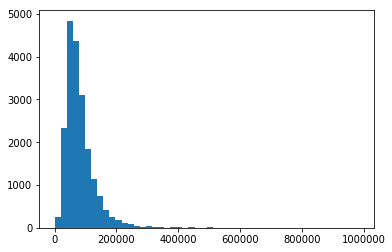

In [268]:
plt.hist(y_train, bins= 50)

In [269]:
N_INTERVALS = 700
partition = pd.Series(y_train).groupby(pd.cut(y_train, N_INTERVALS)).size()
partition

(-983.999, 1408.141]          1
(1408.141, 2815.283]          1
(2815.283, 4222.424]          2
(4222.424, 5629.566]          4
(5629.566, 7036.707]          2
(7036.707, 8443.849]          6
(8443.849, 9850.99]           6
(9850.99, 11258.131]         19
(11258.131, 12665.273]       30
(12665.273, 14072.414]       32
(14072.414, 15479.556]       36
(15479.556, 16886.697]       30
(16886.697, 18293.839]       45
(18293.839, 19700.98]        27
(19700.98, 21108.121]       106
(21108.121, 22515.263]       71
(22515.263, 23922.404]       48
(23922.404, 25329.546]      193
(25329.546, 26736.687]       86
(26736.687, 28143.829]      139
(28143.829, 29550.97]        77
(29550.97, 30958.111]       269
(30958.111, 32365.253]      237
(32365.253, 33772.394]      108
(33772.394, 35179.536]      426
(35179.536, 36586.677]      201
(36586.677, 37993.819]      151
(37993.819, 39400.96]       231
(39400.96, 40808.101]       556
(40808.101, 42215.243]      358
                           ... 
(942785.

In [270]:
TRSLD = 10
final_partition = partition[partition >= TRSLD].index.tolist()
final_partition.append(pd.Interval(partition[partition < TRSLD].index[0].left,
                                   partition[partition < TRSLD].index[-1].right))
final_partition

[Interval(9850.99, 11258.131, closed='right'),
 Interval(11258.131, 12665.273, closed='right'),
 Interval(12665.273, 14072.414, closed='right'),
 Interval(14072.414, 15479.556, closed='right'),
 Interval(15479.556, 16886.697, closed='right'),
 Interval(16886.697, 18293.839, closed='right'),
 Interval(18293.839, 19700.98, closed='right'),
 Interval(19700.98, 21108.121, closed='right'),
 Interval(21108.121, 22515.263, closed='right'),
 Interval(22515.263, 23922.404, closed='right'),
 Interval(23922.404, 25329.546, closed='right'),
 Interval(25329.546, 26736.687, closed='right'),
 Interval(26736.687, 28143.829, closed='right'),
 Interval(28143.829, 29550.97, closed='right'),
 Interval(29550.97, 30958.111, closed='right'),
 Interval(30958.111, 32365.253, closed='right'),
 Interval(32365.253, 33772.394, closed='right'),
 Interval(33772.394, 35179.536, closed='right'),
 Interval(35179.536, 36586.677, closed='right'),
 Interval(36586.677, 37993.819, closed='right'),
 Interval(37993.819, 39400

In [271]:
ser_interval_num = pd.Series(y_train).map(lambda x: [x in interval for interval in final_partition].index(True))
N_hypos_in_interval = pd.Series(y_train).groupby(ser_interval_num).size()/pd.Series(y_train).groupby(ser_interval_num).size().sum()

In [272]:
# final_partition = [[interval.left, interval.right] for interval in final_partition]
final_partition = [{'left':interval.left, 'right':interval.right} for interval in final_partition]
len(final_partition)

135

In [273]:
N_hypo_need_total = 4000

##### Select Hypos distribution: uniform or proportional to number of objects

In [274]:
N_hypo_need_partition = (N_hypos_in_interval*N_hypo_need_total).round().astype(int).tolist()

In [534]:
N_hypo_need_partition = [500 for _ in range(len(final_partition))]

In [275]:
N_hypo_need_partition

[4,
 6,
 6,
 7,
 6,
 9,
 5,
 21,
 14,
 10,
 39,
 17,
 28,
 15,
 54,
 47,
 22,
 85,
 40,
 30,
 46,
 111,
 72,
 33,
 110,
 33,
 37,
 72,
 146,
 77,
 31,
 44,
 123,
 30,
 49,
 163,
 21,
 63,
 24,
 135,
 29,
 38,
 131,
 19,
 63,
 19,
 104,
 34,
 32,
 127,
 19,
 41,
 21,
 82,
 34,
 27,
 110,
 12,
 23,
 27,
 43,
 32,
 22,
 10,
 101,
 20,
 25,
 35,
 10,
 23,
 7,
 63,
 10,
 7,
 39,
 9,
 13,
 6,
 80,
 3,
 5,
 40,
 6,
 9,
 3,
 38,
 7,
 5,
 22,
 3,
 3,
 6,
 33,
 6,
 3,
 3,
 15,
 3,
 3,
 51,
 2,
 5,
 2,
 13,
 4,
 2,
 20,
 4,
 15,
 2,
 2,
 10,
 3,
 18,
 2,
 20,
 7,
 9,
 3,
 20,
 5,
 3,
 5,
 7,
 5,
 2,
 5,
 10,
 3,
 2,
 7,
 3,
 5,
 4,
 67]

In [276]:
%%time
hypotheses_mined_RES = PSM.mine_hypotheses(final_partition,
                                           subs_size=2,
                                           batch_size = 1000,
                                           N_hypo_need_partition=N_hypo_need_partition,
                                           N_iterations=100000, 
                                           choose_hypo_by='mean'
                                          )

Mining 1000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos 61 in {'left': 9850.99, 'right': 11258.131}
Mining 1000 intersections
N_mined_hypos 64 in {'left': 11258.131, 'right': 12665.273}
Mining 1000 intersections
N_mined_hypos 46 in {'left': 12665.273, 'right': 14072.414}
Mining 1000 intersections
N_mined_hypos 54 in {'left': 14072.414, 'right': 15479.556}
Mining 1000 intersections
N_mined_hypos 31 in {'left': 15479.556, 'right': 16886.697}
Mining 1000 intersections
N_mined_hypos 32 in {'left': 16886.697, 'right': 18293.839}
Mining 1000 intersections
N_mined_hypos 44 in {'left': 18293.839, 'right': 19700.98}
Mining 1000 intersections
N_mined_hypos 24 in {'left': 19700.98, 'right': 21108.121}
Mining 1000 intersections
N_mined_hypos 24 in {'left': 21108.121, 'right': 22515.263}
Mining 1000 intersections
N_mined_hypos 19 in {'left': 22515.263, 'right': 23922.404}
Mining 1000 intersections
Mining 1000 intersections
Mining 1000 intersections
N_mined_hypos 44 in {'left': 23922.404, 'right': 25329.546}
Mining 1000 intersections
N_mine

N_mined_hypos 30 in {'left': 108350.89, 'right': 109758.031}
Mining 1000 intersections
Mining 1000 intersections
Mining 1000 intersections
Mining 1000 intersections
Mining 1000 intersections
Mining 1000 intersections
N_mined_hypos 69 in {'left': 109758.031, 'right': 111165.173}
Mining 1000 intersections
N_mined_hypos 15 in {'left': 111165.173, 'right': 112572.314}
Mining 1000 intersections
N_mined_hypos 18 in {'left': 112572.314, 'right': 113979.456}
Mining 1000 intersections
Mining 1000 intersections
Mining 1000 intersections
Mining 1000 intersections
N_mined_hypos 49 in {'left': 113979.456, 'right': 115386.597}
Mining 1000 intersections
N_mined_hypos 24 in {'left': 115386.597, 'right': 116793.739}
Mining 1000 intersections
N_mined_hypos 23 in {'left': 116793.739, 'right': 118200.88}
Mining 1000 intersections
N_mined_hypos 32 in {'left': 118200.88, 'right': 119608.021}
Mining 1000 intersections
Mining 1000 intersections
Mining 1000 intersections
Mining 1000 intersections
Mining 1000 i

In [277]:
%%time
PSR = PatternStructuresRegressor(df_train, y_train, features, hypotheses_mined_RES)

CPU times: user 27.8 ms, sys: 20.1 ms, total: 47.9 ms
Wall time: 46.9 ms


In [278]:
# test_obj = df_test.values[300]
# PSR.predict_test_object(test_obj)

#### Parallel through X_test (one set of params)

In [279]:
N_PROC = 50
batch_size = int(np.ceil(df_test.shape[0]/N_PROC))
batch_size

MyParamGrid = []
# for i in range(N_PROC):
for i in range(df_test.shape[0]):
    test_obj = df_test.values[i]
    args = {
        'test_obj':test_obj,
    }
    MyParamGrid.append(args)

100

In [280]:
%%time
_ = PSR.predict_test_object(df_test.values[0])

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal


CPU times: user 6.89 s, sys: 2.36 s, total: 9.25 s
Wall time: 9.24 s


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


#### Run parallel

In [281]:
%%time
import multiprocessing
pool = multiprocessing.Pool(processes=N_PROC) # use all available cores, otherwise specify the number you want as an argument

results = []
for args in MyParamGrid:
    res = pool.apply_async(PSR.predict_test_object, args=(args['test_obj'],))
    results.append(res)
    
pool.close()
pool.join()#### Run parallel

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountere

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-pac

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/si

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice.
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice.


CPU times: user 12min 5s, sys: 16min 56s, total: 29min 1s
Wall time: 44min 34s


#### Collect results (one set of params)

In [282]:
df_results = pd.DataFrame([res.get() for res in results])
df_results.shape

(4999, 808)

In [315]:
df_results.head()

,y_means_concepts_sc_0.0,y_means_concepts_sc_0.01,y_means_concepts_sc_0.02,y_means_concepts_sc_0.03,y_means_concepts_sc_0.04,y_means_concepts_sc_0.05,y_means_concepts_sc_0.06,y_means_concepts_sc_0.07,y_means_concepts_sc_0.08,y_means_concepts_sc_0.09,...,y_median_w_regression_sc_0.91,y_median_w_regression_sc_0.92,y_median_w_regression_sc_0.93,y_median_w_regression_sc_0.94,y_median_w_regression_sc_0.95,y_median_w_regression_sc_0.96,y_median_w_regression_sc_0.97,y_median_w_regression_sc_0.98,y_median_w_regression_sc_0.99,y_median_w_regression_sc_1.0
0,78264.644798,76305.255414,75049.626832,74697.171085,74649.217510,74733.726689,74770.724857,74718.323431,74807.405553,75073.245076,...,71931.605179,72095.304858,72215.580405,72545.714822,72723.695261,73399.064735,73399.064735,74252.586785,74389.290807,73342.158140
1,78264.644798,77640.049690,76094.341607,75040.232982,75243.179693,75689.016652,75936.803182,76663.950959,77237.326211,77179.576177,...,81753.475874,81753.475874,81753.475874,81753.475874,81936.852292,82207.578803,82207.578803,82477.407661,82477.407661,82312.933362
2,78264.644798,78015.386779,76245.793729,75956.388344,76361.145906,77076.711263,77530.086662,77883.568628,78544.590320,79075.176647,...,85979.227506,86009.142987,86021.154633,86340.994879,86567.023841,86646.585705,87447.406717,88554.634006,89136.577050,89254.550265
3,78264.644798,80184.275029,79263.555820,78324.298395,77734.099470,77137.578584,76157.871952,76170.117829,75765.801414,75812.870631,...,83284.886433,83688.912224,83584.033983,83728.965977,83744.373951,84174.944359,84469.430320,84647.024228,85126.962340,85051.575000
4,78264.644798,82923.110505,82845.900959,82222.249854,82047.941716,82554.780730,82914.388788,83437.799343,83400.337496,84360.614767,...,90822.345571,91097.191745,91765.609761,91765.609761,91765.609761,92037.931445,92505.297339,91475.712036,92002.907568,92002.907568


In [316]:
df_results.fillna(y_train.mean(), inplace=True)

In [317]:
y_test.shape

(4999,)

In [318]:
df_results.values

array([[ 78264.64479837,  76305.25541354,  75049.62683188, ...,
         74252.58678508,  74389.29080667,  73342.15813953],
       [ 78264.64479837,  77640.04969042,  76094.34160682, ...,
         82477.40766107,  82477.40766107,  82312.93336201],
       [ 78264.64479837,  78015.38677889,  76245.7937287 , ...,
         88554.63400626,  89136.57705037,  89254.5502652 ],
       ...,
       [ 78264.64479837,  80117.10623351,  79211.36362763, ...,
        158428.64820179, 162151.885918  , 162151.885918  ],
       [ 78264.64479837,  68822.83453206,  67210.92200903, ...,
         50966.46379428,  50966.46379428,  50966.46379428],
       [ 78264.64479837,  67911.29095664,  68132.03457013, ...,
         58929.19402062,  58929.19402062,  58929.19402062]])

In [319]:
MAPE = np.abs((df_results.values - y_test[:,None])/y_test[:,None]).mean(axis=0)*100
MAPE.min()

38.53217407296962

### Benchmarks

In [289]:
from sklearn import ensemble, model_selection
from sklearn import tree
from sklearn import neighbors

In [290]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [291]:
df_train.isnull().sum()

term                0
grade               0
emp_length       1372
pymnt_plan          0
out_prncp_inv       0
delinq_2yrs         0
0                   0
1                   0
2                   0
3                   0
4                   0
5                   0
6                   0
7                   0
8                   0
9                   0
10                  0
11                  0
12                  0
13                  0
14                  0
15                  0
dtype: int64

#### RF

In [295]:
np.random.seed(42)

In [296]:
param_grid = {
    'min_samples_leaf': [1,2,4,8,16,32],
    'min_samples_split': [2,4,8,16,32,64],
    'n_estimators': [100,500,1000],
    'n_jobs': [-1],
    'verbose': [1]
}

In [297]:
Grid = list(model_selection.ParameterGrid(param_grid))

METRIC_LIST = []
for params in Grid:
    clf = ensemble.RandomForestRegressor(**params)
    clf.fit(df_train.fillna(df_train.mean()), y_train)
    METRIC_LIST.append({
        'train':mean_absolute_percentage_error(y_train, clf.predict(df_train.fillna(df_train.mean()))),
        'test':mean_absolute_percentage_error(y_test, clf.predict(df_test.fillna(df_train.mean()))),
    })
    METRIC_LIST[-1]
    

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 48.17247589432557, 'train': 379.4593244686874}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 48.170992398813745, 'train': 316.98977011635543}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 48.123484594310156, 'train': 327.107446952379}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 47.646076750517366, 'train': 363.836258964927}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 47.595862448921594, 'train': 447.4511069234948}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished


{'test': 47.617308127791716, 'train': 408.6847105613824}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 46.53970682203832, 'train': 547.7572787547025}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.8s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 46.582115881081435, 'train': 520.9531151700513}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 46.52933277985235, 'train': 499.7623049059662}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 45.573814820435956, 'train': 628.6595092392448}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 45.55740408472472, 'train': 629.4444434001801}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 45.54004180694001, 'train': 622.1982165549426}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.82998624567195, 'train': 738.3734978446178}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.87595545180162, 'train': 704.6831291713847}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.2s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.83396168247927, 'train': 694.4395939039566}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.52651556287564, 'train': 727.2764717903567}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.469711711014696, 'train': 727.0546320987136}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.2s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.43191538614339, 'train': 727.3854938859843}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 46.70725893404734, 'train': 487.4643277489685}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 46.66078751083253, 'train': 479.8917643828181}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 46.69643249827319, 'train': 502.1931432561931}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 46.78902932926835, 'train': 492.6066585396206}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 46.69453285619394, 'train': 486.845565367907}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished


{'test': 46.630963965004746, 'train': 527.3402692889078}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 46.20564274014639, 'train': 568.2550730470589}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.8s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 46.05411791845636, 'train': 571.5901630838704}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 46.08529919013077, 'train': 581.2572571671398}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 45.269427710501255, 'train': 661.8299136573339}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.8s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 45.31971224409132, 'train': 669.0791681054134}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 45.318107767284175, 'train': 654.5120323010981}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.84901253134246, 'train': 691.9055041390492}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.74306183590421, 'train': 717.2813930287782}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.73640899724271, 'train': 706.1230799370139}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.381261796578464, 'train': 726.8432309979586}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.392431702828, 'train': 741.7588512285238}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished


{'test': 44.39220477966788, 'train': 735.3528241784492}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 45.65430441241023, 'train': 657.9777452543959}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 45.447224194302365, 'train': 638.0047575726759}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 45.48635608294476, 'train': 642.9352880922318}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 45.44964363385019, 'train': 645.0282718919199}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 45.5103679714951, 'train': 642.6149427057386}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 45.510964848407916, 'train': 642.5084741835367}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 45.68745845816376, 'train': 634.7395525599603}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 45.49186447756372, 'train': 627.8786185094957}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 45.503324771397295, 'train': 631.750474364999}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 45.21528224069562, 'train': 679.5473833016027}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 45.08679877534665, 'train': 713.2059712011263}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 45.09310286371216, 'train': 689.0874932303561}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.71986475154262, 'train': 699.6411764086288}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.67533922933707, 'train': 714.5331297026303}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.63572846920343, 'train': 712.2596113749024}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.364344941740875, 'train': 722.5521056801845}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished


{'test': 44.405985151475434, 'train': 736.1257472128439}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.2s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.38528959106752, 'train': 743.1395388977683}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 45.0377008178203, 'train': 738.1953717499829}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.8s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.99503608000944, 'train': 699.3685966980984}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.99723622969344, 'train': 691.6036153990751}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 45.01435062640077, 'train': 735.3358342717296}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.96678758876187, 'train': 702.1034662308895}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.971999576026604, 'train': 696.7738014861919}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 45.01950626343408, 'train': 702.633409903065}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.8s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 45.01096192145556, 'train': 711.1217336339835}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.98339672982022, 'train': 707.6764711677256}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 45.03368845289435, 'train': 712.0339915669092}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.2s finished


{'test': 44.98591299881244, 'train': 708.7255933564301}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.99671309008422, 'train': 705.2891483665214}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.84117842067588, 'train': 706.6226715011741}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.8s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.777502044327306, 'train': 735.3218685207183}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.76476037803822, 'train': 715.8231659315172}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.52472439389751, 'train': 701.7478624476786}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.499317732801856, 'train': 740.0822448147836}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.47851822901552, 'train': 736.1907376640567}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.7398253728257, 'train': 721.0196675582336}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.736284082925046, 'train': 690.8499403848622}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.74119846509085, 'train': 696.9048481966862}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.2s finished


{'test': 44.64864892439995, 'train': 706.1826016935777}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.72145782491954, 'train': 701.562225728807}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.72079359552809, 'train': 700.7229175803317}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.77281229848757, 'train': 710.2336849914824}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.77703534610246, 'train': 698.6739788340523}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.73365813329041, 'train': 697.1016356747862}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.75246763083048, 'train': 685.4339047227459}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.710934560459464, 'train': 697.6644195982839}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.729848804667306, 'train': 698.5642549654216}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.767141433229966, 'train': 696.6975367015687}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.74089428244056, 'train': 696.7735527673261}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.727023787381334, 'train': 695.842736606992}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.59869829461026, 'train': 721.0338652607985}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.54270605189856, 'train': 707.9851580764818}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.2s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.55578030099239, 'train': 717.3545958044255}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.517136190002326, 'train': 709.8492836169108}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.55094342936244, 'train': 704.4184966735855}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.56873201605311, 'train': 709.3093859079165}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.64115744902823, 'train': 706.2780124224566}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.2s finished


{'test': 44.586688912340506, 'train': 709.4846149785309}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.584024472745156, 'train': 710.6227239534606}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.53046520125372, 'train': 706.5227811046135}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.534500703358255, 'train': 710.4484434722466}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.53827940411715, 'train': 707.1090902346513}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.53996190227779, 'train': 708.3165219175862}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.57921936957299, 'train': 710.740357489091}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.557808584406445, 'train': 707.5108516483346}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.53462530408109, 'train': 721.2109026138033}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


{'test': 44.5587408427678, 'train': 703.112356803962}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=32,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.54739833181093, 'train': 707.4953883385684}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


{'test': 44.572582109446564, 'train': 704.1001789838868}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.2s finished


{'test': 44.53476166772883, 'train': 710.5972684327085}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=32, min_samples_split=64,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.5s finished


{'test': 44.55476763227758, 'train': 711.3158050942882}

In [298]:
pd.DataFrame(METRIC_LIST).min()

test      44.364345
train    316.989770
dtype: float64

#### DT

In [299]:
np.random.seed(42)

In [300]:
param_grid = {
    'min_samples_leaf': [1,2,4,8,16,32],
    'min_samples_split': [2,4,8,16,32,64],
}

In [301]:
Grid = list(model_selection.ParameterGrid(param_grid))

METRIC_LIST = []
for params in Grid:
    clf = tree.DecisionTreeRegressor(**params)
    clf.fit(df_train.fillna(df_train.mean()), y_train)
    METRIC_LIST.append({
        'train':mean_absolute_percentage_error(y_train, clf.predict(df_train.fillna(df_train.mean()))),
        'test':mean_absolute_percentage_error(y_test, clf.predict(df_test.fillna(df_train.mean()))),
    })
    

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=16, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=32, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=64, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=16, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=32, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=64, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=16, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=32, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=64, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=16, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=32, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=64, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=16,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=16,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=16,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=16,
           min_samples_split=16, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=16,
           min_samples_split=32, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=16,
           min_samples_split=64, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=32,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=32,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=32,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=32,
           min_samples_split=16, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=32,
           min_samples_split=32, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=32,
           min_samples_split=64, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [302]:
pd.DataFrame(METRIC_LIST).min()

test     45.365711
train     8.508529
dtype: float64

#### kNN

In [303]:
np.random.seed(42)

In [304]:
param_grid = {
    'leaf_size': [1,2,4,8,16,32,64],
    'n_neighbors': [1,2,4,8,16,32,64],
    'p': [1,2,3],
    'n_jobs': [-1],
}

In [305]:
Grid = list(model_selection.ParameterGrid(param_grid))

METRIC_LIST = []
for params in Grid:
    clf = neighbors.KNeighborsRegressor(**params)
    clf.fit(df_train.fillna(df_train.mean()), y_train)
    METRIC_LIST.append({
        'train':mean_absolute_percentage_error(y_train, clf.predict(df_train.fillna(df_train.mean()))),
        'test':mean_absolute_percentage_error(y_test, clf.predict(df_test.fillna(df_train.mean()))),
    })
    

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
          weights='uniform')

KNeighborsRegressor(algorithm='auto', leaf_size=64, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
          weights='uniform')

In [306]:
pd.DataFrame(METRIC_LIST).min()

test     49.225364
train     9.961817
dtype: float64

#### xgboost

In [307]:
np.random.seed(42)

In [308]:
import xgboost as xgb

In [309]:
dtrain = xgb.DMatrix(df_train.fillna(df_train.mean()), label=y_train)
dtest = xgb.DMatrix(df_test.fillna(df_train.mean()), label=y_test)

In [310]:
param_grid = {
        'min_child_weight': [1, 5, 10, 20],
        'gamma': [0.5, 1, 1.5, 2, 5, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7],
        'nthread': [-1],
#         'eval_metric': ['mae'],
        "objective": ["reg:linear"], 
        }

In [311]:
def xgb_mape(preds, dtrain):
    labels = dtrain.get_label()
    return('mape', -np.mean(np.abs((labels - preds) / (labels+1))))

In [312]:
Grid = list(model_selection.ParameterGrid(param_grid))

METRIC_LIST = []
for params in Grid:
    evallist = [(dtrain, 'train'), (dtest, 'eval')]
    num_round = 100
#     bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=10)
    bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=10, feval=xgb_mape)
    METRIC_LIST.append({
        'train':mean_absolute_percentage_error(y_train, bst.predict(dtrain)),
        'test':mean_absolute_percentage_error(y_test, bst.predict(dtest)),
    })
    

[06:39:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77466.7	eval-rmse:77621.2	train-mape:-1.63295	eval-mape:-0.627797
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:39:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64497.1	eval-rmse:64564.1	train-mape:-2.1	eval-mape:-0.4284
[06:39:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57106.4	eval-rmse:57230	train-mape:-2.46805	eval-mape:-0.367881
[06:39:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:53166.7	eval-rmse:53246.2	train-mape:-2.73011	eval-mape:-0.372242
[06:39:42] /workspace/src/tree/updater_prune.cc:7

[06:39:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:53166.7	eval-rmse:53246.2	train-mape:-2.73011	eval-mape:-0.372242
[06:39:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:51020.3	eval-rmse:51106.7	train-mape:-2.69299	eval-mape:-0.388032
[06:39:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49955.2	eval-rmse:50025.9	train-mape:-2.8876	eval-mape:-0.413111
[06:39:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48770	eval-rmse:48880.4	train-mape:-3.06028	eval-mape:-0.423118
[06:39:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48176.1	eval-rmse:48359.5	train-mape:-3.1294	eval

[6]	train-rmse:48770	eval-rmse:48880.4	train-mape:-3.06028	eval-mape:-0.423118
[06:39:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48176.1	eval-rmse:48359.5	train-mape:-3.1294	eval-mape:-0.43332
[06:39:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47908.5	eval-rmse:48095	train-mape:-3.23394	eval-mape:-0.44043
[06:39:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47743.9	eval-rmse:48008.5	train-mape:-3.28531	eval-mape:-0.448087
[06:39:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47578.8	eval-rmse:47858.2	train-mape:-3.29157	eval-mape:-0.450879
Stopping. Best iteration:
[0]	train-rmse:77466.7	eval-rmse:77621.2	train-mape:-1.63295	eval-mape:-0.627797

[

Stopping. Best iteration:
[0]	train-rmse:77466.7	eval-rmse:77621.2	train-mape:-1.63295	eval-mape:-0.627797

[06:39:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77485.1	eval-rmse:77622.2	train-mape:-1.64038	eval-mape:-0.628939
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:39:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64493.6	eval-rmse:64617.3	train-mape:-2.13423	eval-mape:-0.428848
[06:39:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57052.7	eval-rmse:57136	train-mape:-2.49918	eval-mape:-0.369409
[06:39:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:5

[2]	train-rmse:56464.5	eval-rmse:56575.3	train-mape:-2.61586	eval-mape:-0.362402
[06:39:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52377.5	eval-rmse:52499.9	train-mape:-2.69559	eval-mape:-0.35821
[06:39:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:50272.1	eval-rmse:50422.5	train-mape:-2.72285	eval-mape:-0.37555
[06:39:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:49209.2	eval-rmse:49350.9	train-mape:-2.90154	eval-mape:-0.40024
[06:39:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:48130.4	eval-rmse:48403.1	train-mape:-3.07528	eval-mape:-0.412364
[06:39:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned no

[06:39:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47537.6	eval-rmse:47911.4	train-mape:-3.20606	eval-mape:-0.423071
[06:39:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47181.3	eval-rmse:47735.1	train-mape:-3.36546	eval-mape:-0.431401
[06:39:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:46995.7	eval-rmse:47636.3	train-mape:-3.42181	eval-mape:-0.438523
[06:39:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:46866.6	eval-rmse:47556.6	train-mape:-3.43603	eval-mape:-0.442986
Stopping. Best iteration:
[0]	train-rmse:77303.3	eval-rmse:77424.2	train-mape:-1.73033	eval-mape:-0.630821

[06:39:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[10]	train-rmse:46949.5	eval-rmse:47502.2	train-mape:-3.36617	eval-mape:-0.44299
Stopping. Best iteration:
[0]	train-rmse:77303.3	eval-rmse:77424.2	train-mape:-1.73033	eval-mape:-0.630821

[06:39:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77548.1	eval-rmse:77655.5	train-mape:-1.75588	eval-mape:-0.629443
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:39:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:65269.5	eval-rmse:65294.9	train-mape:-1.86918	eval-mape:-0.422133
[06:39:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:57548.2	eval-rmse:57546.5	train-mape:-2.47019	eval-mape:-0.359319
[06:39:46] /workspace/src/tree/updater_prune.cc:74: tree

[06:39:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:57551.8	eval-rmse:57543.8	train-mape:-2.4702	eval-mape:-0.359336
[06:39:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52771.1	eval-rmse:52816.2	train-mape:-2.78936	eval-mape:-0.355216
[06:39:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:50292.2	eval-rmse:50457.9	train-mape:-3.06196	eval-mape:-0.37723
[06:39:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:48852	eval-rmse:49079.7	train-mape:-3.21876	eval-mape:-0.39617
[06:39:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:48048.4	eval-rmse:48349.8	train-mape:-3.41881	eval-

[06:39:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:46970.2	eval-rmse:48156.1	train-mape:-3.36906	eval-mape:-0.402299
[06:39:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46513.2	eval-rmse:47779.1	train-mape:-3.48777	eval-mape:-0.413868
[06:39:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46274.6	eval-rmse:47562.7	train-mape:-3.57077	eval-mape:-0.423803
[06:39:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46060.8	eval-rmse:47481.4	train-mape:-3.62727	eval-mape:-0.429524
[06:39:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:45847.5	eval-rmse:47451.7	train-mape:-3.66987

[06:39:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46044.3	eval-rmse:47602.3	train-mape:-3.63419	eval-mape:-0.434291
Stopping. Best iteration:
[0]	train-rmse:77401.5	eval-rmse:77638	train-mape:-1.75717	eval-mape:-0.630667

[06:39:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:77154.4	eval-rmse:77375.3	train-mape:-1.56117	eval-mape:-0.631573
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:39:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:63914.6	eval-rmse:64141.3	train-mape:-2.1813	eval-mape:-0.426428
[06:39:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:5

[06:39:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:56277.1	eval-rmse:56569.6	train-mape:-2.58106	eval-mape:-0.356104
[06:39:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:52184.7	eval-rmse:52502.8	train-mape:-2.63634	eval-mape:-0.352493
[06:39:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:50098.7	eval-rmse:50456.6	train-mape:-2.71682	eval-mape:-0.370586
[06:39:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:49029.4	eval-rmse:49387	train-mape:-2.89084	eval-mape:-0.395458
[06:39:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47883.5	eval-rmse:48351.3	train-mape:-3.07031	ev

[06:39:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:47060.2	eval-rmse:48602.9	train-mape:-2.92228	eval-mape:-0.401399
[06:39:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:46414.5	eval-rmse:48241.4	train-mape:-3.00145	eval-mape:-0.413303
[06:39:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:45975.1	eval-rmse:48191.5	train-mape:-3.12543	eval-mape:-0.421875
[06:39:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:45701.7	eval-rmse:48158.1	train-mape:-3.20663	eval-mape:-0.429138
[06:39:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:45533.7	eval-rmse:48133.8	train-mape:-3.2

[06:39:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:45877	eval-rmse:47781	train-mape:-3.29524	eval-mape:-0.433878
Stopping. Best iteration:
[0]	train-rmse:77050.6	eval-rmse:77334.4	train-mape:-1.56273	eval-mape:-0.632889

[06:39:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:77058.2	eval-rmse:77295.9	train-mape:-1.51119	eval-mape:-0.633136
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:39:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:63616.6	eval-rmse:63935.6	train-mape:-1.99806	eval-mape:-0.426863
[06:39:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse

[06:39:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:55709.9	eval-rmse:56277.2	train-mape:-2.38687	eval-mape:-0.355073
[06:39:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51592.4	eval-rmse:52263.9	train-mape:-2.5147	eval-mape:-0.35011
[06:39:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:49427.8	eval-rmse:50150.9	train-mape:-2.60825	eval-mape:-0.367302
[06:39:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:48354.3	eval-rmse:49095.3	train-mape:-2.7741	eval-mape:-0.391734
[06:39:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:47188.9	eval-rmse:48144.6	train-mape:-2.88513	

[06:39:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:47389.7	eval-rmse:48177.4	train-mape:-2.92104	eval-mape:-0.402786
[06:39:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:46770.5	eval-rmse:47785.9	train-mape:-3.05255	eval-mape:-0.415175
[06:39:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:46382.4	eval-rmse:47640.6	train-mape:-3.22066	eval-mape:-0.424358
[06:39:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:46135.1	eval-rmse:47610.6	train-mape:-3.1953	eval-mape:-0.431646
[06:39:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:46024.3	eval-rmse:47572.2	train-mape:-3.20607	

[06:39:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:43887.4	eval-rmse:47835.5	train-mape:-2.41735	eval-mape:-0.434141
Stopping. Best iteration:
[0]	train-rmse:76939.4	eval-rmse:77275.6	train-mape:-0.635486	eval-mape:-0.634467

[06:39:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:77140.5	eval-rmse:77598.5	train-mape:-1.76818	eval-mape:-0.632824
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:39:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:64564.1	eval-rmse:65086.1	train-mape:-2.0377	eval-mape:-0.420876
[06:39:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[2]	train

[06:39:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:56649.1	eval-rmse:57438.9	train-mape:-2.44905	eval-mape:-0.355577
[06:39:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:51428.9	eval-rmse:52793.6	train-mape:-2.80835	eval-mape:-0.34995
[06:39:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:48635.4	eval-rmse:50498.9	train-mape:-3.218	eval-mape:-0.367446
[06:39:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:46861	eval-rmse:49205.6	train-mape:-3.4877	eval-mape:-0.384246
[06:39:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:45762.3	eval-rmse:48649.2	train-mape:-3.60337	e

[06:39:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:45926.7	eval-rmse:48596.4	train-mape:-3.46749	eval-mape:-0.400259
[06:39:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:45316.7	eval-rmse:48299.5	train-mape:-3.48678	eval-mape:-0.412782
[06:39:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:45062.7	eval-rmse:48152.3	train-mape:-3.55216	eval-mape:-0.423374
[06:39:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:44818.9	eval-rmse:48081	train-mape:-3.6236	eval-mape:-0.430611
[06:39:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:44514.3	eval-rmse:48138.8	train-mape:-3.650

[06:39:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:45212.2	eval-rmse:47885.4	train-mape:-3.66787	eval-mape:-0.436255
Stopping. Best iteration:
[0]	train-rmse:77287	eval-rmse:77586.3	train-mape:-1.7585	eval-mape:-0.634402

[06:39:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77466.7	eval-rmse:77621.2	train-mape:-1.63295	eval-mape:-0.627797
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:39:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64497.1	eval-rmse:64564.1	train-mape:-2.1	eval-mape:-0.4284
[06:39:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57106.

[1]	train-rmse:64497.1	eval-rmse:64564.1	train-mape:-2.1	eval-mape:-0.4284
[06:39:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57106.4	eval-rmse:57230	train-mape:-2.46805	eval-mape:-0.367881
[06:39:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:53166.7	eval-rmse:53246.2	train-mape:-2.73011	eval-mape:-0.372242
[06:39:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:51020.3	eval-rmse:51106.7	train-mape:-2.69299	eval-mape:-0.388032
[06:39:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49955.2	eval-rmse:50025.9	train-mape:-2.8876	eval-mape:-0.413111
[06:39:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, m

[06:40:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48770	eval-rmse:48880.4	train-mape:-3.06028	eval-mape:-0.423118
[06:40:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48176.1	eval-rmse:48359.5	train-mape:-3.1294	eval-mape:-0.43332
[06:40:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47908.5	eval-rmse:48095	train-mape:-3.23394	eval-mape:-0.44043
[06:40:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47743.9	eval-rmse:48008.5	train-mape:-3.28531	eval-mape:-0.448087
[06:40:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47578.8	eval-rmse:47858.2	train-mape:-3.29157	eval-m

[9]	train-rmse:47757.5	eval-rmse:48030.7	train-mape:-3.28732	eval-mape:-0.447849
[06:40:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47592.4	eval-rmse:47880.7	train-mape:-3.2936	eval-mape:-0.45064
Stopping. Best iteration:
[0]	train-rmse:77466.7	eval-rmse:77621.2	train-mape:-1.63295	eval-mape:-0.627797

[06:40:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77485.1	eval-rmse:77622.2	train-mape:-1.64038	eval-mape:-0.628939
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64493.6	eval-rmse:64617.3	train-mape:-2.13423	eval-mape:-0.428848
[06:40:01] /workspace/src/tree/updater_prune.cc:74: tree 

[06:40:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64135.4	eval-rmse:64158.6	train-mape:-2.16622	eval-mape:-0.42887
[06:40:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56464.5	eval-rmse:56575.3	train-mape:-2.61586	eval-mape:-0.362402
[06:40:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52377.5	eval-rmse:52499.9	train-mape:-2.69559	eval-mape:-0.35821
[06:40:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:50272.1	eval-rmse:50422.5	train-mape:-2.72285	eval-mape:-0.37555
[06:40:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:49209.2	eval-rmse:49350.9	train-mape:-2.90154	eva

[06:40:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47258.9	eval-rmse:47699	train-mape:-3.27987	eval-mape:-0.431347
[06:40:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:47071.1	eval-rmse:47589	train-mape:-3.34906	eval-mape:-0.438496
[06:40:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:46949.5	eval-rmse:47502.2	train-mape:-3.36617	eval-mape:-0.44299
Stopping. Best iteration:
[0]	train-rmse:77303.3	eval-rmse:77424.2	train-mape:-1.73033	eval-mape:-0.630821

[06:40:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77548.1	eval-rmse:77655.5	train-mape:-1.75588	eval-mape:-0.629443
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopp

Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:65272.4	eval-rmse:65292.6	train-mape:-1.86916	eval-mape:-0.422119
[06:40:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:57551.8	eval-rmse:57543.8	train-mape:-2.4702	eval-mape:-0.359336
[06:40:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52771.1	eval-rmse:52816.2	train-mape:-2.78936	eval-mape:-0.355216
[06:40:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:50292.2	eval-rmse:50457.9	train-mape:-3.06196	eval-mape:-0.37723
[06:40:04] /workspace/src/tree/updater_prun

[06:40:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49506.7	eval-rmse:50240.9	train-mape:-3.07242	eval-mape:-0.368959
[06:40:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:47880.4	eval-rmse:48855	train-mape:-3.27731	eval-mape:-0.386247
[06:40:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:46970.2	eval-rmse:48156.1	train-mape:-3.36906	eval-mape:-0.402299
[06:40:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46513.2	eval-rmse:47779.1	train-mape:-3.48777	eval-mape:-0.413868
[06:40:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46274.6	eval-rmse:47562.7	train-mape:-3.57077	ev

[06:40:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46410.4	eval-rmse:47719.2	train-mape:-3.52549	eval-mape:-0.424798
[06:40:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46194.3	eval-rmse:47606.1	train-mape:-3.60513	eval-mape:-0.429927
[06:40:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46044.3	eval-rmse:47602.3	train-mape:-3.63419	eval-mape:-0.434291
Stopping. Best iteration:
[0]	train-rmse:77401.5	eval-rmse:77638	train-mape:-1.75717	eval-mape:-0.630667

[06:40:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:77154.4	eval-rmse:77375.3	train-mape:-1.56117	eval-mape:-0.631573
Multiple eval metrics have been passed: 'eval-mape' will be used for early st

[0]	train-rmse:77159.4	eval-rmse:77357.9	train-mape:-1.56116	eval-mape:-0.631403
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:63951.8	eval-rmse:64153.4	train-mape:-2.18076	eval-mape:-0.426549
[06:40:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:56277.1	eval-rmse:56569.6	train-mape:-2.58106	eval-mape:-0.356104
[06:40:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:52184.7	eval-rmse:52502.8	train-mape:-2.63634	eval-mape:-0.352493
[06:40:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:50098.7	eval-rmse:50456.6	

[06:40:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:49406.2	eval-rmse:50599.7	train-mape:-2.58815	eval-mape:-0.364818
[06:40:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:48299.6	eval-rmse:49528.7	train-mape:-2.74996	eval-mape:-0.388563
[06:40:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:47060.2	eval-rmse:48602.9	train-mape:-2.92228	eval-mape:-0.401399
[06:40:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:46414.5	eval-rmse:48241.4	train-mape:-3.00145	eval-mape:-0.413303
[06:40:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:45975.1	eval-rmse:48191.5	train-mape:-3.12

[06:40:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:46320.6	eval-rmse:47875.5	train-mape:-3.1875	eval-mape:-0.421701
[06:40:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:46025.2	eval-rmse:47827.5	train-mape:-3.26511	eval-mape:-0.428853
[06:40:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:45877	eval-rmse:47781	train-mape:-3.29524	eval-mape:-0.433878
Stopping. Best iteration:
[0]	train-rmse:77050.6	eval-rmse:77334.4	train-mape:-1.56273	eval-mape:-0.632889

[06:40:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:77058.2	eval-rmse:77295.9	train-mape:-1.51119	eval-mape:-0.633136
Multiple eval metrics have been passed: 'eval-mape' will be used for early stop

[06:40:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:77078.7	eval-rmse:77242.5	train-mape:-1.511	eval-mape:-0.636084
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:63669.2	eval-rmse:63901.7	train-mape:-1.99885	eval-mape:-0.429551
[06:40:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:55709.9	eval-rmse:56277.2	train-mape:-2.38687	eval-mape:-0.355073
[06:40:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51592.4	eval-rmse:52263.9	train-mape:-2.5147	eval-mape:-0.35011
[06:40:10] /workspace/src/tree/updater_prun

[06:40:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51740.1	eval-rmse:52269.6	train-mape:-2.5957	eval-mape:-0.349054
[06:40:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:49593.2	eval-rmse:50177.3	train-mape:-2.63827	eval-mape:-0.366411
[06:40:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:48521	eval-rmse:49125.3	train-mape:-2.80702	eval-mape:-0.390914
[06:40:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:47389.7	eval-rmse:48177.4	train-mape:-2.92104	eval-mape:-0.402786
[06:40:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:46770.5	eval-rmse:47785.9	train-mape:-3.05255	ev

[06:40:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:45156.7	eval-rmse:47826.9	train-mape:-2.12155	eval-mape:-0.412639
[06:40:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:44501.1	eval-rmse:47865.3	train-mape:-2.35177	eval-mape:-0.421702
[06:40:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:44063.5	eval-rmse:47864.4	train-mape:-2.40521	eval-mape:-0.428965
[06:40:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:43887.4	eval-rmse:47835.5	train-mape:-2.41735	eval-mape:-0.434141
Stopping. Best iteration:
[0]	train-rmse:76939.4	eval-rmse:77275.6	train-mape:-0.635486	eval-mape:-0.634467

[06:40:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 

Stopping. Best iteration:
[0]	train-rmse:76984.4	eval-rmse:77268	train-mape:-1.51266	eval-mape:-0.634416

[06:40:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:77205.8	eval-rmse:77599.5	train-mape:-1.75917	eval-mape:-0.632645
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:64664.8	eval-rmse:65070.7	train-mape:-2.0277	eval-mape:-0.420831
[06:40:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:56649.1	eval-rmse:57438.9	train-mape:-2.44905	eval-mape:-0.355577
[06:40:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rms

[06:40:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:51558.2	eval-rmse:52815.7	train-mape:-2.80877	eval-mape:-0.350124
[06:40:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:48824	eval-rmse:50535.6	train-mape:-3.0976	eval-mape:-0.367311
[06:40:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:47036.9	eval-rmse:49201.1	train-mape:-3.30917	eval-mape:-0.385022
[06:40:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:45926.7	eval-rmse:48596.4	train-mape:-3.46749	eval-mape:-0.400259
[06:40:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:45316.7	eval-rmse:48299.5	train-mape:-3.4867

[06:40:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:45875.1	eval-rmse:48122.1	train-mape:-3.53477	eval-mape:-0.414454
[06:40:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:45658.9	eval-rmse:47955.7	train-mape:-3.59174	eval-mape:-0.424928
[06:40:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:45415	eval-rmse:47850.5	train-mape:-3.73511	eval-mape:-0.431243
[06:40:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:45212.2	eval-rmse:47885.4	train-mape:-3.66787	eval-mape:-0.436255
Stopping. Best iteration:
[0]	train-rmse:77287	eval-rmse:77586.3	train-mape:-1.7585	eval-mape:-0.634402

[06:40:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 root

[10]	train-rmse:47625.2	eval-rmse:47895	train-mape:-3.84859	eval-mape:-0.45407
Stopping. Best iteration:
[0]	train-rmse:77661.1	eval-rmse:77766.1	train-mape:-1.82157	eval-mape:-0.62787

[06:40:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77466.7	eval-rmse:77621.2	train-mape:-1.63295	eval-mape:-0.627797
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64497.1	eval-rmse:64564.1	train-mape:-2.1	eval-mape:-0.4284
[06:40:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57106.4	eval-rmse:57230	train-mape:-2.46805	eval-mape:-0.367881
[06:40:15] /workspace/src/tree/updater_prune.cc:74: tree pruning en

[06:40:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:53166.7	eval-rmse:53246.2	train-mape:-2.73011	eval-mape:-0.372242
[06:40:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:51020.3	eval-rmse:51106.7	train-mape:-2.69299	eval-mape:-0.388032
[06:40:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49955.2	eval-rmse:50025.9	train-mape:-2.8876	eval-mape:-0.413111
[06:40:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48770	eval-rmse:48880.4	train-mape:-3.06028	eval-mape:-0.423118
[06:40:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48176.1	eval-rmse:48359.5	train-mape:-3.1294	eval

[06:40:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:47147.7	eval-rmse:47871.8	train-mape:-3.26081	eval-mape:-0.438327
[06:40:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:47024.3	eval-rmse:47794.9	train-mape:-3.27551	eval-mape:-0.442506
Stopping. Best iteration:
[0]	train-rmse:77298.5	eval-rmse:77403.2	train-mape:-1.55954	eval-mape:-0.629478

[06:40:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77303.3	eval-rmse:77424.2	train-mape:-1.73033	eval-mape:-0.630821
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rms

Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64135.9	eval-rmse:64146.6	train-mape:-2.16623	eval-mape:-0.428887
[06:40:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56482.6	eval-rmse:56571	train-mape:-2.61587	eval-mape:-0.362416
[06:40:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52398.3	eval-rmse:52496.7	train-mape:-2.69556	eval-mape:-0.358256
[06:40:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:50293.8	eval-rmse:50419	train-mape:-2.72281	eval-mape:-0.375585
[06:40:18] /workspace/src/tree/updater_prune.

[06:40:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:50322.5	eval-rmse:50430.4	train-mape:-2.72322	eval-mape:-0.375677
[06:40:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:49261.7	eval-rmse:49355.7	train-mape:-2.90186	eval-mape:-0.400358
[06:40:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:48174.3	eval-rmse:48414.4	train-mape:-3.03411	eval-mape:-0.412475
[06:40:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47589.4	eval-rmse:47958	train-mape:-3.15829	eval-mape:-0.423333
[06:40:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47258.9	eval-rmse:47699	train-mape:-3.27987	eval

[06:40:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47345.2	eval-rmse:47682.4	train-mape:-3.36845	eval-mape:-0.431561
[06:40:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:47173.8	eval-rmse:47556	train-mape:-3.42729	eval-mape:-0.438739
[06:40:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:47045.6	eval-rmse:47487.5	train-mape:-3.4438	eval-mape:-0.443238
Stopping. Best iteration:
[0]	train-rmse:77303.3	eval-rmse:77424.2	train-mape:-1.73033	eval-mape:-0.630821

[06:40:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77550	eval-rmse:77652.9	train-mape:-1.75586	eval-mape:-0.629401
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopp

Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:64928.9	eval-rmse:65113.9	train-mape:-1.80303	eval-mape:-0.419382
[06:40:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:57151.6	eval-rmse:57463.4	train-mape:-2.39711	eval-mape:-0.356592
[06:40:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:52190.4	eval-rmse:52581.2	train-mape:-2.81962	eval-mape:-0.350592
[06:40:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49506.7	eval-rmse:50240.9	train-mape:-3.07242	eval-mape:-0.368959
[06:40:22] /workspace/src/tree/updater_pr

[06:40:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49645.8	eval-rmse:50260.6	train-mape:-3.06569	eval-mape:-0.369361
[06:40:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:48044.4	eval-rmse:48884.4	train-mape:-3.27056	eval-mape:-0.386394
[06:40:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47139	eval-rmse:48245.7	train-mape:-3.3621	eval-mape:-0.402588
[06:40:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46627.4	eval-rmse:47919	train-mape:-3.46286	eval-mape:-0.414688
[06:40:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46410.4	eval-rmse:47719.2	train-mape:-3.52549	eval-

Stopping. Best iteration:
[0]	train-rmse:77430.3	eval-rmse:77627	train-mape:-1.757	eval-mape:-0.632486

[06:40:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:77067.9	eval-rmse:77327.4	train-mape:-1.56273	eval-mape:-0.633097
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:63707	eval-rmse:64285.5	train-mape:-2.09501	eval-mape:-0.428828
[06:40:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:55809.4	eval-rmse:56794.9	train-mape:-2.47829	eval-mape:-0.354486
[06:40:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51

[2]	train-rmse:55884.9	eval-rmse:56620	train-mape:-2.48784	eval-mape:-0.354568
[06:40:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51682.6	eval-rmse:52502.8	train-mape:-2.51854	eval-mape:-0.347924
[06:40:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:49543.2	eval-rmse:50433.4	train-mape:-2.58104	eval-mape:-0.365471
[06:40:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:48451.4	eval-rmse:49359.7	train-mape:-2.74359	eval-mape:-0.38943
[06:40:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:47288.7	eval-rmse:48380.2	train-mape:-2.92079	eval-mape:-0.402022
[06:40:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned

[06:40:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:46291.4	eval-rmse:47513.9	train-mape:-3.41435	eval-mape:-0.436073
Stopping. Best iteration:
[0]	train-rmse:77096.3	eval-rmse:77336.7	train-mape:-1.56242	eval-mape:-0.632394

[06:40:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:77113.9	eval-rmse:77244.9	train-mape:-1.59387	eval-mape:-0.633804
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:63709.9	eval-rmse:63984.7	train-mape:-2.08135	eval-mape:-0.427657
[06:40:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rm

[06:40:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:55102.7	eval-rmse:56348	train-mape:-1.55072	eval-mape:-0.352516
[06:40:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:50845.3	eval-rmse:52317.8	train-mape:-1.64174	eval-mape:-0.347869
[06:40:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:48619.7	eval-rmse:50262.5	train-mape:-1.73609	eval-mape:-0.365935
[06:40:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:47501.9	eval-rmse:49225.3	train-mape:-1.90069	eval-mape:-0.390784
[06:40:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:46110.6	eval-rmse:48322.9	train-mape:-2.060

[06:40:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:46349.9	eval-rmse:48060.2	train-mape:-3.1602	eval-mape:-0.398638
[06:40:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:45656.4	eval-rmse:47682.3	train-mape:-3.18833	eval-mape:-0.40994
[06:40:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:45159.5	eval-rmse:47586.3	train-mape:-3.32734	eval-mape:-0.419087
[06:40:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:44813	eval-rmse:47581.2	train-mape:-3.39102	eval-mape:-0.426418
[06:40:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:44664.9	eval-rmse:47562.2	train-mape:-3.4210

[06:40:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:45164.7	eval-rmse:47422.6	train-mape:-3.63494	eval-mape:-0.435502
Stopping. Best iteration:
[0]	train-rmse:77019.3	eval-rmse:77241.1	train-mape:-1.51223	eval-mape:-0.637322

[06:40:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:77226	eval-rmse:77574.4	train-mape:-1.75895	eval-mape:-0.632502
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:64698.6	eval-rmse:65050.5	train-mape:-2.02712	eval-mape:-0.420709
[06:40:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-r

[1]	train-rmse:64774.9	eval-rmse:65057.3	train-mape:-2.02669	eval-mape:-0.422209
[06:40:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:56868.3	eval-rmse:57446.8	train-mape:-2.37299	eval-mape:-0.356512
[06:40:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:51755.8	eval-rmse:52806	train-mape:-2.73386	eval-mape:-0.351101
[06:40:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:49077	eval-rmse:50547.8	train-mape:-2.98339	eval-mape:-0.369402
[06:40:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:47387.5	eval-rmse:49213.2	train-mape:-3.20401	eval-mape:-0.386496
[06:40:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 prune

[5]	train-rmse:49414.9	eval-rmse:49486.5	train-mape:-3.37261	eval-mape:-0.403751
[06:40:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48623.1	eval-rmse:48734.3	train-mape:-3.57331	eval-mape:-0.420367
[06:40:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48210	eval-rmse:48356.5	train-mape:-3.61899	eval-mape:-0.434132
[06:40:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47974.8	eval-rmse:48157.6	train-mape:-3.68478	eval-mape:-0.445044
[06:40:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47800.2	eval-rmse:48028.2	train-mape:-3.7747	eval-mape:-0.451397
[06:40:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned no

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64508.2	eval-rmse:64571.9	train-mape:-2.09998	eval-mape:-0.428463
[06:40:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57115.6	eval-rmse:57250.9	train-mape:-2.46802	eval-mape:-0.367952
[06:40:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:53175.5	eval-rmse:53268.1	train-mape:-2.73011	eval-mape:-0.372299
[06:40:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:51029.9	eval-rmse:51130.3	train-mape:-2.69305	eval-mape:-0.388078
[06:40:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	

[4]	train-rmse:50498.9	eval-rmse:50729.3	train-mape:-2.65948	eval-mape:-0.378071
[06:40:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:49439.9	eval-rmse:49662.5	train-mape:-2.824	eval-mape:-0.402938
[06:40:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:48285.3	eval-rmse:48638.5	train-mape:-2.98175	eval-mape:-0.414403
[06:40:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47640.1	eval-rmse:48103.7	train-mape:-3.10439	eval-mape:-0.423686
[06:40:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47346.5	eval-rmse:47886.9	train-mape:-3.2127	eval-mape:-0.431039
[06:40:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned no

[06:40:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:47209.1	eval-rmse:47773.9	train-mape:-3.33737	eval-mape:-0.437804
[06:40:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:47087.4	eval-rmse:47689.2	train-mape:-3.35198	eval-mape:-0.442014
Stopping. Best iteration:
[0]	train-rmse:77298.8	eval-rmse:77410.1	train-mape:-1.55956	eval-mape:-0.629586

[06:40:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77303.3	eval-rmse:77424.2	train-mape:-1.73033	eval-mape:-0.630821
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rms

Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64149.5	eval-rmse:64146.1	train-mape:-2.16621	eval-mape:-0.428865
[06:40:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56503.9	eval-rmse:56583.5	train-mape:-2.61589	eval-mape:-0.362507
[06:40:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52423.5	eval-rmse:52508.4	train-mape:-2.69562	eval-mape:-0.358312
[06:40:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:50322.5	eval-rmse:50430.4	train-mape:-2.72322	eval-mape:-0.375677
[06:40:37] /workspace/src/tree/updater_pr

[06:40:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:50346.6	eval-rmse:50415.2	train-mape:-2.72333	eval-mape:-0.375621
[06:40:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:49285.6	eval-rmse:49346.1	train-mape:-2.90236	eval-mape:-0.400319
[06:40:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:48228	eval-rmse:48437.1	train-mape:-3.07646	eval-mape:-0.412653
[06:40:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47624.9	eval-rmse:47916	train-mape:-3.20779	eval-mape:-0.423438
[06:40:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47345.2	eval-rmse:47682.4	train-mape:-3.36845	eval

[06:40:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46604.1	eval-rmse:47577.1	train-mape:-3.44679	eval-mape:-0.422878
[06:40:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46303.6	eval-rmse:47474.3	train-mape:-3.47638	eval-mape:-0.42968
[06:40:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46185.1	eval-rmse:47431.3	train-mape:-3.48786	eval-mape:-0.434753
Stopping. Best iteration:
[0]	train-rmse:77134.9	eval-rmse:77367.8	train-mape:-1.59234	eval-mape:-0.63213

[06:40:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:77378.4	eval-rmse:77645.6	train-mape:-1.76577	eval-mape:-0.630946
Multiple eval metrics have been passed: 'eval-mape' will be used for early st

Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:64961.1	eval-rmse:65111	train-mape:-1.79441	eval-mape:-0.419225
[06:40:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:57197.8	eval-rmse:57453.7	train-mape:-2.38857	eval-mape:-0.356826
[06:40:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:52246.8	eval-rmse:52582.3	train-mape:-2.81379	eval-mape:-0.35092
[06:40:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49645.8	eval-rmse:50260.6	train-mape:-3.06569	eval-mape:-0.369361
[06:40:40] /workspace/src/tree/updater_prune

[06:40:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49764.5	eval-rmse:50236.2	train-mape:-3.02603	eval-mape:-0.369388
[06:40:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:48182.8	eval-rmse:48807.7	train-mape:-3.24514	eval-mape:-0.385803
[06:40:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47337.9	eval-rmse:48059.6	train-mape:-3.35561	eval-mape:-0.400926
[06:40:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46874.4	eval-rmse:47756.1	train-mape:-3.49663	eval-mape:-0.413576
[06:40:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46649.1	eval-rmse:47564.7	train-mape:-3.57058	

[06:40:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46732	eval-rmse:47586.8	train-mape:-3.4267	eval-mape:-0.424914
[06:40:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46550.7	eval-rmse:47489	train-mape:-3.31845	eval-mape:-0.431631
[06:40:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46377.3	eval-rmse:47481.4	train-mape:-3.35278	eval-mape:-0.437407
Stopping. Best iteration:
[0]	train-rmse:77430.3	eval-rmse:77627	train-mape:-1.757	eval-mape:-0.632486

[06:40:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:77067.9	eval-rmse:77327.4	train-mape:-1.56273	eval-mape:-0.633097
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

[06:40:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:77050.6	eval-rmse:77334.4	train-mape:-1.56273	eval-mape:-0.632889
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:63717.6	eval-rmse:64262.6	train-mape:-2.09422	eval-mape:-0.428574
[06:40:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:55884.9	eval-rmse:56620	train-mape:-2.48784	eval-mape:-0.354568
[06:40:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51682.6	eval-rmse:52502.8	train-mape:-2.51854	eval-mape:-0.347924
[06:40:43] /workspace/src/tree/updater_p

[06:40:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51807.7	eval-rmse:52320.7	train-mape:-2.58521	eval-mape:-0.346626
[06:40:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:49698.3	eval-rmse:50238.3	train-mape:-2.6462	eval-mape:-0.364353
[06:40:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:48619.6	eval-rmse:49155.9	train-mape:-2.81115	eval-mape:-0.38838
[06:40:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:47472.9	eval-rmse:48204.9	train-mape:-2.98029	eval-mape:-0.400749
[06:40:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:46826.1	eval-rmse:47729.2	train-mape:-3.12044	e

[6]	train-rmse:47601.2	eval-rmse:48145.4	train-mape:-2.92508	eval-mape:-0.401179
[06:40:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:47005.6	eval-rmse:47758.4	train-mape:-3.04877	eval-mape:-0.413129
[06:40:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:46652.8	eval-rmse:47626.2	train-mape:-3.19084	eval-mape:-0.423503
[06:40:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:46440.4	eval-rmse:47562.5	train-mape:-3.39829	eval-mape:-0.43081
[06:40:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:46291.4	eval-rmse:47513.9	train-mape:-3.41435	eval-mape:-0.436073
Stopping. Best iteration:
[0]	train-rmse:77096.3	eval-rmse:77336.7	train-mape:-1.56242	eval-mape:-0.632

Stopping. Best iteration:
[0]	train-rmse:76981.7	eval-rmse:77341.5	train-mape:-1.56407	eval-mape:-0.63493

[06:40:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:76939.4	eval-rmse:77275.6	train-mape:-0.635486	eval-mape:-0.634467
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:63276.1	eval-rmse:63930.4	train-mape:-1.15004	eval-mape:-0.42695
[06:40:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:55102.7	eval-rmse:56348	train-mape:-1.55072	eval-mape:-0.352516
[06:40:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rms

[06:40:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:50941.1	eval-rmse:52042.1	train-mape:-2.82418	eval-mape:-0.343816
[06:40:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:48735.8	eval-rmse:49971.7	train-mape:-2.86671	eval-mape:-0.361706
[06:40:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:47631.2	eval-rmse:48922.9	train-mape:-3.03343	eval-mape:-0.386493
[06:40:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:46349.9	eval-rmse:48060.2	train-mape:-3.1602	eval-mape:-0.398638
[06:40:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:45656.4	eval-rmse:47682.3	train-mape:-3.18

[6]	train-rmse:46661	eval-rmse:48175.9	train-mape:-3.24964	eval-mape:-0.402388
[06:40:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:45943.2	eval-rmse:47708.3	train-mape:-3.43692	eval-mape:-0.413741
[06:40:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:45578.4	eval-rmse:47530.3	train-mape:-3.54947	eval-mape:-0.422491
[06:40:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:45299.4	eval-rmse:47444	train-mape:-3.61391	eval-mape:-0.429953
[06:40:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:45164.7	eval-rmse:47422.6	train-mape:-3.63494	eval-mape:-0.435502
Stopping. Best iteration:
[0]	train-rmse:77019.3	eval-rmse:77241.1	train-mape:-1.51223	eval-mape:-0.63

[10]	train-rmse:45582.1	eval-rmse:47563.6	train-mape:-3.57941	eval-mape:-0.433987
Stopping. Best iteration:
[0]	train-rmse:77062.5	eval-rmse:77207.8	train-mape:-1.59488	eval-mape:-0.63481

[06:40:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:77287	eval-rmse:77586.3	train-mape:-1.7585	eval-mape:-0.634402
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:64774.9	eval-rmse:65057.3	train-mape:-2.02669	eval-mape:-0.422209
[06:40:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:56868.3	eval-rmse:57446.8	train-mape:-2.37299	eval-mape:-0.356512
[06:40:51] /workspace/src/tree/updater_prune.cc:74: tree

[06:40:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57905.3	eval-rmse:57881.5	train-mape:-2.67413	eval-mape:-0.367552
[06:40:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:53327.1	eval-rmse:53308.8	train-mape:-2.91042	eval-mape:-0.367522
[06:40:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50836.8	eval-rmse:50879.2	train-mape:-3.21813	eval-mape:-0.385667
[06:40:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49414.9	eval-rmse:49486.5	train-mape:-3.37261	eval-mape:-0.403751
[06:40:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48623.1	eval-rmse:48734.3	train-mape:-3.57331	

[5]	train-rmse:49416.6	eval-rmse:49487.1	train-mape:-3.37266	eval-mape:-0.403697
[06:40:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48625	eval-rmse:48734.7	train-mape:-3.57336	eval-mape:-0.420306
[06:40:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48219.9	eval-rmse:48360.5	train-mape:-3.61902	eval-mape:-0.434039
[06:40:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47985	eval-rmse:48161.7	train-mape:-3.68489	eval-mape:-0.444952
[06:40:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47811.9	eval-rmse:48018.1	train-mape:-3.78717	eval-mape:-0.45125
[06:40:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned node

[06:40:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47636.6	eval-rmse:47885.1	train-mape:-3.86062	eval-mape:-0.453915
Stopping. Best iteration:
[0]	train-rmse:77661.1	eval-rmse:77766.1	train-mape:-1.82157	eval-mape:-0.62787

[06:40:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77466.7	eval-rmse:77621.2	train-mape:-1.63295	eval-mape:-0.627797
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64508.2	eval-rmse:64571.9	train-mape:-2.09998	eval-mape:-0.428463
[06:40:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse

[1]	train-rmse:64234.8	eval-rmse:64424.2	train-mape:-2.08417	eval-mape:-0.428079
[06:40:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56659.4	eval-rmse:56885	train-mape:-2.50824	eval-mape:-0.362752
[06:40:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52614.3	eval-rmse:52829.2	train-mape:-2.59765	eval-mape:-0.361384
[06:40:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:50498.9	eval-rmse:50729.3	train-mape:-2.65948	eval-mape:-0.378071
[06:40:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:49439.9	eval-rmse:49662.5	train-mape:-2.824	eval-mape:-0.402938
[06:40:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nod

[5]	train-rmse:49441.2	eval-rmse:49650.9	train-mape:-2.82316	eval-mape:-0.402957
[06:40:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:48312.6	eval-rmse:48622.2	train-mape:-2.98099	eval-mape:-0.414408
[06:40:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47666.3	eval-rmse:48084.7	train-mape:-3.10385	eval-mape:-0.423641
[06:40:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47383.1	eval-rmse:47866.5	train-mape:-3.21205	eval-mape:-0.431079
[06:40:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:47209.1	eval-rmse:47773.9	train-mape:-3.33737	eval-mape:-0.437804
[06:40:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned

[06:40:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:47092.9	eval-rmse:47610.9	train-mape:-3.35386	eval-mape:-0.442768
Stopping. Best iteration:
[0]	train-rmse:77301.1	eval-rmse:77406.6	train-mape:-1.55952	eval-mape:-0.629504

[06:40:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77303.3	eval-rmse:77424.2	train-mape:-1.73033	eval-mape:-0.630821
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64149.5	eval-rmse:64146.1	train-mape:-2.16621	eval-mape:-0.428865
[06:40:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rms

[06:40:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56521.9	eval-rmse:56576.1	train-mape:-2.6159	eval-mape:-0.362451
[06:40:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52443.7	eval-rmse:52502.6	train-mape:-2.69563	eval-mape:-0.358156
[06:40:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:50346.6	eval-rmse:50415.2	train-mape:-2.72333	eval-mape:-0.375621
[06:40:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:49285.6	eval-rmse:49346.1	train-mape:-2.90236	eval-mape:-0.400319
[06:40:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:48228	eval-rmse:48437.1	train-mape:-3.07646	eva

[06:40:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47571.2	eval-rmse:48263	train-mape:-3.07361	eval-mape:-0.406476
[06:40:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46929.5	eval-rmse:47861.5	train-mape:-3.23471	eval-mape:-0.416219
[06:40:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46604.1	eval-rmse:47577.1	train-mape:-3.44679	eval-mape:-0.422878
[06:40:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46303.6	eval-rmse:47474.3	train-mape:-3.47638	eval-mape:-0.42968
[06:40:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46185.1	eval-rmse:47431.3	train-mape:-3.48786	ev

[06:40:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46266.2	eval-rmse:47296.3	train-mape:-3.50089	eval-mape:-0.435135
Stopping. Best iteration:
[0]	train-rmse:77136.3	eval-rmse:77369	train-mape:-1.59234	eval-mape:-0.632137

[06:40:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:77401.5	eval-rmse:77638	train-mape:-1.75717	eval-mape:-0.630667
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:40:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:64961.1	eval-rmse:65111	train-mape:-1.79441	eval-mape:-0.419225
[06:40:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:5719

[06:40:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:48294.6	eval-rmse:48850.1	train-mape:-3.19089	eval-mape:-0.387859
[06:40:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47431.7	eval-rmse:48101.4	train-mape:-3.27161	eval-mape:-0.402621
[06:40:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46948.8	eval-rmse:47778.2	train-mape:-3.36932	eval-mape:-0.414704
[06:40:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46732	eval-rmse:47586.8	train-mape:-3.4267	eval-mape:-0.424914
[06:40:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46550.7	eval-rmse:47489	train-mape:-3.31845	eval-

[06:41:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:45095.8	eval-rmse:47690	train-mape:-3.671	eval-mape:-0.428309
[06:41:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:44804.9	eval-rmse:47630.5	train-mape:-3.71037	eval-mape:-0.432568
Stopping. Best iteration:
[0]	train-rmse:77263.1	eval-rmse:77607.1	train-mape:-1.76688	eval-mape:-0.631713

[06:41:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:77050.6	eval-rmse:77334.4	train-mape:-1.56273	eval-mape:-0.632889
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:

Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:63751.3	eval-rmse:64033.7	train-mape:-2.11962	eval-mape:-0.428289
[06:41:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:55985.6	eval-rmse:56439.7	train-mape:-2.55492	eval-mape:-0.353904
[06:41:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51807.7	eval-rmse:52320.7	train-mape:-2.58521	eval-mape:-0.346626
[06:41:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:49698.3	eval-rmse:50238.3	train-mape:-2.6462	eval-mape:-0.364353
[06:41:01] /workspace/src/tree/updater_

[06:41:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:49799.5	eval-rmse:50174.4	train-mape:-2.65338	eval-mape:-0.364476
[06:41:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:48723.7	eval-rmse:49102.7	train-mape:-2.81828	eval-mape:-0.388563
[06:41:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:47601.2	eval-rmse:48145.4	train-mape:-2.92508	eval-mape:-0.401179
[06:41:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:47005.6	eval-rmse:47758.4	train-mape:-3.04877	eval-mape:-0.413129
[06:41:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:46652.8	eval-rmse:47626.2	train-mape:-3.19084	

[06:41:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:45147.8	eval-rmse:48156	train-mape:-3.38287	eval-mape:-0.421171
[06:41:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:44642.3	eval-rmse:48145	train-mape:-3.41925	eval-mape:-0.428275
[06:41:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:44456.4	eval-rmse:48112.6	train-mape:-3.44914	eval-mape:-0.434202
Stopping. Best iteration:
[0]	train-rmse:76981.7	eval-rmse:77341.5	train-mape:-1.56407	eval-mape:-0.63493

[06:41:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:76939.4	eval-rmse:77275.6	train-mape:-0.635486	eval-mape:-0.634467
Multiple eval metrics have been passed: 'eval-mape' will be used for early 

[06:41:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:76984.4	eval-rmse:77268	train-mape:-1.51266	eval-mape:-0.634416
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:63331.8	eval-rmse:63843.2	train-mape:-2.2143	eval-mape:-0.427282
[06:41:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:55206.4	eval-rmse:56141	train-mape:-2.75068	eval-mape:-0.35134
[06:41:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:50941.1	eval-rmse:52042.1	train-mape:-2.82418	eval-mape:-0.343816
[06:41:05] /workspace/src/tree/updater_prun

[06:41:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:51151.2	eval-rmse:52138.8	train-mape:-2.82613	eval-mape:-0.348062
[06:41:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:48975.4	eval-rmse:50066	train-mape:-2.90238	eval-mape:-0.365826
[06:41:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:47877.2	eval-rmse:49011.8	train-mape:-3.0661	eval-mape:-0.389933
[06:41:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:46661	eval-rmse:48175.9	train-mape:-3.24964	eval-mape:-0.402388
[06:41:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:45943.2	eval-rmse:47708.3	train-mape:-3.43692	

[06:41:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:46390.8	eval-rmse:47821.8	train-mape:-3.27792	eval-mape:-0.412672
[06:41:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:45974.8	eval-rmse:47635.7	train-mape:-3.47292	eval-mape:-0.421822
[06:41:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:45704.4	eval-rmse:47607.8	train-mape:-3.55042	eval-mape:-0.428721
[06:41:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:45582.1	eval-rmse:47563.6	train-mape:-3.57941	eval-mape:-0.433987
Stopping. Best iteration:
[0]	train-rmse:77062.5	eval-rmse:77207.8	train-mape:-1.59488	eval-mape:-0.63481

[06:41:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 

Stopping. Best iteration:
[0]	train-rmse:77485.1	eval-rmse:77622.2	train-mape:-1.64038	eval-mape:-0.628939

[06:41:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77661.1	eval-rmse:77766.1	train-mape:-1.82157	eval-mape:-0.62787
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:65539.9	eval-rmse:65503.6	train-mape:-2.04726	eval-mape:-0.42633
[06:41:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57905.3	eval-rmse:57881.5	train-mape:-2.67413	eval-mape:-0.367552
[06:41:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:5

[06:41:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:53328.6	eval-rmse:53309.3	train-mape:-2.91045	eval-mape:-0.367485
[06:41:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50838.4	eval-rmse:50879.6	train-mape:-3.21819	eval-mape:-0.385621
[06:41:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49416.6	eval-rmse:49487.1	train-mape:-3.37266	eval-mape:-0.403697
[06:41:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48625	eval-rmse:48734.7	train-mape:-3.57336	eval-mape:-0.420306
[06:41:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48219.9	eval-rmse:48360.5	train-mape:-3.61902	ev

[06:41:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48219.9	eval-rmse:48360.5	train-mape:-3.61902	eval-mape:-0.434039
[06:41:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47985	eval-rmse:48161.7	train-mape:-3.68489	eval-mape:-0.444952
[06:41:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47811.9	eval-rmse:48018.1	train-mape:-3.78717	eval-mape:-0.45125
[06:41:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47636.6	eval-rmse:47885.1	train-mape:-3.86062	eval-mape:-0.453915
Stopping. Best iteration:
[0]	train-rmse:77661.1	eval-rmse:77766.1	train-mape:-1.82157	eval-mape:-0.62787

[06:41:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

Stopping. Best iteration:
[0]	train-rmse:77661.1	eval-rmse:77766.1	train-mape:-1.82157	eval-mape:-0.62787

[06:41:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77298.5	eval-rmse:77403.2	train-mape:-1.55954	eval-mape:-0.629478
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64234.8	eval-rmse:64424.2	train-mape:-2.08417	eval-mape:-0.428079
[06:41:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56659.4	eval-rmse:56885	train-mape:-2.50824	eval-mape:-0.362752
[06:41:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52

[2]	train-rmse:56662.6	eval-rmse:56878.2	train-mape:-2.50706	eval-mape:-0.362712
[06:41:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52615.8	eval-rmse:52819.3	train-mape:-2.59646	eval-mape:-0.361326
[06:41:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:50500.2	eval-rmse:50717.9	train-mape:-2.65905	eval-mape:-0.378098
[06:41:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:49441.2	eval-rmse:49650.9	train-mape:-2.82316	eval-mape:-0.402957
[06:41:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:48312.6	eval-rmse:48622.2	train-mape:-2.98099	eval-mape:-0.414408
[06:41:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned

[06:41:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47718.9	eval-rmse:48015.7	train-mape:-3.10854	eval-mape:-0.423691
[06:41:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47368.8	eval-rmse:47789.1	train-mape:-3.21199	eval-mape:-0.431047
[06:41:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:47200	eval-rmse:47679.2	train-mape:-3.33945	eval-mape:-0.438588
[06:41:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:47092.9	eval-rmse:47610.9	train-mape:-3.35386	eval-mape:-0.442768
Stopping. Best iteration:
[0]	train-rmse:77301.1	eval-rmse:77406.6	train-mape:-1.55952	eval-mape:-0.629504

[06:41:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots

Stopping. Best iteration:
[0]	train-rmse:77301.1	eval-rmse:77406.6	train-mape:-1.55952	eval-mape:-0.629504

[06:41:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77303.3	eval-rmse:77424.2	train-mape:-1.73033	eval-mape:-0.630821
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64148.1	eval-rmse:64181.6	train-mape:-2.16618	eval-mape:-0.428953
[06:41:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56521.9	eval-rmse:56576.1	train-mape:-2.6159	eval-mape:-0.362451
[06:41:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:

[06:41:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51864.1	eval-rmse:52322.3	train-mape:-2.4749	eval-mape:-0.350101
[06:41:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49785.2	eval-rmse:50278.2	train-mape:-2.67966	eval-mape:-0.369929
[06:41:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:48722.7	eval-rmse:49227.7	train-mape:-2.85019	eval-mape:-0.394455
[06:41:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47571.2	eval-rmse:48263	train-mape:-3.07361	eval-mape:-0.406476
[06:41:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46929.5	eval-rmse:47861.5	train-mape:-3.23471	eva

[06:41:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46965.8	eval-rmse:47673.2	train-mape:-3.22936	eval-mape:-0.416264
[06:41:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46650.3	eval-rmse:47416.9	train-mape:-3.44394	eval-mape:-0.423672
[06:41:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46391.6	eval-rmse:47342.2	train-mape:-3.49151	eval-mape:-0.430201
[06:41:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46266.2	eval-rmse:47296.3	train-mape:-3.50089	eval-mape:-0.435135
Stopping. Best iteration:
[0]	train-rmse:77136.3	eval-rmse:77369	train-mape:-1.59234	eval-mape:-0.632137

[06:41:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots

Stopping. Best iteration:
[0]	train-rmse:77156.8	eval-rmse:77314.8	train-mape:-1.59226	eval-mape:-0.634353

[06:41:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:77409.4	eval-rmse:77629.2	train-mape:-1.75714	eval-mape:-0.630565
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:64970.4	eval-rmse:65102.9	train-mape:-1.79422	eval-mape:-0.419122
[06:41:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:57224.3	eval-rmse:57448.9	train-mape:-2.38939	eval-mape:-0.356964
[06:41:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse

[06:41:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:52354.9	eval-rmse:52715.4	train-mape:-2.68294	eval-mape:-0.353033
[06:41:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49844.4	eval-rmse:50339.9	train-mape:-2.9712	eval-mape:-0.371396
[06:41:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:48294.6	eval-rmse:48850.1	train-mape:-3.19089	eval-mape:-0.387859
[06:41:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47431.7	eval-rmse:48101.4	train-mape:-3.27161	eval-mape:-0.402621
[06:41:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46948.8	eval-rmse:47778.2	train-mape:-3.36932	e

[06:41:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:45582.4	eval-rmse:48026.4	train-mape:-3.51223	eval-mape:-0.412599
[06:41:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:45332	eval-rmse:47828.2	train-mape:-3.59063	eval-mape:-0.422597
[06:41:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:45095.8	eval-rmse:47690	train-mape:-3.671	eval-mape:-0.428309
[06:41:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:44804.9	eval-rmse:47630.5	train-mape:-3.71037	eval-mape:-0.432568
Stopping. Best iteration:
[0]	train-rmse:77263.1	eval-rmse:77607.1	train-mape:-1.76688	eval-mape:-0.631713

[06:41:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[10]	train-rmse:45195.8	eval-rmse:47647.1	train-mape:-3.59473	eval-mape:-0.433519
Stopping. Best iteration:
[0]	train-rmse:77301.7	eval-rmse:77604.2	train-mape:-1.75814	eval-mape:-0.631617

[06:41:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:77081.8	eval-rmse:77306.9	train-mape:-1.56242	eval-mape:-0.632414
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:63751.3	eval-rmse:64033.7	train-mape:-2.11962	eval-mape:-0.428289
[06:41:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:55985.6	eval-rmse:56439.7	train-mape:-2.55492	eval-mape:-0.353904
[06:41:19] /workspace/src/tree/updater_prune.cc:74: t

[06:41:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:56041.4	eval-rmse:56360	train-mape:-2.55292	eval-mape:-0.353952
[06:41:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51897.3	eval-rmse:52250.2	train-mape:-2.58438	eval-mape:-0.347214
[06:41:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:49799.5	eval-rmse:50174.4	train-mape:-2.65338	eval-mape:-0.364476
[06:41:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:48723.7	eval-rmse:49102.7	train-mape:-2.81828	eval-mape:-0.388563
[06:41:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:47601.2	eval-rmse:48145.4	train-mape:-2.92508	e

[06:41:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:46556.9	eval-rmse:48712.5	train-mape:-3.13196	eval-mape:-0.401514
[06:41:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:45648	eval-rmse:48334.2	train-mape:-3.25636	eval-mape:-0.412646
[06:41:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:45147.8	eval-rmse:48156	train-mape:-3.38287	eval-mape:-0.421171
[06:41:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:44642.3	eval-rmse:48145	train-mape:-3.41925	eval-mape:-0.428275
[06:41:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:44456.4	eval-rmse:48112.6	train-mape:-3.44914	

[06:41:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:45310	eval-rmse:48100.1	train-mape:-3.47431	eval-mape:-0.434043
Stopping. Best iteration:
[0]	train-rmse:77018.9	eval-rmse:77377.1	train-mape:-1.56397	eval-mape:-0.634808

[06:41:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:76984.4	eval-rmse:77268	train-mape:-1.51266	eval-mape:-0.634416
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:63331.8	eval-rmse:63843.2	train-mape:-2.2143	eval-mape:-0.427282
[06:41:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse

[06:41:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:55401.9	eval-rmse:56212.8	train-mape:-2.75268	eval-mape:-0.35536
[06:41:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:51151.2	eval-rmse:52138.8	train-mape:-2.82613	eval-mape:-0.348062
[06:41:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:48975.4	eval-rmse:50066	train-mape:-2.90238	eval-mape:-0.365826
[06:41:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:47877.2	eval-rmse:49011.8	train-mape:-3.0661	eval-mape:-0.389933
[06:41:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:46661	eval-rmse:48175.9	train-mape:-3.24964	e

[06:41:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:47040.6	eval-rmse:48237.7	train-mape:-3.11052	eval-mape:-0.400785
[06:41:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:46390.8	eval-rmse:47821.8	train-mape:-3.27792	eval-mape:-0.412672
[06:41:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:45974.8	eval-rmse:47635.7	train-mape:-3.47292	eval-mape:-0.421822
[06:41:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:45704.4	eval-rmse:47607.8	train-mape:-3.55042	eval-mape:-0.428721
[06:41:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:45582.1	eval-rmse:47563.6	train-mape:-3.

[06:41:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47444.8	eval-rmse:47926.6	train-mape:-3.47484	eval-mape:-0.453667
Stopping. Best iteration:
[0]	train-rmse:77485.1	eval-rmse:77622.2	train-mape:-1.64038	eval-mape:-0.628939

[06:41:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77524.6	eval-rmse:77654.2	train-mape:-1.63026	eval-mape:-0.628917
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:65365.7	eval-rmse:65364.8	train-mape:-1.93118	eval-mape:-0.427046
[06:41:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rms

[06:41:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57727.1	eval-rmse:57747	train-mape:-2.56249	eval-mape:-0.367475
[06:41:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:53205.9	eval-rmse:53227.9	train-mape:-2.89383	eval-mape:-0.367178
[06:41:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50776.7	eval-rmse:50868.4	train-mape:-3.16341	eval-mape:-0.385789
[06:41:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49361.8	eval-rmse:49514.5	train-mape:-3.2841	eval-mape:-0.404258
[06:41:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48600.8	eval-rmse:48816.4	train-mape:-3.4641	eval

[06:41:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48600.8	eval-rmse:48816.4	train-mape:-3.4641	eval-mape:-0.42074
[06:41:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48138.5	eval-rmse:48391.3	train-mape:-3.56941	eval-mape:-0.433951
[06:41:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47831.2	eval-rmse:48087.2	train-mape:-3.47493	eval-mape:-0.439848
[06:41:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47658.3	eval-rmse:47924.6	train-mape:-3.56167	eval-mape:-0.446816
[06:41:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47477.2	eval-rmse:47811.3	train-mape:-3.55476	e

[9]	train-rmse:47665.6	eval-rmse:47994.5	train-mape:-3.56182	eval-mape:-0.44676
[06:41:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47536.1	eval-rmse:47843.6	train-mape:-3.55549	eval-mape:-0.450954
Stopping. Best iteration:
[0]	train-rmse:77524.6	eval-rmse:77654.2	train-mape:-1.63026	eval-mape:-0.628917

[06:41:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77298.5	eval-rmse:77403.2	train-mape:-1.55954	eval-mape:-0.629478
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64235	eval-rmse:64453.4	train-mape:-2.08406	eval-mape:-0.428321
[06:41:28] /workspace/src/tree/updater_prune.cc:74: tree p

[06:41:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64243.6	eval-rmse:64461.4	train-mape:-2.08388	eval-mape:-0.428473
[06:41:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56633.7	eval-rmse:56846.7	train-mape:-2.50578	eval-mape:-0.361362
[06:41:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52297.3	eval-rmse:52592	train-mape:-2.80413	eval-mape:-0.361034
[06:41:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:50079.7	eval-rmse:50379.2	train-mape:-2.77739	eval-mape:-0.375234
[06:41:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:48674.3	eval-rmse:49095.2	train-mape:-3.06204	ev

[06:41:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:48700.5	eval-rmse:49021.9	train-mape:-3.06151	eval-mape:-0.393294
[06:41:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47866.3	eval-rmse:48288.3	train-mape:-3.21858	eval-mape:-0.407513
[06:41:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47407.9	eval-rmse:47891.5	train-mape:-3.37492	eval-mape:-0.419424
[06:41:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47154.3	eval-rmse:47733.6	train-mape:-3.45545	eval-mape:-0.428897
[06:41:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:46968.7	eval-rmse:47633.9	train-mape:-3.52055	

[06:41:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:47114.8	eval-rmse:47787.6	train-mape:-3.67433	eval-mape:-0.438833
[06:41:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:47014.2	eval-rmse:47689.2	train-mape:-3.71981	eval-mape:-0.442741
Stopping. Best iteration:
[0]	train-rmse:77301.1	eval-rmse:77406.6	train-mape:-1.55952	eval-mape:-0.629504

[06:41:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77303.3	eval-rmse:77424.2	train-mape:-1.73033	eval-mape:-0.630821
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rms

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:63807.1	eval-rmse:64037	train-mape:-2.07129	eval-mape:-0.427258
[06:41:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:55991.3	eval-rmse:56469.1	train-mape:-2.42613	eval-mape:-0.356099
[06:41:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51524.7	eval-rmse:52337	train-mape:-2.78453	eval-mape:-0.353311
[06:41:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49309.5	eval-rmse:50153.5	train-mape:-2.79431	eval-mape:-0.369092
[06:41:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[5]	trai

[06:41:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:47892	eval-rmse:48971.6	train-mape:-3.00931	eval-mape:-0.387669
[06:41:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47017.8	eval-rmse:48273.6	train-mape:-3.06676	eval-mape:-0.401756
[06:41:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46516.2	eval-rmse:47881	train-mape:-3.34372	eval-mape:-0.414227
[06:41:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46232.2	eval-rmse:47701.4	train-mape:-3.39841	eval-mape:-0.422796
[06:41:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46063.2	eval-rmse:47598	train-mape:-3.4999	eval-ma

[06:41:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46242.9	eval-rmse:47347.5	train-mape:-3.67055	eval-mape:-0.432806
[06:41:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46120.6	eval-rmse:47269.1	train-mape:-3.61048	eval-mape:-0.435875
Stopping. Best iteration:
[0]	train-rmse:77156.8	eval-rmse:77314.8	train-mape:-1.59226	eval-mape:-0.634353

[06:41:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:77203.9	eval-rmse:77340	train-mape:-1.64085	eval-mape:-0.632155
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:64722.8	eval-rmse:64834.5	train-mape:-1.67816	eval-mape:-0.419768
[06:41:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:56985.7	eval-rmse:57256.2	train-mape:-2.23127	eval-mape:-0.356023
[06:41:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:52202.3	eval-rmse:52665.6	train-mape:-2.57659	eval-mape:-0.35132
[06:41:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49778	eval-rmse:50363.4	train-mape:-2.83926	eval-mape:-0.370426
[06:41:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[5]	tra

[06:41:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:47035.4	eval-rmse:48984.6	train-mape:-3.12831	eval-mape:-0.383994
[06:41:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:45994.8	eval-rmse:48352.2	train-mape:-3.22453	eval-mape:-0.398127
[06:41:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:45355	eval-rmse:47955.3	train-mape:-3.3571	eval-mape:-0.411113
[06:41:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:45063.1	eval-rmse:47743.5	train-mape:-3.26624	eval-mape:-0.419897
[06:41:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:44710.8	eval-rmse:47648.3	train-mape:-3.3352

[06:41:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:45289.2	eval-rmse:47803	train-mape:-3.52299	eval-mape:-0.427329
[06:41:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:45034.3	eval-rmse:47783.5	train-mape:-3.51685	eval-mape:-0.43227
Stopping. Best iteration:
[0]	train-rmse:77070.3	eval-rmse:77390.7	train-mape:-1.56361	eval-mape:-0.633739

[06:41:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:77082.4	eval-rmse:77339.9	train-mape:-1.56262	eval-mape:-0.63271
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:6

Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:63779.4	eval-rmse:64111.4	train-mape:-2.11813	eval-mape:-0.428732
[06:41:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:55990.7	eval-rmse:56384.8	train-mape:-2.5529	eval-mape:-0.353838
[06:41:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51545.1	eval-rmse:52139.9	train-mape:-2.8464	eval-mape:-0.350665
[06:41:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:49299.6	eval-rmse:49939.1	train-mape:-2.86687	eval-mape:-0.36368
[06:41:38] /workspace/src/tree/updater_prun

[06:41:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:48141.8	eval-rmse:50652.9	train-mape:-3.21738	eval-mape:-0.36393
[06:41:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:46361.8	eval-rmse:49496.3	train-mape:-3.40607	eval-mape:-0.383361
[06:41:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:45343.2	eval-rmse:48768.2	train-mape:-3.53124	eval-mape:-0.397608
[06:41:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:44639.9	eval-rmse:48539	train-mape:-3.13366	eval-mape:-0.410893
[06:41:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:44169.2	eval-rmse:48271.5	train-mape:-3.2869

[06:41:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:44968.9	eval-rmse:48372.9	train-mape:-3.39954	eval-mape:-0.422623
[06:41:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:44751.6	eval-rmse:48388.2	train-mape:-3.43423	eval-mape:-0.430845
[06:41:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:44589.4	eval-rmse:48354.6	train-mape:-3.48068	eval-mape:-0.435583
Stopping. Best iteration:
[0]	train-rmse:77022.1	eval-rmse:77432.6	train-mape:-1.56446	eval-mape:-0.635385

[06:41:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:76974.6	eval-rmse:77278.2	train-mape:-1.51296	eval-mape:-0.634611
Multiple eval metrics have been passed: 'eval-mape' will be used for ear

[06:41:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:77011.6	eval-rmse:77251.3	train-mape:-1.51244	eval-mape:-0.637545
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:63437.1	eval-rmse:63862	train-mape:-2.21436	eval-mape:-0.429791
[06:41:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:55352	eval-rmse:56113.5	train-mape:-2.65847	eval-mape:-0.353171
[06:41:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:50731.6	eval-rmse:51981.5	train-mape:-3.0399	eval-mape:-0.347309
[06:41:42] /workspace/src/tree/updater_pru

[06:41:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:51071.4	eval-rmse:51999.2	train-mape:-3.0716	eval-mape:-0.346601
[06:41:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:48811.1	eval-rmse:49932.8	train-mape:-3.2675	eval-mape:-0.361573
[06:41:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:47344.6	eval-rmse:48813.5	train-mape:-3.40724	eval-mape:-0.382104
[06:41:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:46491.1	eval-rmse:48247.2	train-mape:-3.3217	eval-mape:-0.399013
[06:41:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:45956.4	eval-rmse:48034.4	train-mape:-3.3626

[06:41:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:47960.2	eval-rmse:48331.3	train-mape:-3.28009	eval-mape:-0.43326
[06:41:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47713.2	eval-rmse:48120.8	train-mape:-3.40509	eval-mape:-0.442225
[06:41:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47554.4	eval-rmse:47982.2	train-mape:-3.47829	eval-mape:-0.449546
[06:41:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47444.8	eval-rmse:47926.6	train-mape:-3.47484	eval-mape:-0.453667
Stopping. Best iteration:
[0]	train-rmse:77485.1	eval-rmse:77622.2	train-mape:-1.64038	eval-mape:-0.628939

[06:41:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 root

Stopping. Best iteration:
[0]	train-rmse:77485.1	eval-rmse:77622.2	train-mape:-1.64038	eval-mape:-0.628939

[06:41:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77524.6	eval-rmse:77654.2	train-mape:-1.63026	eval-mape:-0.628917
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:65366.3	eval-rmse:65365.4	train-mape:-1.93117	eval-mape:-0.427046
[06:41:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57727.1	eval-rmse:57747	train-mape:-2.56249	eval-mape:-0.367475
[06:41:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:5

[06:41:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:53205.9	eval-rmse:53227.9	train-mape:-2.89383	eval-mape:-0.367178
[06:41:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50776.7	eval-rmse:50868.4	train-mape:-3.16341	eval-mape:-0.385789
[06:41:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49361.8	eval-rmse:49514.5	train-mape:-3.2841	eval-mape:-0.404258
[06:41:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48600.8	eval-rmse:48816.4	train-mape:-3.4641	eval-mape:-0.42074
[06:41:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48138.5	eval-rmse:48391.3	train-mape:-3.56941	eva

[06:41:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48145.7	eval-rmse:48463.2	train-mape:-3.56939	eval-mape:-0.433911
[06:41:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47838.4	eval-rmse:48158.6	train-mape:-3.47491	eval-mape:-0.439796
[06:41:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47665.6	eval-rmse:47994.5	train-mape:-3.56182	eval-mape:-0.44676
[06:41:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47536.1	eval-rmse:47843.6	train-mape:-3.55549	eval-mape:-0.450954
Stopping. Best iteration:
[0]	train-rmse:77524.6	eval-rmse:77654.2	train-mape:-1.63026	eval-mape:-0.628917

[06:41:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 root

Stopping. Best iteration:
[0]	train-rmse:77362.8	eval-rmse:77474.8	train-mape:-1.72748	eval-mape:-0.630622

[06:41:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77298.8	eval-rmse:77410.1	train-mape:-1.55956	eval-mape:-0.629586
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64243.6	eval-rmse:64461.4	train-mape:-2.08388	eval-mape:-0.428473
[06:41:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56633.7	eval-rmse:56846.7	train-mape:-2.50578	eval-mape:-0.361362
[06:41:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse

[06:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52322	eval-rmse:52527.2	train-mape:-2.80649	eval-mape:-0.361087
[06:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:50111.9	eval-rmse:50325.4	train-mape:-2.78	eval-mape:-0.375272
[06:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:48700.5	eval-rmse:49021.9	train-mape:-3.06151	eval-mape:-0.393294
[06:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47866.3	eval-rmse:48288.3	train-mape:-3.21858	eval-mape:-0.407513
[06:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47407.9	eval-rmse:47891.5	train-mape:-3.37492	eval-

[6]	train-rmse:47927.7	eval-rmse:48355	train-mape:-3.20914	eval-mape:-0.408078
[06:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47495.7	eval-rmse:47980.5	train-mape:-3.36647	eval-mape:-0.420278
[06:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47246.8	eval-rmse:47845	train-mape:-3.4538	eval-mape:-0.430113
[06:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:47114.8	eval-rmse:47787.6	train-mape:-3.67433	eval-mape:-0.438833
[06:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:47014.2	eval-rmse:47689.2	train-mape:-3.71981	eval-mape:-0.442741
Stopping. Best iteration:
[0]	train-rmse:77301.1	eval-rmse:77406.6	train-mape:-1.55952	eval-mape:-0.629504


[06:41:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:55993.4	eval-rmse:56445.9	train-mape:-2.42626	eval-mape:-0.35604
[06:41:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51567.3	eval-rmse:52306	train-mape:-2.7847	eval-mape:-0.35335
[06:41:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49359.8	eval-rmse:50151.7	train-mape:-2.79435	eval-mape:-0.369074
[06:41:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:47892	eval-rmse:48971.6	train-mape:-3.00931	eval-mape:-0.387669
[06:41:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47017.8	eval-rmse:48273.6	train-mape:-3.06676	eval-ma

[5]	train-rmse:47950.2	eval-rmse:48720.6	train-mape:-3.17098	eval-mape:-0.388361
[06:41:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47133.8	eval-rmse:48073	train-mape:-3.30177	eval-mape:-0.403288
[06:41:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46669.9	eval-rmse:47699.1	train-mape:-3.44412	eval-mape:-0.416729
[06:41:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46394.4	eval-rmse:47485.1	train-mape:-3.49536	eval-mape:-0.425499
[06:41:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46242.9	eval-rmse:47347.5	train-mape:-3.67055	eval-mape:-0.432806
[06:41:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned n

[06:41:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46377.8	eval-rmse:47358.1	train-mape:-3.64024	eval-mape:-0.433912
Stopping. Best iteration:
[0]	train-rmse:77182.4	eval-rmse:77311.6	train-mape:-1.5922	eval-mape:-0.631437

[06:41:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:77203.9	eval-rmse:77340	train-mape:-1.64085	eval-mape:-0.632155
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:41:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:64722.8	eval-rmse:64834.5	train-mape:-1.67816	eval-mape:-0.419768
[06:41:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:5

[06:41:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:56566.3	eval-rmse:57248.6	train-mape:-2.27728	eval-mape:-0.354513
[06:41:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51513.3	eval-rmse:52575.5	train-mape:-2.67084	eval-mape:-0.349149
[06:41:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:48731.8	eval-rmse:50306	train-mape:-2.92559	eval-mape:-0.367643
[06:41:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:47035.4	eval-rmse:48984.6	train-mape:-3.12831	eval-mape:-0.383994
[06:41:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:45994.8	eval-rmse:48352.2	train-mape:-3.224

[06:41:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:46438.4	eval-rmse:48438.5	train-mape:-3.21686	eval-mape:-0.398779
[06:41:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:45859.2	eval-rmse:48175.5	train-mape:-3.34069	eval-mape:-0.411968
[06:41:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:45591.8	eval-rmse:47973.2	train-mape:-3.41548	eval-mape:-0.421571
[06:41:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:45289.2	eval-rmse:47803	train-mape:-3.52299	eval-mape:-0.427329
[06:41:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:45034.3	eval-rmse:47783.5	train-mape:-3.5168

Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:63405.7	eval-rmse:64337.9	train-mape:-2.22224	eval-mape:-0.428345
[06:42:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:55432.3	eval-rmse:56941.2	train-mape:-2.63242	eval-mape:-0.355546
[06:42:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:50533.4	eval-rmse:52831.9	train-mape:-3.19941	eval-mape:-0.349474
[06:42:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:48141.8	eval-rmse:50652.9	train-mape:-3.21738	eval-mape:-0.36393
[06:42:00] /workspace/src/tree/updater

[06:42:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:48499	eval-rmse:50278.3	train-mape:-3.08379	eval-mape:-0.362693
[06:42:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:46907.4	eval-rmse:49240.9	train-mape:-3.26968	eval-mape:-0.382707
[06:42:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:45934.2	eval-rmse:48463.1	train-mape:-3.40076	eval-mape:-0.398366
[06:42:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:45366.7	eval-rmse:48372.8	train-mape:-3.27824	eval-mape:-0.413073
[06:42:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:44968.9	eval-rmse:48372.9	train-mape:-3.399

[06:42:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:45439.8	eval-rmse:48020.4	train-mape:-3.48133	eval-mape:-0.420003
[06:42:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:45199.4	eval-rmse:48034.6	train-mape:-3.70496	eval-mape:-0.427907
[06:42:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:45075.1	eval-rmse:48006.3	train-mape:-3.79745	eval-mape:-0.43278
Stopping. Best iteration:
[0]	train-rmse:77041.7	eval-rmse:77394.2	train-mape:-1.56396	eval-mape:-0.63491

[06:42:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:77011.6	eval-rmse:77251.3	train-mape:-1.51244	eval-mape:-0.637545
Multiple eval metrics have been passed: 'eval-mape' will be used for earl

[06:42:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:77056.3	eval-rmse:77222.3	train-mape:-1.59505	eval-mape:-0.635128
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:63536.9	eval-rmse:63911.3	train-mape:-2.1104	eval-mape:-0.427081
[06:42:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:55590.4	eval-rmse:56228.4	train-mape:-2.55233	eval-mape:-0.352489
[06:42:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:51071.4	eval-rmse:51999.2	train-mape:-3.0716	eval-mape:-0.346601
[06:42:05] /workspace/src/tree/updater_

[06:42:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:52732.4	eval-rmse:52814.1	train-mape:-2.82635	eval-mape:-0.367794
[06:42:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50537.2	eval-rmse:50616.9	train-mape:-2.79754	eval-mape:-0.38408
[06:42:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49283.8	eval-rmse:49465.8	train-mape:-3.06006	eval-mape:-0.406411
[06:42:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48436.4	eval-rmse:48746.2	train-mape:-3.21607	eval-mape:-0.421405
[06:42:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:47960.2	eval-rmse:48331.3	train-mape:-3.28009	e

[06:42:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:47960.2	eval-rmse:48331.3	train-mape:-3.28009	eval-mape:-0.43326
[06:42:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47713.2	eval-rmse:48120.8	train-mape:-3.40509	eval-mape:-0.442225
[06:42:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47554.4	eval-rmse:47982.2	train-mape:-3.47829	eval-mape:-0.449546
[06:42:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47444.8	eval-rmse:47926.6	train-mape:-3.47484	eval-mape:-0.453667
Stopping. Best iteration:
[0]	train-rmse:77485.1	eval-rmse:77622.2	train-mape:-1.64038	eval-mape:-0.628939

[06:42:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 root

Stopping. Best iteration:
[0]	train-rmse:77485.1	eval-rmse:77622.2	train-mape:-1.64038	eval-mape:-0.628939

[06:42:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77524.6	eval-rmse:77654.2	train-mape:-1.63026	eval-mape:-0.628917
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:65366.3	eval-rmse:65365.4	train-mape:-1.93117	eval-mape:-0.427046
[06:42:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57727.1	eval-rmse:57747	train-mape:-2.56249	eval-mape:-0.367475
[06:42:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:5

[06:42:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:53205.9	eval-rmse:53227.9	train-mape:-2.89383	eval-mape:-0.367178
[06:42:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50776.7	eval-rmse:50868.4	train-mape:-3.16341	eval-mape:-0.385789
[06:42:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49361.8	eval-rmse:49514.5	train-mape:-3.2841	eval-mape:-0.404258
[06:42:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48600.8	eval-rmse:48816.4	train-mape:-3.4641	eval-mape:-0.42074
[06:42:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48145.7	eval-rmse:48463.2	train-mape:-3.56939	eva

[06:42:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47427.2	eval-rmse:47975.2	train-mape:-3.57505	eval-mape:-0.42233
[06:42:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47163.4	eval-rmse:47761.7	train-mape:-3.51794	eval-mape:-0.43034
[06:42:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:46951.7	eval-rmse:47630.2	train-mape:-3.65571	eval-mape:-0.436124
[06:42:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:46789.6	eval-rmse:47513.5	train-mape:-3.75407	eval-mape:-0.439776
Stopping. Best iteration:
[0]	train-rmse:77362.8	eval-rmse:77474.8	train-mape:-1.72748	eval-mape:-0.630622

[06:42:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots

Stopping. Best iteration:
[0]	train-rmse:77362.8	eval-rmse:77474.8	train-mape:-1.72748	eval-mape:-0.630622

[06:42:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77301.1	eval-rmse:77406.6	train-mape:-1.55952	eval-mape:-0.629504
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64209.6	eval-rmse:64295.8	train-mape:-2.08406	eval-mape:-0.42838
[06:42:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56622.3	eval-rmse:56778.2	train-mape:-2.5071	eval-mape:-0.361372
[06:42:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:5

[06:42:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52339.2	eval-rmse:52518.7	train-mape:-2.80317	eval-mape:-0.361185
[06:42:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:50137.4	eval-rmse:50355.2	train-mape:-2.77621	eval-mape:-0.37557
[06:42:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:48754.2	eval-rmse:49089.6	train-mape:-3.05261	eval-mape:-0.393853
[06:42:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47927.7	eval-rmse:48355	train-mape:-3.20914	eval-mape:-0.408078
[06:42:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47495.7	eval-rmse:47980.5	train-mape:-3.36647	eva

[06:42:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46527.6	eval-rmse:48082.3	train-mape:-3.51306	eval-mape:-0.413991
[06:42:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46186.5	eval-rmse:47931.7	train-mape:-3.57015	eval-mape:-0.422713
[06:42:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46028.7	eval-rmse:47878.2	train-mape:-3.61376	eval-mape:-0.431484
[06:42:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:45881.3	eval-rmse:47806.5	train-mape:-3.59695	eval-mape:-0.434487
Stopping. Best iteration:
[0]	train-rmse:77149.5	eval-rmse:77375.4	train-mape:-1.56122	eval-mape:-0.631629

[06:42:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roo

Stopping. Best iteration:
[0]	train-rmse:77148.3	eval-rmse:77378.4	train-mape:-1.56124	eval-mape:-0.631654

[06:42:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:77136.3	eval-rmse:77369	train-mape:-1.59234	eval-mape:-0.632137
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:63812.5	eval-rmse:64044.2	train-mape:-2.07131	eval-mape:-0.427297
[06:42:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:55993.4	eval-rmse:56445.9	train-mape:-2.42626	eval-mape:-0.35604
[06:42:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51

[06:42:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51650.7	eval-rmse:52172.7	train-mape:-2.78544	eval-mape:-0.354935
[06:42:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49398.4	eval-rmse:50002.6	train-mape:-2.82799	eval-mape:-0.368575
[06:42:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:47950.2	eval-rmse:48720.6	train-mape:-3.17098	eval-mape:-0.388361
[06:42:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47133.8	eval-rmse:48073	train-mape:-3.30177	eval-mape:-0.403288
[06:42:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46669.9	eval-rmse:47699.1	train-mape:-3.44412	ev

[06:42:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46919.8	eval-rmse:47811.7	train-mape:-3.51983	eval-mape:-0.415471
[06:42:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46675.4	eval-rmse:47602.7	train-mape:-3.57207	eval-mape:-0.423839
[06:42:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46506.7	eval-rmse:47490.1	train-mape:-3.66548	eval-mape:-0.43073
[06:42:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46377.8	eval-rmse:47358.1	train-mape:-3.64024	eval-mape:-0.433912
Stopping. Best iteration:
[0]	train-rmse:77182.4	eval-rmse:77311.6	train-mape:-1.5922	eval-mape:-0.631437

[06:42:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots

Stopping. Best iteration:
[0]	train-rmse:77029.9	eval-rmse:77313.5	train-mape:-1.51042	eval-mape:-0.633377

[06:42:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:77054.1	eval-rmse:77401.4	train-mape:-1.56374	eval-mape:-0.633986
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:64523.7	eval-rmse:64857.4	train-mape:-1.8547	eval-mape:-0.42089
[06:42:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:56566.3	eval-rmse:57248.6	train-mape:-2.27728	eval-mape:-0.354513
[06:42:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rms

[06:42:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51690.1	eval-rmse:52573.1	train-mape:-2.66309	eval-mape:-0.349376
[06:42:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:49094.1	eval-rmse:50294.9	train-mape:-2.90817	eval-mape:-0.368087
[06:42:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:47438.1	eval-rmse:49017.9	train-mape:-3.09038	eval-mape:-0.384368
[06:42:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:46438.4	eval-rmse:48438.5	train-mape:-3.21686	eval-mape:-0.398779
[06:42:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:45859.2	eval-rmse:48175.5	train-mape:-3.3

[6]	train-rmse:46690.4	eval-rmse:48240.2	train-mape:-3.3515	eval-mape:-0.39891
[06:42:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:46134.4	eval-rmse:47981.2	train-mape:-3.4762	eval-mape:-0.41141
[06:42:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:45880	eval-rmse:47814.5	train-mape:-3.41335	eval-mape:-0.420912
[06:42:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:45651.4	eval-rmse:47686.2	train-mape:-3.46805	eval-mape:-0.427369
[06:42:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:45442.2	eval-rmse:47712.2	train-mape:-3.52401	eval-mape:-0.43248
Stopping. Best iteration:
[0]	train-rmse:77077.9	eval-rmse:77365.7	train-mape:-1.56358	eval-mape:-0.633554


Stopping. Best iteration:
[0]	train-rmse:77095.2	eval-rmse:77357.3	train-mape:-1.56351	eval-mape:-0.634764

[06:42:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:76977.3	eval-rmse:77397.6	train-mape:-1.56441	eval-mape:-0.635324
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:63405.7	eval-rmse:64337.9	train-mape:-2.22224	eval-mape:-0.428345
[06:42:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:55432.3	eval-rmse:56941.2	train-mape:-2.63242	eval-mape:-0.355546
[06:42:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-

[06:42:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:50821	eval-rmse:52464.5	train-mape:-3.04146	eval-mape:-0.348553
[06:42:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:48499	eval-rmse:50278.3	train-mape:-3.08379	eval-mape:-0.362693
[06:42:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:46907.4	eval-rmse:49240.9	train-mape:-3.26968	eval-mape:-0.382707
[06:42:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:45934.2	eval-rmse:48463.1	train-mape:-3.40076	eval-mape:-0.398366
[06:42:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:45366.7	eval-rmse:48372.8	train-mape:-3.27824

[6]	train-rmse:46281.8	eval-rmse:48376.4	train-mape:-3.21524	eval-mape:-0.398378
[06:42:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:45774.2	eval-rmse:48017.1	train-mape:-3.34884	eval-mape:-0.410565
[06:42:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:45439.8	eval-rmse:48020.4	train-mape:-3.48133	eval-mape:-0.420003
[06:42:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:45199.4	eval-rmse:48034.6	train-mape:-3.70496	eval-mape:-0.427907
[06:42:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:45075.1	eval-rmse:48006.3	train-mape:-3.79745	eval-mape:-0.43278
Stopping. Best iteration:
[0]	train-rmse:77041.7	eval-rmse:77394.2	train-mape:-1.56396	eval-mape:-0

[06:42:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:45665.8	eval-rmse:47780.7	train-mape:-3.26719	eval-mape:-0.433695
Stopping. Best iteration:
[0]	train-rmse:77058.3	eval-rmse:77358	train-mape:-1.56387	eval-mape:-0.634514

[06:42:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:77056.3	eval-rmse:77222.3	train-mape:-1.59505	eval-mape:-0.635128
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:63536.9	eval-rmse:63911.3	train-mape:-2.1104	eval-mape:-0.427081
[06:42:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rm

[06:42:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57052.7	eval-rmse:57136	train-mape:-2.49918	eval-mape:-0.369409
[06:42:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:52732.4	eval-rmse:52814.1	train-mape:-2.82635	eval-mape:-0.367794
[06:42:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50537.2	eval-rmse:50616.9	train-mape:-2.79754	eval-mape:-0.38408
[06:42:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49283.8	eval-rmse:49465.8	train-mape:-3.06006	eval-mape:-0.406411
[06:42:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48436.4	eval-rmse:48746.2	train-mape:-3.21607	eva

[06:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48436.4	eval-rmse:48746.2	train-mape:-3.21607	eval-mape:-0.421405
[06:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:47960.2	eval-rmse:48331.3	train-mape:-3.28009	eval-mape:-0.43326
[06:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47713.2	eval-rmse:48120.8	train-mape:-3.40509	eval-mape:-0.442225
[06:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47554.4	eval-rmse:47982.2	train-mape:-3.47829	eval-mape:-0.449546
[06:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47444.8	eval-rmse:47926.6	train-mape:-3.47484	

[9]	train-rmse:47557.4	eval-rmse:47981.5	train-mape:-3.47831	eval-mape:-0.449521
[06:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47452.9	eval-rmse:47912.2	train-mape:-3.47493	eval-mape:-0.453438
Stopping. Best iteration:
[0]	train-rmse:77485.1	eval-rmse:77622.2	train-mape:-1.64038	eval-mape:-0.628939

[06:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77524.6	eval-rmse:77654.2	train-mape:-1.63026	eval-mape:-0.628917
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:65366.3	eval-rmse:65365.4	train-mape:-1.93117	eval-mape:-0.427046
[06:42:26] /workspace/src/tree/updater_prune.cc:74: tre

[06:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:65366.3	eval-rmse:65365.4	train-mape:-1.93117	eval-mape:-0.427046
[06:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57727.1	eval-rmse:57747	train-mape:-2.56249	eval-mape:-0.367475
[06:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:53205.9	eval-rmse:53227.9	train-mape:-2.89383	eval-mape:-0.367178
[06:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50776.7	eval-rmse:50868.4	train-mape:-3.16341	eval-mape:-0.385789
[06:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49361.8	eval-rmse:49514.5	train-mape:-3.2841	eva

[06:42:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:48772.9	eval-rmse:49095.1	train-mape:-3.31857	eval-mape:-0.395312
[06:42:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47973.7	eval-rmse:48419.9	train-mape:-3.48364	eval-mape:-0.412052
[06:42:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47427.2	eval-rmse:47975.2	train-mape:-3.57505	eval-mape:-0.42233
[06:42:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47163.4	eval-rmse:47761.7	train-mape:-3.51794	eval-mape:-0.43034
[06:42:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:46951.7	eval-rmse:47630.2	train-mape:-3.65571	ev

[06:42:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:47032.1	eval-rmse:47520.5	train-mape:-3.52384	eval-mape:-0.437075
[06:42:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:46859.4	eval-rmse:47394.3	train-mape:-3.61582	eval-mape:-0.440165
Stopping. Best iteration:
[0]	train-rmse:77362.8	eval-rmse:77474.8	train-mape:-1.72748	eval-mape:-0.630622

[06:42:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77301.1	eval-rmse:77406.6	train-mape:-1.55952	eval-mape:-0.629504
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rms

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64217.3	eval-rmse:64288.2	train-mape:-2.08403	eval-mape:-0.428318
[06:42:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56630.4	eval-rmse:56773.6	train-mape:-2.50704	eval-mape:-0.36134
[06:42:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52339.2	eval-rmse:52518.7	train-mape:-2.80317	eval-mape:-0.361185
[06:42:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:50137.4	eval-rmse:50355.2	train-mape:-2.77621	eval-mape:-0.37557
[06:42:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	tr

[06:42:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:47918	eval-rmse:49144.1	train-mape:-3.24247	eval-mape:-0.386107
[06:42:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47014.9	eval-rmse:48467.8	train-mape:-3.39028	eval-mape:-0.401357
[06:42:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46527.6	eval-rmse:48082.3	train-mape:-3.51306	eval-mape:-0.413991
[06:42:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46186.5	eval-rmse:47931.7	train-mape:-3.57015	eval-mape:-0.422713
[06:42:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46028.7	eval-rmse:47878.2	train-mape:-3.61376	ev

[06:42:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46197.4	eval-rmse:47476.9	train-mape:-3.64617	eval-mape:-0.429391
[06:42:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46065	eval-rmse:47391.7	train-mape:-3.628	eval-mape:-0.432466
Stopping. Best iteration:
[0]	train-rmse:77148.3	eval-rmse:77378.4	train-mape:-1.56124	eval-mape:-0.631654

[06:42:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:77136.3	eval-rmse:77369	train-mape:-1.59234	eval-mape:-0.632137
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:6381

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:63851.4	eval-rmse:63994.4	train-mape:-2.07205	eval-mape:-0.429527
[06:42:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:56031.6	eval-rmse:56365.8	train-mape:-2.42652	eval-mape:-0.358091
[06:42:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51650.7	eval-rmse:52172.7	train-mape:-2.78544	eval-mape:-0.354935
[06:42:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49398.4	eval-rmse:50002.6	train-mape:-2.82799	eval-mape:-0.368575
[06:42:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[5]	

[06:42:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:48224	eval-rmse:48861.1	train-mape:-3.18547	eval-mape:-0.38794
[06:42:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47389	eval-rmse:48173.7	train-mape:-3.32629	eval-mape:-0.402258
[06:42:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46919.8	eval-rmse:47811.7	train-mape:-3.51983	eval-mape:-0.415471
[06:42:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46675.4	eval-rmse:47602.7	train-mape:-3.57207	eval-mape:-0.423839
[06:42:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46506.7	eval-rmse:47490.1	train-mape:-3.66548	eval-

[8]	train-rmse:44985.8	eval-rmse:47749.5	train-mape:-3.59603	eval-mape:-0.421206
[06:42:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:44705.7	eval-rmse:47656.6	train-mape:-3.62886	eval-mape:-0.426675
[06:42:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:44579.1	eval-rmse:47623.4	train-mape:-3.60751	eval-mape:-0.431197
Stopping. Best iteration:
[0]	train-rmse:77029.9	eval-rmse:77313.5	train-mape:-1.51042	eval-mape:-0.633377

[06:42:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:77054.1	eval-rmse:77401.4	train-mape:-1.56374	eval-mape:-0.633986
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:31] /workspace/src/tree/updater_prune.cc:74: tr

[0]	train-rmse:77070.3	eval-rmse:77390.7	train-mape:-1.56361	eval-mape:-0.633739
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:64548.4	eval-rmse:64854.4	train-mape:-1.85463	eval-mape:-0.420877
[06:42:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:56632.6	eval-rmse:57257.6	train-mape:-2.27715	eval-mape:-0.354861
[06:42:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51690.1	eval-rmse:52573.1	train-mape:-2.66309	eval-mape:-0.349376
[06:42:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:49094.1	eval-rmse:50294

[3]	train-rmse:51818.7	eval-rmse:52608.6	train-mape:-2.79982	eval-mape:-0.348941
[06:42:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:49260.1	eval-rmse:50309	train-mape:-3.05204	eval-mape:-0.367945
[06:42:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:47637.3	eval-rmse:48871.7	train-mape:-3.23379	eval-mape:-0.384332
[06:42:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:46690.4	eval-rmse:48240.2	train-mape:-3.3515	eval-mape:-0.39891
[06:42:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:46134.4	eval-rmse:47981.2	train-mape:-3.4762	eval-mape:-0.41141
[06:42:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned no

[06:42:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:46119.4	eval-rmse:47770.9	train-mape:-3.52089	eval-mape:-0.422579
[06:42:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:45901	eval-rmse:47656	train-mape:-3.49554	eval-mape:-0.428791
[06:42:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:45675.1	eval-rmse:47608.5	train-mape:-3.5927	eval-mape:-0.432609
Stopping. Best iteration:
[0]	train-rmse:77095.2	eval-rmse:77357.3	train-mape:-1.56351	eval-mape:-0.634764

[06:42:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:76977.3	eval-rmse:77397.6	train-mape:-1.56441	eval-mape:-0.635324
Multiple eval metrics have been passed: 'eval-mape' will be used for early stop

[06:42:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:77022.1	eval-rmse:77432.6	train-mape:-1.56446	eval-mape:-0.635385
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:63538.8	eval-rmse:64361.7	train-mape:-2.04551	eval-mape:-0.427906
[06:42:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:55590.5	eval-rmse:56626.2	train-mape:-2.46794	eval-mape:-0.354536
[06:42:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:50821	eval-rmse:52464.5	train-mape:-3.04146	eval-mape:-0.348553
[06:42:34] /workspace/src/tree/updater_

[06:42:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:51062	eval-rmse:52311.7	train-mape:-2.98048	eval-mape:-0.348422
[06:42:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:48771.6	eval-rmse:50182.9	train-mape:-2.93357	eval-mape:-0.362799
[06:42:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:47186.9	eval-rmse:49043.3	train-mape:-3.1485	eval-mape:-0.382767
[06:42:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:46281.8	eval-rmse:48376.4	train-mape:-3.21524	eval-mape:-0.398378
[06:42:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:45774.2	eval-rmse:48017.1	train-mape:-3.3488

[06:42:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:46266.6	eval-rmse:47922.5	train-mape:-3.17843	eval-mape:-0.411071
[06:42:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:45963.2	eval-rmse:47786	train-mape:-3.29672	eval-mape:-0.420146
[06:42:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:45780.7	eval-rmse:47796.3	train-mape:-3.31074	eval-mape:-0.42872
[06:42:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:45665.8	eval-rmse:47780.7	train-mape:-3.26719	eval-mape:-0.433695
Stopping. Best iteration:
[0]	train-rmse:77058.3	eval-rmse:77358	train-mape:-1.56387	eval-mape:-0.634514

[06:42:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

Stopping. Best iteration:
[0]	train-rmse:77466.7	eval-rmse:77621.2	train-mape:-1.63295	eval-mape:-0.627797

[06:42:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77485.1	eval-rmse:77622.2	train-mape:-1.64038	eval-mape:-0.628939
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64493.6	eval-rmse:64617.3	train-mape:-2.13423	eval-mape:-0.428848
[06:42:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57052.7	eval-rmse:57136	train-mape:-2.49918	eval-mape:-0.369409
[06:42:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:5

[06:42:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:52732.4	eval-rmse:52814.1	train-mape:-2.82635	eval-mape:-0.367794
[06:42:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50537.2	eval-rmse:50616.9	train-mape:-2.79754	eval-mape:-0.38408
[06:42:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49283.8	eval-rmse:49465.8	train-mape:-3.06006	eval-mape:-0.406411
[06:42:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48436.4	eval-rmse:48746.2	train-mape:-3.21607	eval-mape:-0.421405
[06:42:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:47960.2	eval-rmse:48331.3	train-mape:-3.28009	e

[06:42:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:47960.2	eval-rmse:48331.3	train-mape:-3.28009	eval-mape:-0.43326
[06:42:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47713.2	eval-rmse:48120.8	train-mape:-3.40509	eval-mape:-0.442225
[06:42:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47557.4	eval-rmse:47981.5	train-mape:-3.47831	eval-mape:-0.449521
[06:42:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47452.9	eval-rmse:47912.2	train-mape:-3.47493	eval-mape:-0.453438
Stopping. Best iteration:
[0]	train-rmse:77485.1	eval-rmse:77622.2	train-mape:-1.64038	eval-mape:-0.628939

[06:42:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 root

Stopping. Best iteration:
[0]	train-rmse:77485.1	eval-rmse:77622.2	train-mape:-1.64038	eval-mape:-0.628939

[06:42:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77524.6	eval-rmse:77654.2	train-mape:-1.63026	eval-mape:-0.628917
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:65366.3	eval-rmse:65365.4	train-mape:-1.93117	eval-mape:-0.427046
[06:42:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57727.1	eval-rmse:57747	train-mape:-2.56249	eval-mape:-0.367475
[06:42:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:5

[06:42:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52682	eval-rmse:52809.3	train-mape:-2.89074	eval-mape:-0.36102
[06:42:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:50323.1	eval-rmse:50504.8	train-mape:-3.19112	eval-mape:-0.380033
[06:42:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:48772.9	eval-rmse:49095.1	train-mape:-3.31857	eval-mape:-0.395312
[06:42:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47973.7	eval-rmse:48419.9	train-mape:-3.48364	eval-mape:-0.412052
[06:42:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47427.2	eval-rmse:47975.2	train-mape:-3.57505	eva

[6]	train-rmse:48028.7	eval-rmse:48301	train-mape:-3.44244	eval-mape:-0.411909
[06:42:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47494.1	eval-rmse:47830.8	train-mape:-3.51923	eval-mape:-0.421798
[06:42:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47238.6	eval-rmse:47624.7	train-mape:-3.46121	eval-mape:-0.430107
[06:42:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:47032.1	eval-rmse:47520.5	train-mape:-3.52384	eval-mape:-0.437075
[06:42:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:46859.4	eval-rmse:47394.3	train-mape:-3.61582	eval-mape:-0.440165
Stopping. Best iteration:
[0]	train-rmse:77362.8	eval-rmse:77474.8	train-mape:-1.72748	eval-mape:-0.6306

Stopping. Best iteration:
[0]	train-rmse:77362.8	eval-rmse:77474.8	train-mape:-1.72748	eval-mape:-0.630622

[06:42:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77301.1	eval-rmse:77406.6	train-mape:-1.55952	eval-mape:-0.629504
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64217.3	eval-rmse:64288.2	train-mape:-2.08403	eval-mape:-0.428318
[06:42:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56630.4	eval-rmse:56773.6	train-mape:-2.50704	eval-mape:-0.36134
[06:42:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:

[06:42:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51607.1	eval-rmse:52516.1	train-mape:-2.96193	eval-mape:-0.351898
[06:42:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49377.4	eval-rmse:50363.1	train-mape:-2.98852	eval-mape:-0.367054
[06:42:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:47918	eval-rmse:49144.1	train-mape:-3.24247	eval-mape:-0.386107
[06:42:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47014.9	eval-rmse:48467.8	train-mape:-3.39028	eval-mape:-0.401357
[06:42:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46527.6	eval-rmse:48082.3	train-mape:-3.51306	ev

[06:42:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46644.2	eval-rmse:47685.9	train-mape:-3.52135	eval-mape:-0.413117
[06:42:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46347.9	eval-rmse:47536.6	train-mape:-3.57837	eval-mape:-0.421624
[06:42:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46197.4	eval-rmse:47476.9	train-mape:-3.64617	eval-mape:-0.429391
[06:42:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46065	eval-rmse:47391.7	train-mape:-3.628	eval-mape:-0.432466
Stopping. Best iteration:
[0]	train-rmse:77148.3	eval-rmse:77378.4	train-mape:-1.56124	eval-mape:-0.631654

[06:42:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

Stopping. Best iteration:
[0]	train-rmse:77154.4	eval-rmse:77375.3	train-mape:-1.56117	eval-mape:-0.631573

[06:42:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:77156.8	eval-rmse:77314.8	train-mape:-1.59226	eval-mape:-0.634353
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:63851.4	eval-rmse:63994.4	train-mape:-2.07205	eval-mape:-0.429527
[06:42:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:56031.6	eval-rmse:56365.8	train-mape:-2.42652	eval-mape:-0.358091
[06:42:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse

[2]	train-rmse:56146.2	eval-rmse:56402.5	train-mape:-2.47592	eval-mape:-0.35539
[06:42:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51827.1	eval-rmse:52253.6	train-mape:-2.82119	eval-mape:-0.35288
[06:42:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49625.7	eval-rmse:50096.6	train-mape:-2.86146	eval-mape:-0.367912
[06:42:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:48224	eval-rmse:48861.1	train-mape:-3.18547	eval-mape:-0.38794
[06:42:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47389	eval-rmse:48173.7	train-mape:-3.32629	eval-mape:-0.402258
[06:42:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes,

[06:42:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:45391.9	eval-rmse:47975.7	train-mape:-3.49468	eval-mape:-0.412048
[06:42:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:44985.8	eval-rmse:47749.5	train-mape:-3.59603	eval-mape:-0.421206
[06:42:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:44705.7	eval-rmse:47656.6	train-mape:-3.62886	eval-mape:-0.426675
[06:42:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:44579.1	eval-rmse:47623.4	train-mape:-3.60751	eval-mape:-0.431197
Stopping. Best iteration:
[0]	train-rmse:77029.9	eval-rmse:77313.5	train-mape:-1.51042	eval-mape:-0.633377

[06:42:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 r

Stopping. Best iteration:
[0]	train-rmse:77055	eval-rmse:77309.5	train-mape:-1.51122	eval-mape:-0.633449

[06:42:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:77070.3	eval-rmse:77390.7	train-mape:-1.56361	eval-mape:-0.633739
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:64548.4	eval-rmse:64854.4	train-mape:-1.85463	eval-mape:-0.420877
[06:42:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:56632.6	eval-rmse:57257.6	train-mape:-2.27715	eval-mape:-0.354861
[06:42:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rms

[06:42:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51818.7	eval-rmse:52608.6	train-mape:-2.79982	eval-mape:-0.348941
[06:42:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:49260.1	eval-rmse:50309	train-mape:-3.05204	eval-mape:-0.367945
[06:42:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:47637.3	eval-rmse:48871.7	train-mape:-3.23379	eval-mape:-0.384332
[06:42:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:46690.4	eval-rmse:48240.2	train-mape:-3.3515	eval-mape:-0.39891
[06:42:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:46134.4	eval-rmse:47981.2	train-mape:-3.4762	e

[06:42:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:46375.1	eval-rmse:47949.1	train-mape:-3.5906	eval-mape:-0.412758
[06:42:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:46119.4	eval-rmse:47770.9	train-mape:-3.52089	eval-mape:-0.422579
[06:42:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:45901	eval-rmse:47656	train-mape:-3.49554	eval-mape:-0.428791
[06:42:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:45675.1	eval-rmse:47608.5	train-mape:-3.5927	eval-mape:-0.432609
Stopping. Best iteration:
[0]	train-rmse:77095.2	eval-rmse:77357.3	train-mape:-1.56351	eval-mape:-0.634764

[06:42:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16

[10]	train-rmse:43136	eval-rmse:47787.4	train-mape:-2.36404	eval-mape:-0.429906
Stopping. Best iteration:
[0]	train-rmse:76914.8	eval-rmse:77391.8	train-mape:-0.6355	eval-mape:-0.634566

[06:42:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:77022.1	eval-rmse:77432.6	train-mape:-1.56446	eval-mape:-0.635385
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:63538.8	eval-rmse:64361.7	train-mape:-2.04551	eval-mape:-0.427906
[06:42:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:55590.5	eval-rmse:56626.2	train-mape:-2.46794	eval-mape:-0.354536
[06:42:45] /workspace/src/tree/updater_prune.cc:74: tre

[06:42:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:55675.7	eval-rmse:56494.1	train-mape:-2.39143	eval-mape:-0.354137
[06:42:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:51062	eval-rmse:52311.7	train-mape:-2.98048	eval-mape:-0.348422
[06:42:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:48771.6	eval-rmse:50182.9	train-mape:-2.93357	eval-mape:-0.362799
[06:42:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:47186.9	eval-rmse:49043.3	train-mape:-3.1485	eval-mape:-0.382767
[06:42:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:46281.8	eval-rmse:48376.4	train-mape:-3.2152

[06:42:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:46732.7	eval-rmse:48278.8	train-mape:-3.12576	eval-mape:-0.398565
[06:42:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:46266.6	eval-rmse:47922.5	train-mape:-3.17843	eval-mape:-0.411071
[06:42:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:45963.2	eval-rmse:47786	train-mape:-3.29672	eval-mape:-0.420146
[06:42:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:45780.7	eval-rmse:47796.3	train-mape:-3.31074	eval-mape:-0.42872
[06:42:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:45665.8	eval-rmse:47780.7	train-mape:-3.26719

[06:42:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47528.4	eval-rmse:47846.6	train-mape:-3.68336	eval-mape:-0.45233
Stopping. Best iteration:
[0]	train-rmse:77466.7	eval-rmse:77621.2	train-mape:-1.63295	eval-mape:-0.627797

[06:42:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77485.1	eval-rmse:77622.2	train-mape:-1.64038	eval-mape:-0.628939
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64493.6	eval-rmse:64617.3	train-mape:-2.13423	eval-mape:-0.428848
[06:42:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse

[06:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57052.7	eval-rmse:57136	train-mape:-2.49918	eval-mape:-0.369409
[06:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:52732.4	eval-rmse:52814.1	train-mape:-2.82635	eval-mape:-0.367794
[06:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50537.2	eval-rmse:50616.9	train-mape:-2.79754	eval-mape:-0.38408
[06:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49283.8	eval-rmse:49465.8	train-mape:-3.06006	eval-mape:-0.406411
[06:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48436.4	eval-rmse:48746.2	train-mape:-3.21607	eva

[06:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48436.4	eval-rmse:48746.2	train-mape:-3.21607	eval-mape:-0.421405
[06:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:47960.2	eval-rmse:48331.3	train-mape:-3.28009	eval-mape:-0.43326
[06:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47713.2	eval-rmse:48120.8	train-mape:-3.40509	eval-mape:-0.442225
[06:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47557.4	eval-rmse:47981.5	train-mape:-3.47831	eval-mape:-0.449521
[06:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47452.9	eval-rmse:47912.2	train-mape:-3.47493	

[06:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47462.4	eval-rmse:47902.4	train-mape:-3.47518	eval-mape:-0.453097
Stopping. Best iteration:
[0]	train-rmse:77485.1	eval-rmse:77622.2	train-mape:-1.64038	eval-mape:-0.628939

[06:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77524.6	eval-rmse:77654.2	train-mape:-1.63026	eval-mape:-0.628917
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:65366.3	eval-rmse:65365.4	train-mape:-1.93117	eval-mape:-0.427046
[06:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rms

[06:42:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:57359.7	eval-rmse:57439.8	train-mape:-2.59079	eval-mape:-0.364515
[06:42:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52682	eval-rmse:52809.3	train-mape:-2.89074	eval-mape:-0.36102
[06:42:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:50323.1	eval-rmse:50504.8	train-mape:-3.19112	eval-mape:-0.380033
[06:42:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:48772.9	eval-rmse:49095.1	train-mape:-3.31857	eval-mape:-0.395312
[06:42:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47973.7	eval-rmse:48419.9	train-mape:-3.48364	eva

[06:42:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:48028.7	eval-rmse:48301	train-mape:-3.44244	eval-mape:-0.411909
[06:42:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47494.1	eval-rmse:47830.8	train-mape:-3.51923	eval-mape:-0.421798
[06:42:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47238.6	eval-rmse:47624.7	train-mape:-3.46121	eval-mape:-0.430107
[06:42:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:47032.1	eval-rmse:47520.5	train-mape:-3.52384	eval-mape:-0.437075
[06:42:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:46859.4	eval-rmse:47394.3	train-mape:-3.61582	e

[06:42:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:46874.9	eval-rmse:47464.6	train-mape:-3.63412	eval-mape:-0.440078
Stopping. Best iteration:
[0]	train-rmse:77362.8	eval-rmse:77474.8	train-mape:-1.72748	eval-mape:-0.630622

[06:42:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77301.1	eval-rmse:77406.6	train-mape:-1.55952	eval-mape:-0.629504
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64217.3	eval-rmse:64288.2	train-mape:-2.08403	eval-mape:-0.428318
[06:42:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rms

[06:42:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:56151.3	eval-rmse:56829.6	train-mape:-2.57508	eval-mape:-0.356629
[06:42:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51607.1	eval-rmse:52516.1	train-mape:-2.96193	eval-mape:-0.351898
[06:42:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49377.4	eval-rmse:50363.1	train-mape:-2.98852	eval-mape:-0.367054
[06:42:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:47918	eval-rmse:49144.1	train-mape:-3.24247	eval-mape:-0.386107
[06:42:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47014.9	eval-rmse:48467.8	train-mape:-3.39028	ev

[06:42:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47139.5	eval-rmse:48114	train-mape:-3.3153	eval-mape:-0.400805
[06:42:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46644.2	eval-rmse:47685.9	train-mape:-3.52135	eval-mape:-0.413117
[06:42:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46347.9	eval-rmse:47536.6	train-mape:-3.57837	eval-mape:-0.421624
[06:42:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46197.4	eval-rmse:47476.9	train-mape:-3.64617	eval-mape:-0.429391
[06:42:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46065	eval-rmse:47391.7	train-mape:-3.628	eval-m

[06:42:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46262	eval-rmse:47484.7	train-mape:-3.73748	eval-mape:-0.435133
Stopping. Best iteration:
[0]	train-rmse:77154.4	eval-rmse:77375.3	train-mape:-1.56117	eval-mape:-0.631573

[06:42:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:77156.8	eval-rmse:77314.8	train-mape:-1.59226	eval-mape:-0.634353
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:63851.4	eval-rmse:63994.4	train-mape:-2.07205	eval-mape:-0.429527
[06:42:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:

[06:42:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:56146.2	eval-rmse:56402.5	train-mape:-2.47592	eval-mape:-0.35539
[06:42:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51827.1	eval-rmse:52253.6	train-mape:-2.82119	eval-mape:-0.35288
[06:42:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49625.7	eval-rmse:50096.6	train-mape:-2.86146	eval-mape:-0.367912
[06:42:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:48224	eval-rmse:48861.1	train-mape:-3.18547	eval-mape:-0.38794
[06:42:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47389	eval-rmse:48173.7	train-mape:-3.32629	eval-ma

[06:42:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:46032.4	eval-rmse:48200.7	train-mape:-3.3836	eval-mape:-0.397746
[06:42:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:45391.9	eval-rmse:47975.7	train-mape:-3.49468	eval-mape:-0.412048
[06:42:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:44985.8	eval-rmse:47749.5	train-mape:-3.59603	eval-mape:-0.421206
[06:42:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:44705.7	eval-rmse:47656.6	train-mape:-3.62886	eval-mape:-0.426675
[06:42:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:44579.1	eval-rmse:47623.4	train-mape:-3.607

[06:42:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:45124.5	eval-rmse:47642.3	train-mape:-3.69935	eval-mape:-0.428425
Stopping. Best iteration:
[0]	train-rmse:77055	eval-rmse:77309.5	train-mape:-1.51122	eval-mape:-0.633449

[06:42:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:77070.3	eval-rmse:77390.7	train-mape:-1.56361	eval-mape:-0.633739
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:64548.4	eval-rmse:64854.4	train-mape:-1.85463	eval-mape:-0.420877
[06:42:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rms

[06:42:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:56714.2	eval-rmse:57215.6	train-mape:-2.41916	eval-mape:-0.354156
[06:42:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51818.7	eval-rmse:52608.6	train-mape:-2.79982	eval-mape:-0.348941
[06:42:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:49260.1	eval-rmse:50309	train-mape:-3.05204	eval-mape:-0.367945
[06:42:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:47637.3	eval-rmse:48871.7	train-mape:-3.23379	eval-mape:-0.384332
[06:42:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:46690.4	eval-rmse:48240.2	train-mape:-3.3515	

[06:42:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:46872.4	eval-rmse:48272	train-mape:-3.44676	eval-mape:-0.399931
[06:42:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:46375.1	eval-rmse:47949.1	train-mape:-3.5906	eval-mape:-0.412758
[06:42:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:46119.4	eval-rmse:47770.9	train-mape:-3.52089	eval-mape:-0.422579
[06:42:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:45901	eval-rmse:47656	train-mape:-3.49554	eval-mape:-0.428791
[06:42:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:45675.1	eval-rmse:47608.5	train-mape:-3.5927	eval-m

[06:42:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:43136	eval-rmse:47787.4	train-mape:-2.36404	eval-mape:-0.429906
Stopping. Best iteration:
[0]	train-rmse:76914.8	eval-rmse:77391.8	train-mape:-0.6355	eval-mape:-0.634566

[06:42:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:77022.1	eval-rmse:77432.6	train-mape:-1.56446	eval-mape:-0.635385
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:63538.8	eval-rmse:64361.7	train-mape:-2.04551	eval-mape:-0.427906
[06:42:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rm

[1]	train-rmse:63550.1	eval-rmse:64153.6	train-mape:-2.04776	eval-mape:-0.427707
[06:42:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:55675.7	eval-rmse:56494.1	train-mape:-2.39143	eval-mape:-0.354137
[06:42:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:51062	eval-rmse:52311.7	train-mape:-2.98048	eval-mape:-0.348422
[06:42:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:48771.6	eval-rmse:50182.9	train-mape:-2.93357	eval-mape:-0.362799
[06:42:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:47186.9	eval-rmse:49043.3	train-mape:-3.1485	eval-mape:-0.382767
[06:42:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 prun

[06:42:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:47580.6	eval-rmse:48930.9	train-mape:-3.0361	eval-mape:-0.384005
[06:42:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:46732.7	eval-rmse:48278.8	train-mape:-3.12576	eval-mape:-0.398565
[06:42:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:46266.6	eval-rmse:47922.5	train-mape:-3.17843	eval-mape:-0.411071
[06:42:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:45963.2	eval-rmse:47786	train-mape:-3.29672	eval-mape:-0.420146
[06:42:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:45780.7	eval-rmse:47796.3	train-mape:-3.31074	

[06:42:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47480.9	eval-rmse:47835.7	train-mape:-3.70501	eval-mape:-0.44455
[06:42:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47274.5	eval-rmse:47741.9	train-mape:-5.14974	eval-mape:-0.445455
Stopping. Best iteration:
[0]	train-rmse:77446.4	eval-rmse:77393.5	train-mape:-1.46834	eval-mape:-0.626409

[06:42:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77424.1	eval-rmse:77392.7	train-mape:-1.55426	eval-mape:-0.628628
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse

Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:42:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64525.4	eval-rmse:64429.4	train-mape:-2.05544	eval-mape:-0.431925
[06:42:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:56927.7	eval-rmse:56812.7	train-mape:-2.40536	eval-mape:-0.366585
[06:42:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:52715.4	eval-rmse:52637.3	train-mape:-2.73704	eval-mape:-0.366172
[06:42:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50459.6	eval-rmse:50398.3	train-mape:-2.91897	eval-mape:-0.382508
[06:42:59] /workspace/src/tree/updater_pr

[06:42:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50459.6	eval-rmse:50398.3	train-mape:-2.91897	eval-mape:-0.382508
[06:42:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49160.9	eval-rmse:49258	train-mape:-3.14513	eval-mape:-0.403248
[06:42:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48450.6	eval-rmse:48636.8	train-mape:-3.31775	eval-mape:-0.419867
[06:42:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48062.3	eval-rmse:48280.2	train-mape:-3.42035	eval-mape:-0.433378
[06:42:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47820.3	eval-rmse:48045.7	train-mape:-3.46542	ev

[06:43:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47824.6	eval-rmse:48037.9	train-mape:-3.46571	eval-mape:-0.442329
[06:43:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47635.3	eval-rmse:47893.6	train-mape:-3.56302	eval-mape:-0.449407
[06:43:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47397	eval-rmse:47647.9	train-mape:-3.44972	eval-mape:-0.447615
Stopping. Best iteration:
[0]	train-rmse:77424.1	eval-rmse:77392.7	train-mape:-1.55426	eval-mape:-0.628628

[06:43:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77455.2	eval-rmse:77367.3	train-mape:-1.55421	eval-mape:-0.628457
Multiple eval metrics have been passed: 'eval-mape' will be used for early st

[0]	train-rmse:77210.5	eval-rmse:77147.8	train-mape:-1.51282	eval-mape:-0.629857
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64161.5	eval-rmse:64132.5	train-mape:-2.05307	eval-mape:-0.429736
[06:43:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56505.2	eval-rmse:56598.1	train-mape:-2.46517	eval-mape:-0.362195
[06:43:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52199.3	eval-rmse:52402.3	train-mape:-2.77092	eval-mape:-0.356309
[06:43:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:49789.2	eval-rmse:50096.4	

[3]	train-rmse:52204.8	eval-rmse:52381.2	train-mape:-2.77101	eval-mape:-0.35621
[06:43:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:49795.3	eval-rmse:50076.6	train-mape:-3.08214	eval-mape:-0.371912
[06:43:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:48522.5	eval-rmse:48851.9	train-mape:-3.32888	eval-mape:-0.391313
[06:43:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47822	eval-rmse:48214.8	train-mape:-3.52289	eval-mape:-0.406964
[06:43:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47389.4	eval-rmse:47908.3	train-mape:-3.57398	eval-mape:-0.419805
[06:43:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned no

[7]	train-rmse:47417.1	eval-rmse:47923.4	train-mape:-3.58275	eval-mape:-0.41974
[06:43:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47188.3	eval-rmse:47737.7	train-mape:-3.62603	eval-mape:-0.429711
[06:43:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:46988.3	eval-rmse:47580.7	train-mape:-3.68612	eval-mape:-0.435993
[06:43:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:46846.8	eval-rmse:47512	train-mape:-3.61702	eval-mape:-0.440296
Stopping. Best iteration:
[0]	train-rmse:77211.5	eval-rmse:77122	train-mape:-1.51275	eval-mape:-0.629748

[06:43:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77201.8	eval-rmse:77171.7	train-mape:-1.57987	eval-mape:-0.629195

[06:43:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:76973.8	eval-rmse:77108.6	train-mape:-1.65281	eval-mape:-0.632764
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:63816.4	eval-rmse:64244.8	train-mape:-2.27035	eval-mape:-0.428214
[06:43:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:56159.4	eval-rmse:56955.1	train-mape:-2.62556	eval-mape:-0.360494
[06:43:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51584.9	eval-rmse:52669.1	train-mape:-2.88976	eval-mape:-0.357422
[06:43:02] /workspace/src/tree/updater_pr

[06:43:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51776.3	eval-rmse:52441.8	train-mape:-3.00739	eval-mape:-0.357751
[06:43:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49311.5	eval-rmse:50283.8	train-mape:-3.28967	eval-mape:-0.369585
[06:43:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:47899.7	eval-rmse:49066.3	train-mape:-3.5421	eval-mape:-0.389823
[06:43:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47111.2	eval-rmse:48444.7	train-mape:-3.63706	eval-mape:-0.40638
[06:43:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46693.7	eval-rmse:48187.7	train-mape:-3.46477	ev

[06:43:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46765.9	eval-rmse:48126	train-mape:-3.5742	eval-mape:-0.416833
[06:43:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46507.8	eval-rmse:48065.9	train-mape:-3.67363	eval-mape:-0.424288
[06:43:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46321.4	eval-rmse:47998.5	train-mape:-3.78761	eval-mape:-0.431257
[06:43:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46151.1	eval-rmse:47961.5	train-mape:-4.12064	eval-mape:-0.435162
Stopping. Best iteration:
[0]	train-rmse:76976.6	eval-rmse:76959.4	train-mape:-1.65257	eval-mape:-0.632479

[06:43:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

Stopping. Best iteration:
[0]	train-rmse:76979	eval-rmse:76984.8	train-mape:-1.65253	eval-mape:-0.632561

[06:43:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:76985.2	eval-rmse:76983.1	train-mape:-1.58265	eval-mape:-0.63409
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:63825.6	eval-rmse:63867.4	train-mape:-2.06517	eval-mape:-0.429626
[06:43:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:56125.2	eval-rmse:56319.1	train-mape:-2.54225	eval-mape:-0.359049
[06:43:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51

[2]	train-rmse:55485.3	eval-rmse:56646.9	train-mape:-2.59156	eval-mape:-0.3547
[06:43:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:50805.8	eval-rmse:52472.1	train-mape:-2.92042	eval-mape:-0.346597
[06:43:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:48315.9	eval-rmse:50376.6	train-mape:-3.09254	eval-mape:-0.36088
[06:43:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:46809	eval-rmse:49219.5	train-mape:-3.33184	eval-mape:-0.380939
[06:43:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:45874.5	eval-rmse:48625.2	train-mape:-3.46407	eval-mape:-0.398672
[06:43:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned

[06:43:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:45618	eval-rmse:48214.3	train-mape:-3.41331	eval-mape:-0.412803
[06:43:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:45238.8	eval-rmse:48127.2	train-mape:-4.12551	eval-mape:-0.421712
[06:43:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:44965.6	eval-rmse:48019.2	train-mape:-4.20093	eval-mape:-0.428616
[06:43:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:44807.6	eval-rmse:47970.2	train-mape:-4.66724	eval-mape:-0.432555
Stopping. Best iteration:
[0]	train-rmse:76807	eval-rmse:77116	train-mape:-1.64441	eval-mape:-0.637371

[06:43:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1

Stopping. Best iteration:
[0]	train-rmse:76833.3	eval-rmse:76948.9	train-mape:-1.64423	eval-mape:-0.636878

[06:43:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:76847.1	eval-rmse:76888.6	train-mape:-1.63906	eval-mape:-0.636187
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:63509.2	eval-rmse:63798.4	train-mape:-2.14474	eval-mape:-0.430066
[06:43:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:55628	eval-rmse:56172	train-mape:-2.58205	eval-mape:-0.351849
[06:43:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse

[06:43:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51331.1	eval-rmse:52059.6	train-mape:-2.88625	eval-mape:-0.344215
[06:43:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:48870.1	eval-rmse:49793.2	train-mape:-3.16835	eval-mape:-0.35968
[06:43:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:47479.3	eval-rmse:48609.2	train-mape:-3.32045	eval-mape:-0.378884
[06:43:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:46766.3	eval-rmse:48020.4	train-mape:-3.46836	eval-mape:-0.396601
[06:43:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:46282.9	eval-rmse:47758.4	train-mape:-3.59614	

[6]	train-rmse:44522	eval-rmse:48634.5	train-mape:-3.02348	eval-mape:-0.396757
[06:43:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:43801.3	eval-rmse:48362.7	train-mape:-3.13491	eval-mape:-0.409222
[06:43:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:43400.3	eval-rmse:48255	train-mape:-2.72992	eval-mape:-0.419327
[06:43:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:43101.7	eval-rmse:48322	train-mape:-2.69014	eval-mape:-0.427198
[06:43:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:42898.2	eval-rmse:48296.8	train-mape:-2.73354	eval-mape:-0.431772
Stopping. Best iteration:
[0]	train-rmse:76691.5	eval-rmse:76907	train-mape:-1.60467	eval-mape:-0.637448

Stopping. Best iteration:
[0]	train-rmse:76721.1	eval-rmse:76888.5	train-mape:-1.60473	eval-mape:-0.637029

[06:43:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:76812.8	eval-rmse:76896.4	train-mape:-1.65738	eval-mape:-0.638013
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:63438.9	eval-rmse:63689.4	train-mape:-2.15825	eval-mape:-0.428691
[06:43:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:55525.2	eval-rmse:56097.5	train-mape:-2.49986	eval-mape:-0.351912
[06:43:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-

[06:43:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:51189.6	eval-rmse:52032.7	train-mape:-2.89635	eval-mape:-0.346906
[06:43:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:48740.1	eval-rmse:49955.3	train-mape:-3.04005	eval-mape:-0.362161
[06:43:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:47333	eval-rmse:48727.7	train-mape:-3.27575	eval-mape:-0.381972
[06:43:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:46533.1	eval-rmse:48154.2	train-mape:-3.42169	eval-mape:-0.39855
[06:43:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:46084.3	eval-rmse:47835.2	train-mape:-3.4123

[06:43:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:47992.1	eval-rmse:48245.4	train-mape:-3.53569	eval-mape:-0.431628
[06:43:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47713.7	eval-rmse:48059.7	train-mape:-3.65118	eval-mape:-0.440547
[06:43:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47480.9	eval-rmse:47835.7	train-mape:-3.70501	eval-mape:-0.44455
[06:43:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47274.5	eval-rmse:47741.9	train-mape:-5.14974	eval-mape:-0.445455
Stopping. Best iteration:
[0]	train-rmse:77446.4	eval-rmse:77393.5	train-mape:-1.46834	eval-mape:-0.626409

[06:43:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 root

[10]	train-rmse:47417.3	eval-rmse:47667.7	train-mape:-4.34203	eval-mape:-0.447746
Stopping. Best iteration:
[0]	train-rmse:77446.4	eval-rmse:77393.5	train-mape:-1.46834	eval-mape:-0.626409

[06:43:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77424.1	eval-rmse:77392.7	train-mape:-1.55426	eval-mape:-0.628628
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64525.4	eval-rmse:64429.4	train-mape:-2.05544	eval-mape:-0.431925
[06:43:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:56927.7	eval-rmse:56812.7	train-mape:-2.40536	eval-mape:-0.366585
[06:43:12] /workspace/src/tree/updater_prune.cc:74: tre

[06:43:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:56927.7	eval-rmse:56812.7	train-mape:-2.40536	eval-mape:-0.366585
[06:43:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:52715.4	eval-rmse:52637.3	train-mape:-2.73704	eval-mape:-0.366172
[06:43:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50459.6	eval-rmse:50398.3	train-mape:-2.91897	eval-mape:-0.382508
[06:43:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49160.9	eval-rmse:49258	train-mape:-3.14513	eval-mape:-0.403248
[06:43:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48450.6	eval-rmse:48636.8	train-mape:-3.31775	ev

[06:43:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48450.6	eval-rmse:48636.8	train-mape:-3.31775	eval-mape:-0.419867
[06:43:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48062.9	eval-rmse:48270.8	train-mape:-3.42025	eval-mape:-0.4332
[06:43:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47824.6	eval-rmse:48037.9	train-mape:-3.46571	eval-mape:-0.442329
[06:43:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47635.3	eval-rmse:47893.6	train-mape:-3.56302	eval-mape:-0.449407
[06:43:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47397	eval-rmse:47647.9	train-mape:-3.44972	eva

[06:43:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:46683.8	eval-rmse:47344.5	train-mape:-4.10002	eval-mape:-0.439373
Stopping. Best iteration:
[0]	train-rmse:77189.9	eval-rmse:77125.2	train-mape:-1.50964	eval-mape:-0.629795

[06:43:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77210.5	eval-rmse:77147.8	train-mape:-1.51282	eval-mape:-0.629857
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64161.5	eval-rmse:64132.5	train-mape:-2.05307	eval-mape:-0.429736
[06:43:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rms

[06:43:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56510.4	eval-rmse:56575.2	train-mape:-2.46517	eval-mape:-0.362021
[06:43:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52204.8	eval-rmse:52381.2	train-mape:-2.77101	eval-mape:-0.35621
[06:43:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:49795.3	eval-rmse:50076.6	train-mape:-3.08214	eval-mape:-0.371912
[06:43:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:48522.5	eval-rmse:48851.9	train-mape:-3.32888	eval-mape:-0.391313
[06:43:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47822	eval-rmse:48214.8	train-mape:-3.52289	eva

[06:43:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47848	eval-rmse:48238.3	train-mape:-3.53154	eval-mape:-0.407039
[06:43:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47417.1	eval-rmse:47923.4	train-mape:-3.58275	eval-mape:-0.41974
[06:43:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47188.3	eval-rmse:47737.7	train-mape:-3.62603	eval-mape:-0.429711
[06:43:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:46988.3	eval-rmse:47580.7	train-mape:-3.68612	eval-mape:-0.435993
[06:43:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:46846.8	eval-rmse:47512	train-mape:-3.61702	eval

[9]	train-rmse:46996.7	eval-rmse:47671.7	train-mape:-3.65873	eval-mape:-0.438151
[06:43:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:46824.7	eval-rmse:47580.8	train-mape:-3.75811	eval-mape:-0.441412
Stopping. Best iteration:
[0]	train-rmse:77211.5	eval-rmse:77122	train-mape:-1.51275	eval-mape:-0.629748

[06:43:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:76973.8	eval-rmse:77108.6	train-mape:-1.65281	eval-mape:-0.632764
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:63816.4	eval-rmse:64244.8	train-mape:-2.27035	eval-mape:-0.428214
[06:43:15] /workspace/src/tree/updater_prune.cc:74: tree 

[06:43:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:63856.3	eval-rmse:64095.6	train-mape:-2.2688	eval-mape:-0.428239
[06:43:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:56223.1	eval-rmse:56748.4	train-mape:-2.64069	eval-mape:-0.360612
[06:43:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51776.3	eval-rmse:52441.8	train-mape:-3.00739	eval-mape:-0.357751
[06:43:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49311.5	eval-rmse:50283.8	train-mape:-3.28967	eval-mape:-0.369585
[06:43:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:47899.7	eval-rmse:49066.3	train-mape:-3.5421	ev

[06:43:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:47972.4	eval-rmse:48965.8	train-mape:-3.50282	eval-mape:-0.386451
[06:43:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47208.1	eval-rmse:48382.3	train-mape:-3.61709	eval-mape:-0.402388
[06:43:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46765.9	eval-rmse:48126	train-mape:-3.5742	eval-mape:-0.416833
[06:43:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46507.8	eval-rmse:48065.9	train-mape:-3.67363	eval-mape:-0.424288
[06:43:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46321.4	eval-rmse:47998.5	train-mape:-3.78761	eva

[06:43:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46566.4	eval-rmse:47631.4	train-mape:-3.69148	eval-mape:-0.431401
[06:43:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46407	eval-rmse:47528.7	train-mape:-3.82046	eval-mape:-0.433826
Stopping. Best iteration:
[0]	train-rmse:76979	eval-rmse:76984.8	train-mape:-1.65253	eval-mape:-0.632561

[06:43:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:76985.2	eval-rmse:76983.1	train-mape:-1.58265	eval-mape:-0.63409
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:638

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:63387.7	eval-rmse:64128.5	train-mape:-2.18076	eval-mape:-0.429695
[06:43:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:55485.3	eval-rmse:56646.9	train-mape:-2.59156	eval-mape:-0.3547
[06:43:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:50805.8	eval-rmse:52472.1	train-mape:-2.92042	eval-mape:-0.346597
[06:43:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:48315.9	eval-rmse:50376.6	train-mape:-3.09254	eval-mape:-0.36088
[06:43:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[5

[06:43:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:46998.9	eval-rmse:49043.4	train-mape:-3.51584	eval-mape:-0.382062
[06:43:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:46133.8	eval-rmse:48495.3	train-mape:-3.39087	eval-mape:-0.399326
[06:43:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:45618	eval-rmse:48214.3	train-mape:-3.41331	eval-mape:-0.412803
[06:43:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:45238.8	eval-rmse:48127.2	train-mape:-4.12551	eval-mape:-0.421712
[06:43:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:44965.6	eval-rmse:48019.2	train-mape:-4.20093

[06:43:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:45598.5	eval-rmse:47435.3	train-mape:-3.54938	eval-mape:-0.427743
[06:43:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:45410.3	eval-rmse:47414.7	train-mape:-3.82464	eval-mape:-0.431471
Stopping. Best iteration:
[0]	train-rmse:76833.3	eval-rmse:76948.9	train-mape:-1.64423	eval-mape:-0.636878

[06:43:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:76847.1	eval-rmse:76888.6	train-mape:-1.63906	eval-mape:-0.636187
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-r

Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:63577	eval-rmse:63853.6	train-mape:-2.1447	eval-mape:-0.429921
[06:43:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:55744	eval-rmse:56212.4	train-mape:-2.58394	eval-mape:-0.351881
[06:43:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51331.1	eval-rmse:52059.6	train-mape:-2.88625	eval-mape:-0.344215
[06:43:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:48870.1	eval-rmse:49793.2	train-mape:-3.16835	eval-mape:-0.35968
[06:43:21] /workspace/src/tree/updater_prune.

[06:43:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:47184.5	eval-rmse:50229.4	train-mape:-3.16977	eval-mape:-0.360852
[06:43:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:45491	eval-rmse:49145.8	train-mape:-3.27013	eval-mape:-0.381153
[06:43:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:44522	eval-rmse:48634.5	train-mape:-3.02348	eval-mape:-0.396757
[06:43:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:43801.3	eval-rmse:48362.7	train-mape:-3.13491	eval-mape:-0.409222
[06:43:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:43400.3	eval-rmse:48255	train-mape:-2.72992	e

[06:43:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:44319.8	eval-rmse:48311.9	train-mape:-2.95887	eval-mape:-0.419142
[06:43:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:44006.5	eval-rmse:48246.5	train-mape:-2.98971	eval-mape:-0.426522
[06:43:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:43843.3	eval-rmse:48181	train-mape:-3.01813	eval-mape:-0.431184
Stopping. Best iteration:
[0]	train-rmse:76721.1	eval-rmse:76888.5	train-mape:-1.60473	eval-mape:-0.637029

[06:43:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:76812.8	eval-rmse:76896.4	train-mape:-1.65738	eval-mape:-0.638013
Multiple eval metrics have been passed: 'eval-mape' will be used for earl

[06:43:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:76788.1	eval-rmse:76933.5	train-mape:-1.65721	eval-mape:-0.638133
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:63458.1	eval-rmse:63746.8	train-mape:-2.15706	eval-mape:-0.429383
[06:43:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:55640.1	eval-rmse:56216.7	train-mape:-2.51926	eval-mape:-0.352268
[06:43:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:51189.6	eval-rmse:52032.7	train-mape:-2.89635	eval-mape:-0.346906
[06:43:23] /workspace/src/tree/update

[06:43:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:52741.9	eval-rmse:52793.2	train-mape:-2.70239	eval-mape:-0.367234
[06:43:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50454.1	eval-rmse:50563.7	train-mape:-2.87738	eval-mape:-0.384767
[06:43:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49177.3	eval-rmse:49388.7	train-mape:-3.21175	eval-mape:-0.406852
[06:43:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48397.7	eval-rmse:48680.3	train-mape:-3.37823	eval-mape:-0.419358
[06:43:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:47992.1	eval-rmse:48245.4	train-mape:-3.53569	

[6]	train-rmse:48454.9	eval-rmse:48506.3	train-mape:-3.25419	eval-mape:-0.420552
[06:43:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48074.7	eval-rmse:48121.4	train-mape:-3.39172	eval-mape:-0.433883
[06:43:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47826.4	eval-rmse:47982.5	train-mape:-3.39815	eval-mape:-0.442415
[06:43:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47674.8	eval-rmse:47875.3	train-mape:-3.46102	eval-mape:-0.449336
[06:43:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47417.3	eval-rmse:47667.7	train-mape:-4.34203	eval-mape:-0.447746
Stopping. Best iteration:
[0]	train-rmse:77446.4	eval-rmse:77393.5	train-mape:-1.46834	eval-mape:-0.62

[10]	train-rmse:47427.9	eval-rmse:47656.2	train-mape:-3.81953	eval-mape:-0.447729
Stopping. Best iteration:
[0]	train-rmse:77446.4	eval-rmse:77393.5	train-mape:-1.46834	eval-mape:-0.626409

[06:43:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77424.1	eval-rmse:77392.7	train-mape:-1.55426	eval-mape:-0.628628
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64525.4	eval-rmse:64429.4	train-mape:-2.05544	eval-mape:-0.431925
[06:43:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:56927.7	eval-rmse:56812.7	train-mape:-2.40536	eval-mape:-0.366585
[06:43:25] /workspace/src/tree/updater_prune.cc:74: tre

[06:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:56927.7	eval-rmse:56812.7	train-mape:-2.40536	eval-mape:-0.366585
[06:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:52715.4	eval-rmse:52637.3	train-mape:-2.73704	eval-mape:-0.366172
[06:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50459.6	eval-rmse:50398.3	train-mape:-2.91897	eval-mape:-0.382508
[06:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49160.9	eval-rmse:49258	train-mape:-3.14513	eval-mape:-0.403248
[06:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48450.6	eval-rmse:48636.8	train-mape:-3.31775	ev

[5]	train-rmse:48573.2	eval-rmse:48789.3	train-mape:-3.22831	eval-mape:-0.395551
[06:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47827.8	eval-rmse:48152.8	train-mape:-3.37032	eval-mape:-0.411543
[06:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47304	eval-rmse:47772	train-mape:-3.89605	eval-mape:-0.421165
[06:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47011.6	eval-rmse:47556.4	train-mape:-3.9633	eval-mape:-0.429562
[06:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:46819.4	eval-rmse:47490	train-mape:-3.99642	eval-mape:-0.436817
[06:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes,

[06:43:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:46629.1	eval-rmse:47321.8	train-mape:-4.50389	eval-mape:-0.439388
Stopping. Best iteration:
[0]	train-rmse:77189.9	eval-rmse:77125.2	train-mape:-1.50964	eval-mape:-0.629795

[06:43:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77211.5	eval-rmse:77122	train-mape:-1.51275	eval-mape:-0.629748
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64163.5	eval-rmse:64107.1	train-mape:-2.05303	eval-mape:-0.429571
[06:43:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:

[06:43:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56515.5	eval-rmse:56606	train-mape:-2.46518	eval-mape:-0.362057
[06:43:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52210.7	eval-rmse:52412.6	train-mape:-2.771	eval-mape:-0.356248
[06:43:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:49801.6	eval-rmse:50108.7	train-mape:-3.08229	eval-mape:-0.371965
[06:43:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:48547.9	eval-rmse:48880.2	train-mape:-3.32904	eval-mape:-0.391394
[06:43:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47848	eval-rmse:48238.3	train-mape:-3.53154	eval-m

[06:43:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47862.1	eval-rmse:48236.8	train-mape:-3.44677	eval-mape:-0.407646
[06:43:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47451.7	eval-rmse:47904.9	train-mape:-3.52563	eval-mape:-0.42089
[06:43:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47167.7	eval-rmse:47766.7	train-mape:-3.55663	eval-mape:-0.431165
[06:43:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:46996.7	eval-rmse:47671.7	train-mape:-3.65873	eval-mape:-0.438151
[06:43:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:46824.7	eval-rmse:47580.8	train-mape:-3.75811	

[06:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:45596.4	eval-rmse:47705.6	train-mape:-3.68191	eval-mape:-0.432055
Stopping. Best iteration:
[0]	train-rmse:77008	eval-rmse:77013.4	train-mape:-1.58317	eval-mape:-0.633054

[06:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:76976.2	eval-rmse:76959.6	train-mape:-1.6526	eval-mape:-0.632489
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:63856.3	eval-rmse:64095.6	train-mape:-2.2688	eval-mape:-0.428239
[06:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:56

[06:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:56186.9	eval-rmse:56560.1	train-mape:-2.6333	eval-mape:-0.356635
[06:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51743.8	eval-rmse:52260.1	train-mape:-3.02085	eval-mape:-0.352952
[06:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49346.3	eval-rmse:50062.3	train-mape:-3.23091	eval-mape:-0.366556
[06:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:47972.4	eval-rmse:48965.8	train-mape:-3.50282	eval-mape:-0.386451
[06:43:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47208.1	eval-rmse:48382.3	train-mape:-3.61709	e

[06:43:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47396	eval-rmse:48154.2	train-mape:-3.45418	eval-mape:-0.401416
[06:43:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:47000.3	eval-rmse:47816	train-mape:-3.55926	eval-mape:-0.415006
[06:43:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46747.6	eval-rmse:47731.6	train-mape:-3.62557	eval-mape:-0.424902
[06:43:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:46566.4	eval-rmse:47631.4	train-mape:-3.69148	eval-mape:-0.431401
[06:43:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46407	eval-rmse:47528.7	train-mape:-3.82046	eval-

[06:43:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:44432.4	eval-rmse:48198.5	train-mape:-3.6519	eval-mape:-0.433434
Stopping. Best iteration:
[0]	train-rmse:76841.6	eval-rmse:77138.1	train-mape:-1.65567	eval-mape:-0.6358

[06:43:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:76790.1	eval-rmse:77102.7	train-mape:-1.64451	eval-mape:-0.637133
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:63387.7	eval-rmse:64128.5	train-mape:-2.18076	eval-mape:-0.429695
[06:43:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rms

[1]	train-rmse:63421.5	eval-rmse:63909.1	train-mape:-2.18062	eval-mape:-0.429531
[06:43:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:55491.1	eval-rmse:56353.5	train-mape:-2.59223	eval-mape:-0.354357
[06:43:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:50889.9	eval-rmse:52268.7	train-mape:-2.90776	eval-mape:-0.347247
[06:43:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:48433.1	eval-rmse:50156.3	train-mape:-3.27472	eval-mape:-0.362458
[06:43:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:46998.9	eval-rmse:49043.4	train-mape:-3.51584	eval-mape:-0.382062
[06:43:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 p

[06:43:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:46561.9	eval-rmse:48074.2	train-mape:-3.23324	eval-mape:-0.397206
[06:43:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:46055.1	eval-rmse:47734.6	train-mape:-3.36458	eval-mape:-0.410921
[06:43:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:45759.7	eval-rmse:47551.5	train-mape:-3.40036	eval-mape:-0.419666
[06:43:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:45598.5	eval-rmse:47435.3	train-mape:-3.54938	eval-mape:-0.427743
[06:43:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:45410.3	eval-rmse:47414.7	train-mape:-3.82464

[06:43:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:45748.7	eval-rmse:47551.3	train-mape:-3.66099	eval-mape:-0.432004
Stopping. Best iteration:
[0]	train-rmse:76862	eval-rmse:76883.6	train-mape:-1.64398	eval-mape:-0.636551

[06:43:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:76865	eval-rmse:76991.9	train-mape:-1.63901	eval-mape:-0.636266
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:63577	eval-rmse:63853.6	train-mape:-2.1447	eval-mape:-0.429921
[06:43:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:557

[06:43:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:54944.2	eval-rmse:56466	train-mape:-2.47698	eval-mape:-0.352624
[06:43:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:50108.7	eval-rmse:52383.5	train-mape:-2.79993	eval-mape:-0.346278
[06:43:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:47184.5	eval-rmse:50229.4	train-mape:-3.16977	eval-mape:-0.360852
[06:43:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:45491	eval-rmse:49145.8	train-mape:-3.27013	eval-mape:-0.381153
[06:43:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:44522	eval-rmse:48634.5	train-mape:-3.02348	e

[06:43:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:45346.5	eval-rmse:48750.9	train-mape:-3.18222	eval-mape:-0.396225
[06:43:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:44713	eval-rmse:48443.4	train-mape:-2.9641	eval-mape:-0.409791
[06:43:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:44319.8	eval-rmse:48311.9	train-mape:-2.95887	eval-mape:-0.419142
[06:43:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:44006.5	eval-rmse:48246.5	train-mape:-2.98971	eval-mape:-0.426522
[06:43:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:43843.3	eval-rmse:48181	train-mape:-3.01813

[9]	train-rmse:44399	eval-rmse:47937.4	train-mape:-3.32082	eval-mape:-0.427157
[06:43:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:44214.5	eval-rmse:47995.4	train-mape:-3.34811	eval-mape:-0.432083
Stopping. Best iteration:
[0]	train-rmse:76749.5	eval-rmse:76819.4	train-mape:-1.60452	eval-mape:-0.636779

[06:43:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:76788.1	eval-rmse:76933.5	train-mape:-1.65721	eval-mape:-0.638133
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:63458.1	eval-rmse:63746.8	train-mape:-2.15706	eval-mape:-0.429383
[06:43:37] /workspace/src/tree/updater_prune.cc:74: tr

[06:43:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64558.6	eval-rmse:64404.3	train-mape:-1.95931	eval-mape:-0.428524
[06:43:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57183.8	eval-rmse:57157.2	train-mape:-2.37792	eval-mape:-0.36938
[06:43:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:52741.9	eval-rmse:52793.2	train-mape:-2.70239	eval-mape:-0.367234
[06:43:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50454.1	eval-rmse:50563.7	train-mape:-2.87738	eval-mape:-0.384767
[06:43:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49177.3	eval-rmse:49388.7	train-mape:-3.21175	e

[4]	train-rmse:50461.7	eval-rmse:50488.7	train-mape:-2.8774	eval-mape:-0.384533
[06:43:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49141.9	eval-rmse:49128.1	train-mape:-3.08025	eval-mape:-0.40373
[06:43:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48454.9	eval-rmse:48506.3	train-mape:-3.25419	eval-mape:-0.420552
[06:43:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48074.7	eval-rmse:48121.4	train-mape:-3.39172	eval-mape:-0.433883
[06:43:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47826.4	eval-rmse:47982.5	train-mape:-3.39815	eval-mape:-0.442415
[06:43:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned n

[8]	train-rmse:47826.4	eval-rmse:47982.5	train-mape:-3.39815	eval-mape:-0.442415
[06:43:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47674.8	eval-rmse:47875.3	train-mape:-3.46102	eval-mape:-0.449336
[06:43:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47427.9	eval-rmse:47656.2	train-mape:-3.81953	eval-mape:-0.447729
Stopping. Best iteration:
[0]	train-rmse:77446.4	eval-rmse:77393.5	train-mape:-1.46834	eval-mape:-0.626409

[06:43:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77424.1	eval-rmse:77392.7	train-mape:-1.55426	eval-mape:-0.628628
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:38] /workspace/src/tree/updater_prune.cc:74: tre

Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64525.4	eval-rmse:64429.4	train-mape:-2.05544	eval-mape:-0.431925
[06:43:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:56927.7	eval-rmse:56812.7	train-mape:-2.40536	eval-mape:-0.366585
[06:43:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:52715.4	eval-rmse:52637.3	train-mape:-2.73704	eval-mape:-0.366172
[06:43:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50459.6	eval-rmse:50398.3	train-mape:-2.91897	eval-mape:-0.382508
[06:43:39] /workspace/src/tree/updater_pr

[06:43:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:49832.2	eval-rmse:50033.6	train-mape:-3.00733	eval-mape:-0.375282
[06:43:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:48573.2	eval-rmse:48789.3	train-mape:-3.22831	eval-mape:-0.395551
[06:43:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47827.8	eval-rmse:48152.8	train-mape:-3.37032	eval-mape:-0.411543
[06:43:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47304	eval-rmse:47772	train-mape:-3.89605	eval-mape:-0.421165
[06:43:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47011.6	eval-rmse:47556.4	train-mape:-3.9633	eval-

[06:43:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47064.2	eval-rmse:47555.6	train-mape:-3.91824	eval-mape:-0.430955
[06:43:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:46785.9	eval-rmse:47458.4	train-mape:-4.014	eval-mape:-0.438191
[06:43:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:46629.1	eval-rmse:47321.8	train-mape:-4.50389	eval-mape:-0.439388
Stopping. Best iteration:
[0]	train-rmse:77189.9	eval-rmse:77125.2	train-mape:-1.50964	eval-mape:-0.629795

[06:43:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77211.5	eval-rmse:77122	train-mape:-1.51275	eval-mape:-0.629748
Multiple eval metrics have been passed: 'eval-mape' will be used for early stop

Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64166.3	eval-rmse:64134.3	train-mape:-2.05305	eval-mape:-0.429574
[06:43:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56515.5	eval-rmse:56606	train-mape:-2.46518	eval-mape:-0.362057
[06:43:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52210.7	eval-rmse:52412.6	train-mape:-2.771	eval-mape:-0.356248
[06:43:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:49801.6	eval-rmse:50108.7	train-mape:-3.08229	eval-mape:-0.371965
[06:43:41] /workspace/src/tree/updater_prune.

[06:43:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:49839.4	eval-rmse:50057.5	train-mape:-3.05865	eval-mape:-0.372341
[06:43:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:48582.2	eval-rmse:48895.7	train-mape:-3.23786	eval-mape:-0.392573
[06:43:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47862.1	eval-rmse:48236.8	train-mape:-3.44677	eval-mape:-0.407646
[06:43:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47451.7	eval-rmse:47904.9	train-mape:-3.52563	eval-mape:-0.42089
[06:43:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47167.7	eval-rmse:47766.7	train-mape:-3.55663	e

[06:43:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46050.2	eval-rmse:47716.1	train-mape:-3.6143	eval-mape:-0.420446
[06:43:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:45794.7	eval-rmse:47598.1	train-mape:-3.66135	eval-mape:-0.426511
[06:43:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:45596.4	eval-rmse:47705.6	train-mape:-3.68191	eval-mape:-0.432055
Stopping. Best iteration:
[0]	train-rmse:77008	eval-rmse:77013.4	train-mape:-1.58317	eval-mape:-0.633054

[06:43:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:76976.2	eval-rmse:76959.6	train-mape:-1.6526	eval-mape:-0.632489
Multiple eval metrics have been passed: 'eval-mape' will be used for early stop

Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:63828.4	eval-rmse:63906.6	train-mape:-2.26733	eval-mape:-0.428199
[06:43:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:56186.9	eval-rmse:56560.1	train-mape:-2.6333	eval-mape:-0.356635
[06:43:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51743.8	eval-rmse:52260.1	train-mape:-3.02085	eval-mape:-0.352952
[06:43:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49346.3	eval-rmse:50062.3	train-mape:-3.23091	eval-mape:-0.366556
[06:43:43] /workspace/src/tree/updater_pru

[06:43:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49471.3	eval-rmse:49984	train-mape:-3.21792	eval-mape:-0.366609
[06:43:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:48120.6	eval-rmse:48737.4	train-mape:-3.38271	eval-mape:-0.384816
[06:43:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47396	eval-rmse:48154.2	train-mape:-3.45418	eval-mape:-0.401416
[06:43:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:47000.3	eval-rmse:47816	train-mape:-3.55926	eval-mape:-0.415006
[06:43:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46747.6	eval-rmse:47731.6	train-mape:-3.62557	eval-m

[06:43:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:44900.8	eval-rmse:48255.5	train-mape:-3.47078	eval-mape:-0.422325
[06:43:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:44666.7	eval-rmse:48252.7	train-mape:-3.53784	eval-mape:-0.429875
[06:43:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:44432.4	eval-rmse:48198.5	train-mape:-3.6519	eval-mape:-0.433434
Stopping. Best iteration:
[0]	train-rmse:76841.6	eval-rmse:77138.1	train-mape:-1.65567	eval-mape:-0.6358

[06:43:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:76790.1	eval-rmse:77102.7	train-mape:-1.64451	eval-mape:-0.637133
Multiple eval metrics have been passed: 'eval-mape' will be used for early s

[06:43:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:76807	eval-rmse:77116	train-mape:-1.64441	eval-mape:-0.637371
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:63421.5	eval-rmse:63909.1	train-mape:-2.18062	eval-mape:-0.429531
[06:43:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:55491.1	eval-rmse:56353.5	train-mape:-2.59223	eval-mape:-0.354357
[06:43:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:50889.9	eval-rmse:52268.7	train-mape:-2.90776	eval-mape:-0.347247
[06:43:45] /workspace/src/tree/updater_pr

[06:43:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51120	eval-rmse:51988.4	train-mape:-2.90648	eval-mape:-0.34702
[06:43:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:48728.5	eval-rmse:49918.7	train-mape:-3.09555	eval-mape:-0.361438
[06:43:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:47329	eval-rmse:48703.9	train-mape:-3.34429	eval-mape:-0.380291
[06:43:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:46561.9	eval-rmse:48074.2	train-mape:-3.23324	eval-mape:-0.397206
[06:43:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:46055.1	eval-rmse:47734.6	train-mape:-3.36458	eval

[6]	train-rmse:46803.5	eval-rmse:48145.6	train-mape:-3.41807	eval-mape:-0.398426
[06:43:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:46376.6	eval-rmse:47875.8	train-mape:-3.40921	eval-mape:-0.411914
[06:43:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:46134.7	eval-rmse:47792.9	train-mape:-3.45168	eval-mape:-0.421018
[06:43:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:45934.1	eval-rmse:47643.8	train-mape:-3.60478	eval-mape:-0.428518
[06:43:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:45748.7	eval-rmse:47551.3	train-mape:-3.66099	eval-mape:-0.432004
Stopping. Best iteration:
[0]	train-rmse:76862	eval-rmse:76883.6	train-mape:-1.64398	eval-mape:-0.6365

Stopping. Best iteration:
[0]	train-rmse:76681.9	eval-rmse:77302	train-mape:-1.66119	eval-mape:-0.639463

[06:43:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:76691.5	eval-rmse:76907	train-mape:-1.60467	eval-mape:-0.637448
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:63113.8	eval-rmse:63867.9	train-mape:-2.09204	eval-mape:-0.430509
[06:43:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:54944.2	eval-rmse:56466	train-mape:-2.47698	eval-mape:-0.352624
[06:43:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:5

[06:43:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:50404.6	eval-rmse:52401.9	train-mape:-2.88334	eval-mape:-0.346142
[06:43:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:47747.9	eval-rmse:50259	train-mape:-3.15025	eval-mape:-0.359788
[06:43:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:46193.3	eval-rmse:49299.1	train-mape:-3.04939	eval-mape:-0.380417
[06:43:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:45346.5	eval-rmse:48750.9	train-mape:-3.18222	eval-mape:-0.396225
[06:43:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:44713	eval-rmse:48443.4	train-mape:-2.9641	

[06:43:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:44992.4	eval-rmse:48113.2	train-mape:-3.33289	eval-mape:-0.41021
[06:43:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:44639.5	eval-rmse:47969.5	train-mape:-3.4157	eval-mape:-0.419221
[06:43:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:44399	eval-rmse:47937.4	train-mape:-3.32082	eval-mape:-0.427157
[06:43:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:44214.5	eval-rmse:47995.4	train-mape:-3.34811	eval-mape:-0.432083
Stopping. Best iteration:
[0]	train-rmse:76749.5	eval-rmse:76819.4	train-mape:-1.60452	eval-mape:-0.636779

[06:43:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roo

Stopping. Best iteration:
[0]	train-rmse:76774.3	eval-rmse:76970.2	train-mape:-1.6044	eval-mape:-0.63732

[06:43:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77446.4	eval-rmse:77393.5	train-mape:-1.46834	eval-mape:-0.626409
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64558.6	eval-rmse:64404.3	train-mape:-1.95931	eval-mape:-0.428524
[06:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57183.8	eval-rmse:57157.2	train-mape:-2.37792	eval-mape:-0.36938
[06:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:52

[2]	train-rmse:57183.8	eval-rmse:57157.2	train-mape:-2.37792	eval-mape:-0.36938
[06:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:52752	eval-rmse:52724.8	train-mape:-2.70246	eval-mape:-0.367117
[06:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50461.7	eval-rmse:50488.7	train-mape:-2.8774	eval-mape:-0.384533
[06:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49141.9	eval-rmse:49128.1	train-mape:-3.08025	eval-mape:-0.40373
[06:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48454.9	eval-rmse:48506.3	train-mape:-3.25419	eval-mape:-0.420552
[06:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned node

[6]	train-rmse:48454.9	eval-rmse:48506.3	train-mape:-3.25419	eval-mape:-0.420552
[06:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48074.7	eval-rmse:48121.4	train-mape:-3.39172	eval-mape:-0.433883
[06:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47826.4	eval-rmse:47982.5	train-mape:-3.39815	eval-mape:-0.442415
[06:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47674.8	eval-rmse:47875.3	train-mape:-3.46102	eval-mape:-0.449336
[06:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47427.9	eval-rmse:47656.2	train-mape:-3.81953	eval-mape:-0.447729
Stopping. Best iteration:
[0]	train-rmse:77446.4	eval-rmse:77393.5	train-mape:-1.46834	eval-mape:-0.62

[10]	train-rmse:47440.9	eval-rmse:47608.3	train-mape:-3.56893	eval-mape:-0.447647
Stopping. Best iteration:
[0]	train-rmse:77446.4	eval-rmse:77393.5	train-mape:-1.46834	eval-mape:-0.626409

[06:43:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77424.1	eval-rmse:77392.7	train-mape:-1.55426	eval-mape:-0.628628
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64525.4	eval-rmse:64429.4	train-mape:-2.05544	eval-mape:-0.431925
[06:43:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:56927.7	eval-rmse:56812.7	train-mape:-2.40536	eval-mape:-0.366585
[06:43:52] /workspace/src/tree/updater_prune.cc:74: tre

[06:43:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56557.6	eval-rmse:56565.1	train-mape:-2.46676	eval-mape:-0.363176
[06:43:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52157.6	eval-rmse:52259.8	train-mape:-2.78184	eval-mape:-0.357983
[06:43:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:49832.2	eval-rmse:50033.6	train-mape:-3.00733	eval-mape:-0.375282
[06:43:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:48573.2	eval-rmse:48789.3	train-mape:-3.22831	eval-mape:-0.395551
[06:43:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47827.8	eval-rmse:48152.8	train-mape:-3.37032	

[5]	train-rmse:48568.1	eval-rmse:48788.1	train-mape:-3.2283	eval-mape:-0.395559
[06:43:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47854.2	eval-rmse:48209.2	train-mape:-3.37211	eval-mape:-0.412883
[06:43:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47319.1	eval-rmse:47757.1	train-mape:-3.89589	eval-mape:-0.421413
[06:43:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47064.2	eval-rmse:47555.6	train-mape:-3.91824	eval-mape:-0.430955
[06:43:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:46785.9	eval-rmse:47458.4	train-mape:-4.014	eval-mape:-0.438191
[06:43:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned no

[06:43:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:46829.2	eval-rmse:47446	train-mape:-3.97649	eval-mape:-0.441449
Stopping. Best iteration:
[0]	train-rmse:77189.9	eval-rmse:77125.2	train-mape:-1.50964	eval-mape:-0.629795

[06:43:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77211.5	eval-rmse:77122	train-mape:-1.51275	eval-mape:-0.629748
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64166.3	eval-rmse:64134.3	train-mape:-2.05305	eval-mape:-0.429574
[06:43:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56

[06:43:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56547.4	eval-rmse:56578.3	train-mape:-2.46518	eval-mape:-0.362084
[06:43:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52234.1	eval-rmse:52346.7	train-mape:-2.77108	eval-mape:-0.35655
[06:43:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:49839.4	eval-rmse:50057.5	train-mape:-3.05865	eval-mape:-0.372341
[06:43:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:48582.2	eval-rmse:48895.7	train-mape:-3.23786	eval-mape:-0.392573
[06:43:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47862.1	eval-rmse:48236.8	train-mape:-3.44677	e

[06:43:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:46952.5	eval-rmse:48206.9	train-mape:-3.40713	eval-mape:-0.400272
[06:43:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46467.2	eval-rmse:47812.2	train-mape:-3.55177	eval-mape:-0.412247
[06:43:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46050.2	eval-rmse:47716.1	train-mape:-3.6143	eval-mape:-0.420446
[06:43:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:45794.7	eval-rmse:47598.1	train-mape:-3.66135	eval-mape:-0.426511
[06:43:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:45596.4	eval-rmse:47705.6	train-mape:-3.68191	

[06:43:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46039.2	eval-rmse:47540	train-mape:-3.74169	eval-mape:-0.433902
Stopping. Best iteration:
[0]	train-rmse:77009.2	eval-rmse:76993.5	train-mape:-1.58333	eval-mape:-0.63365

[06:43:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:76976.6	eval-rmse:76959.4	train-mape:-1.65257	eval-mape:-0.632479
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:63828.4	eval-rmse:63906.6	train-mape:-2.26733	eval-mape:-0.428199
[06:43:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:5

[1]	train-rmse:63849.5	eval-rmse:63931	train-mape:-2.26729	eval-mape:-0.428253
[06:43:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:56212.2	eval-rmse:56575.5	train-mape:-2.64216	eval-mape:-0.356718
[06:43:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51819.9	eval-rmse:52242.2	train-mape:-3.0055	eval-mape:-0.352992
[06:43:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49471.3	eval-rmse:49984	train-mape:-3.21792	eval-mape:-0.366609
[06:43:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:48120.6	eval-rmse:48737.4	train-mape:-3.38271	eval-mape:-0.384816
[06:43:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned node

[06:43:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:45911.6	eval-rmse:48796.8	train-mape:-3.3106	eval-mape:-0.400317
[06:43:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:45318.3	eval-rmse:48431.1	train-mape:-3.378	eval-mape:-0.414352
[06:43:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:44900.8	eval-rmse:48255.5	train-mape:-3.47078	eval-mape:-0.422325
[06:43:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:44666.7	eval-rmse:48252.7	train-mape:-3.53784	eval-mape:-0.429875
[06:43:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:44432.4	eval-rmse:48198.5	train-mape:-3.6519	

[06:43:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:45224	eval-rmse:48013.8	train-mape:-4.18767	eval-mape:-0.435367
Stopping. Best iteration:
[0]	train-rmse:76855.7	eval-rmse:76933.8	train-mape:-1.65512	eval-mape:-0.635358

[06:43:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:76807	eval-rmse:77116	train-mape:-1.64441	eval-mape:-0.637371
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:43:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:63421.5	eval-rmse:63909.1	train-mape:-2.18062	eval-mape:-0.429531
[06:43:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:5

[06:43:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:55624.7	eval-rmse:56099.3	train-mape:-2.59087	eval-mape:-0.354129
[06:43:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51120	eval-rmse:51988.4	train-mape:-2.90648	eval-mape:-0.34702
[06:43:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:48728.5	eval-rmse:49918.7	train-mape:-3.09555	eval-mape:-0.361438
[06:43:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:47329	eval-rmse:48703.9	train-mape:-3.34429	eval-mape:-0.380291
[06:43:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:46561.9	eval-rmse:48074.2	train-mape:-3.23324	eva

[06:44:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:46803.5	eval-rmse:48145.6	train-mape:-3.41807	eval-mape:-0.398426
[06:44:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:46376.6	eval-rmse:47875.8	train-mape:-3.40921	eval-mape:-0.411914
[06:44:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:46134.7	eval-rmse:47792.9	train-mape:-3.45168	eval-mape:-0.421018
[06:44:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:45934.1	eval-rmse:47643.8	train-mape:-3.60478	eval-mape:-0.428518
[06:44:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:45748.7	eval-rmse:47551.3	train-mape:-3.66099

[06:44:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:42746.8	eval-rmse:48932.1	train-mape:-3.71026	eval-mape:-0.43213
Stopping. Best iteration:
[0]	train-rmse:76681.9	eval-rmse:77302	train-mape:-1.66119	eval-mape:-0.639463

[06:44:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:76691.5	eval-rmse:76907	train-mape:-1.60467	eval-mape:-0.637448
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:44:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:63113.8	eval-rmse:63867.9	train-mape:-2.09204	eval-mape:-0.430509
[06:44:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse

[06:44:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:55071.9	eval-rmse:56506.1	train-mape:-2.50228	eval-mape:-0.354359
[06:44:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:50404.6	eval-rmse:52401.9	train-mape:-2.88334	eval-mape:-0.346142
[06:44:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:47747.9	eval-rmse:50259	train-mape:-3.15025	eval-mape:-0.359788
[06:44:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:46193.3	eval-rmse:49299.1	train-mape:-3.04939	eval-mape:-0.380417
[06:44:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:45346.5	eval-rmse:48750.9	train-mape:-3.182

[06:44:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:45522.5	eval-rmse:48354.5	train-mape:-3.34481	eval-mape:-0.396592
[06:44:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:44992.4	eval-rmse:48113.2	train-mape:-3.33289	eval-mape:-0.41021
[06:44:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:44639.5	eval-rmse:47969.5	train-mape:-3.4157	eval-mape:-0.419221
[06:44:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:44399	eval-rmse:47937.4	train-mape:-3.32082	eval-mape:-0.427157
[06:44:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:44214.5	eval-rmse:47995.4	train-mape:-3.3481

[06:44:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:44861.6	eval-rmse:47931.7	train-mape:-3.62967	eval-mape:-0.431316
Stopping. Best iteration:
[0]	train-rmse:76774.3	eval-rmse:76970.2	train-mape:-1.6044	eval-mape:-0.63732

[06:44:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77446.4	eval-rmse:77393.5	train-mape:-1.46834	eval-mape:-0.626409
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:44:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64558.6	eval-rmse:64404.3	train-mape:-1.95931	eval-mape:-0.428524
[06:44:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse

[06:44:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:57183.8	eval-rmse:57157.2	train-mape:-2.37792	eval-mape:-0.36938
[06:44:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:52752	eval-rmse:52724.8	train-mape:-2.70246	eval-mape:-0.367117
[06:44:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-rmse:50461.7	eval-rmse:50488.7	train-mape:-2.8774	eval-mape:-0.384533
[06:44:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-rmse:49141.9	eval-rmse:49128.1	train-mape:-3.08025	eval-mape:-0.40373
[06:44:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48454.9	eval-rmse:48506.3	train-mape:-3.25419	eval-

[06:44:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-rmse:48454.9	eval-rmse:48506.3	train-mape:-3.25419	eval-mape:-0.420552
[06:44:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-rmse:48074.7	eval-rmse:48121.4	train-mape:-3.39172	eval-mape:-0.433883
[06:44:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-rmse:47826.4	eval-rmse:47982.5	train-mape:-3.39815	eval-mape:-0.442415
[06:44:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-rmse:47674.8	eval-rmse:47875.3	train-mape:-3.46102	eval-mape:-0.449336
[06:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47427.9	eval-rmse:47656.2	train-mape:-3.81953

[06:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10]	train-rmse:47440.9	eval-rmse:47608.3	train-mape:-3.56893	eval-mape:-0.447647
Stopping. Best iteration:
[0]	train-rmse:77446.4	eval-rmse:77393.5	train-mape:-1.46834	eval-mape:-0.626409

[06:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:77424.1	eval-rmse:77392.7	train-mape:-1.55426	eval-mape:-0.628628
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:64525.4	eval-rmse:64429.4	train-mape:-2.05544	eval-mape:-0.431925
[06:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rms

[06:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56557.6	eval-rmse:56565.1	train-mape:-2.46676	eval-mape:-0.363176
[06:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52157.6	eval-rmse:52259.8	train-mape:-2.78184	eval-mape:-0.357983
[06:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:49832.2	eval-rmse:50033.6	train-mape:-3.00733	eval-mape:-0.375282
[06:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:48573.2	eval-rmse:48789.3	train-mape:-3.22831	eval-mape:-0.395551
[06:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47827.8	eval-rmse:48152.8	train-mape:-3.37032	

[06:44:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47854.2	eval-rmse:48209.2	train-mape:-3.37211	eval-mape:-0.412883
[06:44:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[7]	train-rmse:47319.1	eval-rmse:47757.1	train-mape:-3.89589	eval-mape:-0.421413
[06:44:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-rmse:47064.2	eval-rmse:47555.6	train-mape:-3.91824	eval-mape:-0.430955
[06:44:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-rmse:46785.9	eval-rmse:47458.4	train-mape:-4.014	eval-mape:-0.438191
[06:44:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:46629.1	eval-rmse:47321.8	train-mape:-4.50389	e

[06:44:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10]	train-rmse:46829.2	eval-rmse:47446	train-mape:-3.97649	eval-mape:-0.441449
Stopping. Best iteration:
[0]	train-rmse:77189.9	eval-rmse:77125.2	train-mape:-1.50964	eval-mape:-0.629795

[06:44:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-rmse:77211.5	eval-rmse:77122	train-mape:-1.51275	eval-mape:-0.629748
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:44:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-rmse:64166.3	eval-rmse:64134.3	train-mape:-2.05305	eval-mape:-0.429574
[06:44:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56

[06:44:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-rmse:56547.4	eval-rmse:56578.3	train-mape:-2.46518	eval-mape:-0.362084
[06:44:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-rmse:52234.1	eval-rmse:52346.7	train-mape:-2.77108	eval-mape:-0.35655
[06:44:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-rmse:49839.4	eval-rmse:50057.5	train-mape:-3.05865	eval-mape:-0.372341
[06:44:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-rmse:48582.2	eval-rmse:48895.7	train-mape:-3.23786	eval-mape:-0.392573
[06:44:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-rmse:47862.1	eval-rmse:48236.8	train-mape:-3.44677	e

[06:44:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:46952.5	eval-rmse:48206.9	train-mape:-3.40713	eval-mape:-0.400272
[06:44:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[7]	train-rmse:46467.2	eval-rmse:47812.2	train-mape:-3.55177	eval-mape:-0.412247
[06:44:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[8]	train-rmse:46050.2	eval-rmse:47716.1	train-mape:-3.6143	eval-mape:-0.420446
[06:44:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[9]	train-rmse:45794.7	eval-rmse:47598.1	train-mape:-3.66135	eval-mape:-0.426511
[06:44:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:45596.4	eval-rmse:47705.6	train-mape:-3.68191	

[06:44:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[10]	train-rmse:46039.2	eval-rmse:47540	train-mape:-3.74169	eval-mape:-0.433902
Stopping. Best iteration:
[0]	train-rmse:77009.2	eval-rmse:76993.5	train-mape:-1.58333	eval-mape:-0.63365

[06:44:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-rmse:76976.6	eval-rmse:76959.4	train-mape:-1.65257	eval-mape:-0.632479
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:44:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-rmse:63828.4	eval-rmse:63906.6	train-mape:-2.26733	eval-mape:-0.428199
[06:44:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:5

[06:44:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-rmse:56212.2	eval-rmse:56575.5	train-mape:-2.64216	eval-mape:-0.356718
[06:44:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-rmse:51819.9	eval-rmse:52242.2	train-mape:-3.0055	eval-mape:-0.352992
[06:44:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-rmse:49471.3	eval-rmse:49984	train-mape:-3.21792	eval-mape:-0.366609
[06:44:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-rmse:48120.6	eval-rmse:48737.4	train-mape:-3.38271	eval-mape:-0.384816
[06:44:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-rmse:47396	eval-rmse:48154.2	train-mape:-3.45418	eval-

[06:44:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:45911.6	eval-rmse:48796.8	train-mape:-3.3106	eval-mape:-0.400317
[06:44:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:45318.3	eval-rmse:48431.1	train-mape:-3.378	eval-mape:-0.414352
[06:44:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:44900.8	eval-rmse:48255.5	train-mape:-3.47078	eval-mape:-0.422325
[06:44:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:44666.7	eval-rmse:48252.7	train-mape:-3.53784	eval-mape:-0.429875
[06:44:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:44432.4	eval-rmse:48198.5	train-mape:-3.6519	

[06:44:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-rmse:45224	eval-rmse:48013.8	train-mape:-4.18767	eval-mape:-0.435367
Stopping. Best iteration:
[0]	train-rmse:76855.7	eval-rmse:76933.8	train-mape:-1.65512	eval-mape:-0.635358

[06:44:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:76807	eval-rmse:77116	train-mape:-1.64441	eval-mape:-0.637371
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:44:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:63421.5	eval-rmse:63909.1	train-mape:-2.18062	eval-mape:-0.429531
[06:44:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:5

[06:44:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:55624.7	eval-rmse:56099.3	train-mape:-2.59087	eval-mape:-0.354129
[06:44:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:51120	eval-rmse:51988.4	train-mape:-2.90648	eval-mape:-0.34702
[06:44:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:48728.5	eval-rmse:49918.7	train-mape:-3.09555	eval-mape:-0.361438
[06:44:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-rmse:47329	eval-rmse:48703.9	train-mape:-3.34429	eval-mape:-0.380291
[06:44:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:46561.9	eval-rmse:48074.2	train-mape:-3.23324	eva

[5]	train-rmse:47533.6	eval-rmse:48726.5	train-mape:-3.29936	eval-mape:-0.380809
[06:44:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-rmse:46803.5	eval-rmse:48145.6	train-mape:-3.41807	eval-mape:-0.398426
[06:44:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-rmse:46376.6	eval-rmse:47875.8	train-mape:-3.40921	eval-mape:-0.411914
[06:44:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-rmse:46134.7	eval-rmse:47792.9	train-mape:-3.45168	eval-mape:-0.421018
[06:44:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-rmse:45934.1	eval-rmse:47643.8	train-mape:-3.60478	eval-mape:-0.428518
[06:44:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned

[06:44:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:42746.8	eval-rmse:48932.1	train-mape:-3.71026	eval-mape:-0.43213
Stopping. Best iteration:
[0]	train-rmse:76681.9	eval-rmse:77302	train-mape:-1.66119	eval-mape:-0.639463

[06:44:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:76691.5	eval-rmse:76907	train-mape:-1.60467	eval-mape:-0.637448
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 10 rounds.
[06:44:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:63113.8	eval-rmse:63867.9	train-mape:-2.09204	eval-mape:-0.430509
[06:44:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse

[06:44:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[2]	train-rmse:55071.9	eval-rmse:56506.1	train-mape:-2.50228	eval-mape:-0.354359
[06:44:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-rmse:50404.6	eval-rmse:52401.9	train-mape:-2.88334	eval-mape:-0.346142
[06:44:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[4]	train-rmse:47747.9	eval-rmse:50259	train-mape:-3.15025	eval-mape:-0.359788
[06:44:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[5]	train-rmse:46193.3	eval-rmse:49299.1	train-mape:-3.04939	eval-mape:-0.380417
[06:44:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:45346.5	eval-rmse:48750.9	train-mape:-3.182

[06:44:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[6]	train-rmse:45522.5	eval-rmse:48354.5	train-mape:-3.34481	eval-mape:-0.396592
[06:44:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[7]	train-rmse:44992.4	eval-rmse:48113.2	train-mape:-3.33289	eval-mape:-0.41021
[06:44:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[8]	train-rmse:44639.5	eval-rmse:47969.5	train-mape:-3.4157	eval-mape:-0.419221
[06:44:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-rmse:44399	eval-rmse:47937.4	train-mape:-3.32082	eval-mape:-0.427157
[06:44:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:44214.5	eval-rmse:47995.4	train-mape:-3.3481

[06:44:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[10]	train-rmse:44861.6	eval-rmse:47931.7	train-mape:-3.62967	eval-mape:-0.431316
Stopping. Best iteration:
[0]	train-rmse:76774.3	eval-rmse:76970.2	train-mape:-1.6044	eval-mape:-0.63732



In [313]:
pd.DataFrame(METRIC_LIST).min()

test      42.844078
train    432.274878
dtype: float64